In [1]:
!nvidia-smi

Tue May 20 22:30:07 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 576.02                 Driver Version: 576.02         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   40C    P8              3W /  106W |       0MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
import glob
import fnmatch
import time
import math
import random
from math import log10
from random import randrange

import cv2
import sys

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data
import torch.utils.data.sampler as sampler
from torch.utils.data import Dataset, DataLoader
from torch.nn.init import trunc_normal_, _calculate_fan_in_and_fan_out
# from torch.utils.tensorboard import SummaryWriter
from tensorboardX import SummaryWriter

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from skimage import measure
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

from torchvision.transforms import ToTensor, Normalize, Compose, ToPILImage
from torchvision.models import vgg16
import torchvision.utils as utils

from timm.layers import to_2tuple, trunc_normal_

import ipywidgets as widgets
from IPython.display import display


In [3]:
if os.path.exists('/kaggle') and os.path.exists('/mnt'):
    execution_env = 'kaggle' 
else:
    execution_env = 'local'

In [4]:
execution_env

'local'

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"

In [6]:
device

device(type='cuda')

# CityScapes

In [7]:
class CityScapes(Dataset):
    def __init__(self, root, train=True):
        self.train = train
        self.root = os.path.expanduser(root)

        # read the data file
        if train:
            self.data_path = os.path.join(root, 'train')
        else:
            self.data_path = os.path.join(root, 'val')

        # calculate data length
        self.data_len = len(fnmatch.filter(os.listdir(os.path.join(self.data_path, 'image')), '*.npy'))

    def __getitem__(self, index):
        # load data from the pre-processed npy files
        image = torch.from_numpy(np.moveaxis(np.load(os.path.join(self.data_path, 'image', '{:d}.npy'.format(index))), -1, 0))
        semantic = torch.from_numpy(np.load(os.path.join(self.data_path, 'label', '{:d}.npy'.format(index))))
        depth = torch.from_numpy(np.moveaxis(np.load(os.path.join(self.data_path, 'depth', '{:d}.npy'.format(index))), -1, 0))
        
        return {'image': image.float(), 'semantic': semantic.float(), 'depth': depth.float()}

    def __len__(self):
        return self.data_len


## CityScapesPrep

In [8]:
class CityScapesPrep(Dataset):
    def __init__(self, root, train=True):
        self.train = train
        self.root = os.path.expanduser(root)

        # read the data file
        if train:
            self.data_path = os.path.join(root, 'train')
        else:
            self.data_path = os.path.join(root, 'val')

        # calculate data length
        self.data_len = len(fnmatch.filter(os.listdir(os.path.join(self.data_path, 'image')), '*.npy'))

    def __getitem__(self, index):
        # load data from the pre-processed npy files
        image = torch.from_numpy(np.moveaxis(np.load(os.path.join(self.data_path, 'image', '{:d}.npy'.format(index))), -1, 0))
        semantic = torch.from_numpy(np.load(os.path.join(self.data_path, 'label', '{:d}.npy'.format(index))))
        depth = torch.from_numpy(np.moveaxis(np.load(os.path.join(self.data_path, 'depth', '{:d}.npy'.format(index))), -1, 0))
        
        return {'image': image.float(), 'semantic': semantic.float(), 'depth': depth.float()}

    def __len__(self):
        return self.data_len


### Labels

In [9]:
from __future__ import print_function, absolute_import, division
from collections import namedtuple


#--------------------------------------------------------------------------------
# Definitions
#--------------------------------------------------------------------------------

# a label and all meta information
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).
                    # Do not modify these IDs, since exactly these IDs are expected by the
                    # evaluation server.

    'trainId'     , # Feel free to modify these IDs as suitable for your method. Then create
                    # ground truth images with train IDs, using the tools provided in the
                    # 'preparation' folder. However, make sure to validate or submit results
                    # to our evaluation server using the regular IDs above!
                    # For trainIds, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.
                    # Max value is 255!

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )


labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      19 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      19 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      19 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      19 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      19 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      19 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      19 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      19 , 'flat'            , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      19 , 'flat'            , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      19 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      19 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      19 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      19 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      19 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      19 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , 34 ,       19 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]


#  dictionaries for a fast lookup

# name to label object
name2label      = { label.name    : label for label in labels           }
# id to label object
id2label        = { label.id      : label for label in labels           }
# trainId to label object
trainId2label   = { label.trainId : label for label in reversed(labels) }
# category to list of label objects
category2labels = {}
for label in labels:
    category = label.category
    if category in category2labels:
        category2labels[category].append(label)
    else:
        category2labels[category] = [label]

def assureSingleInstanceName( name ):
    # if the name is known, it is not a group
    if name in name2label:
        return name
    # test if the name actually denotes a group
    if not name.endswith("group"):
        return None
    # remove group
    name = name[:-len("group")]
    # test if the new name exists
    if not name in name2label:
        return None
    # test if the new name denotes a label that actually has instances
    if not name2label[name].hasInstances:
        return None
    # all good then
    return name

## CityScapesDataset

In [ ]:
class CityScapesDataset(Dataset):
    def __init__(self, root, transform=None, split='train', label_map='trainId', crop=True):
        self.root = root
        self.transform = transform
        self.label_map = label_map
        self.crop = crop

        self.left_paths = sorted(glob.glob(os.path.join(root, 'leftImg8bit', split, '*.png')))
        self.mask_paths = sorted(glob.glob(os.path.join(root, 'gtFine', split, '*.png')))
        if execution_env == 'kaggle':
            self.depth_paths = sorted(glob.glob(os.path.join('/kaggle/input/prepcityscapesdepth', 'depth', split, '*.png')))
        else:
            self.depth_paths = sorted(glob.glob(os.path.join('dataset/prepcityscapesdepth', 'depth', split, '*.png')))

        print("Sample image path:", self.left_paths[0])
        print("Sample mask path:", self.mask_paths[0])
        print("Sample depth path:", self.depth_paths[0])

        # Create LUTs for remapping
        self.id_to_trainid_lut = self._create_lut('trainId')
        self.id_to_categoryid_lut = self._create_lut('categoryId')

        # Human-readable mappings (optional)
        self.id_2_name = {-1: 'unlabeled'}
        self.trainid_2_name = {19: 'unlabeled'}

        for lbl in labels:
            if lbl.trainId != 19:
                self.trainid_2_name[lbl.trainId] = lbl.name
            if lbl.id > 0:
                self.id_2_name[lbl.id] = lbl.name

    def _create_lut(self, target='trainId'):
        lut = np.full((256,), 19, dtype=np.int16)  # Supports -1 safely
        for lbl in labels:
            value = getattr(lbl, target)
            lut[lbl.id] = value
        return lut


    def __getitem__(self, idx):
        left = cv2.cvtColor(cv2.imread(self.left_paths[idx]), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_UNCHANGED).astype(np.uint8)
        depth = cv2.imread(self.depth_paths[idx], cv2.IMREAD_UNCHANGED).astype(np.float32)

        if self.crop:
            left = left[:800, :, :]
            mask = mask[:800, :]
            depth = depth[:800, :]

        # Apply label remapping via LUT
        if self.label_map == 'id':
            pass  # keep original label ids
        elif self.label_map == 'trainId':
            # print("Shape Before:", mask.shape)
            mask = self.id_to_trainid_lut[mask]
            # print("Shape After:", mask.shape)
        elif self.label_map == 'categoryId':
            mask = self.id_to_categoryid_lut[mask]
        else:
            raise ValueError(f"Unknown label_map: {self.label_map}")

        # Make sure depth is non-negative
        depth[depth < 0] = 0

        sample = {'left': left, 'mask': mask, 'depth': depth}

        if self.transform:
            sample = self.transform(sample)

        return sample

    def __len__(self):
        return len(self.left_paths)

In [11]:
pwd

'c:\\Users\\abd\\d\\ai\\dehaze'

In [12]:
# dataset_path = 'dataset/data'
# dataset_path = '../../kaggle/input/prepcityscapes'
if execution_env == 'kaggle':
    dataset_path = '/kaggle/input/cityscapes-depth-and-segmentation/data'
else:
    dataset_path = 'dataset/data'
train_set = CityScapes(root=dataset_path, train=True)
test_set = CityScapes(root=dataset_path, train=False)

#### num of classes

In [13]:
semantic_labels = []
for i in range(len(train_set)):
    sample = train_set[i]
    semantic_labels.append(sample['semantic'].unique())

# Flatten and get unique labels across all images
all_labels = torch.unique(torch.cat(semantic_labels))
print("Unique semantic class IDs:", all_labels)
print("Number of classes:", len(all_labels))


Unique semantic class IDs: tensor([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18.])
Number of classes: 20


In [14]:
semantic_labels = []
for i in range(len(test_set)):
    sample = test_set[i]
    semantic_labels.append(sample['semantic'].unique())

# Flatten and get unique labels across all images
all_labels = torch.unique(torch.cat(semantic_labels))
print("Unique semantic class IDs:", all_labels)
print("Number of classes:", len(all_labels))


Unique semantic class IDs: tensor([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18.])
Number of classes: 20


## Label

In [15]:
from collections import namedtuple
# a label and all meta information
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).
                    # Do not modify these IDs, since exactly these IDs are expected by the
                    # evaluation server.

    'trainId'     , # Feel free to modify these IDs as suitable for your method. Then create
                    # ground truth images with train IDs, using the tools provided in the
                    # 'preparation' folder. However, make sure to validate or submit results
                    # to our evaluation server using the regular IDs above!
                    # For trainIds, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.
                    # Max value is 255!

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )

labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      20 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      20 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      20 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      20 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      20 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      20 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      20 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      20 , 'flat'            , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      20 , 'flat'            , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      20 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      20 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      20 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      20 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      20 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      20 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , -1 ,       19 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]


## Vis

torch.Size([3, 108, 256]) torch.Size([103, 256]) torch.Size([1, 108, 256])


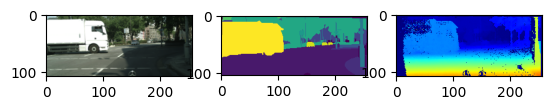

In [16]:
img_dict = test_set.__getitem__(21)
img = img_dict['image'][:, :-20]
sem = img_dict['semantic'][:-25, :]
depth = img_dict['depth'][:, :-20]
print(img.shape, sem.shape, depth.shape)

plt.subplot(1,3,1)
plt.imshow(img.permute(1, 2, 0))
plt.subplot(1,3,2)
plt.imshow(sem)
plt.subplot(1,3,3)
plt.imshow(depth.permute(1, 2, 0), cmap='jet')

## DataLoader

In [17]:
from torch . utils . data import DataLoader
batch_size = 2
train_loader = DataLoader ( train_set , batch_size = batch_size , shuffle = True )
test_loader = DataLoader ( test_set , batch_size = batch_size , shuffle = False )

### check dataset

In [18]:
for i, batch in tqdm(enumerate(train_loader)):
    print(batch['depth'].shape,batch['semantic'].shape )
    break

0it [00:00, ?it/s]

torch.Size([2, 1, 128, 256]) torch.Size([2, 128, 256])


In [19]:
len(train_loader.dataset), len(test_loader.dataset)

(2975, 500)

In [20]:
if execution_env == 'kaggle':
    root = '/kaggle/input/prepcityscapes'
else:
    root = 'dataset/prepcityscapes'

In [21]:
dataset = CityScapesDataset(root, split='train')

Sample image path: dataset/prepcityscapes\leftImg8bit\train\aachen_000000_000019_leftImg8bit.png
Sample mask path: dataset/prepcityscapes\gtFine\train\aachen_000000_000019_gtFine_labelIds.png
Sample depth path: dataset/prepcityscapesdepth\depth\train\aachen_000000_000019_depth.png


### Augmentations

In [22]:
import torch
from torchvision import transforms
import torchvision.transforms.functional as TF
# from albumentations.augmentations.transforms import RandomShadow

class Normalize(object):
    """ Normalizes RGB image to  0-mean 1-std_dev """ 
    def __init__(self, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], depth_norm=5, max_depth=250):
        self.mean = mean
        self.std = std
        self.depth_norm = depth_norm
        self.max_depth = max_depth

    def __call__(self, sample):
        left, mask, depth = sample['left'], sample['mask'], sample['depth']
            
        return {'left': TF.normalize(left, self.mean, self.std), 
                'mask': mask, 
                'depth' : torch.clip( # saftey clip :)
                            torch.log(torch.clip(depth, 0, self.max_depth))/self.depth_norm, 
                            0, 
                            self.max_depth),
               }


class AddColorJitter(object):
    """Convert a color image to grayscale and normalize the color range to [0,1].""" 
    def __init__(self, brightness, contrast, saturation, hue):
        ''' Applies brightness, constrast, saturation, and hue jitter to image ''' 
        self.color_jitter = transforms.ColorJitter(brightness, contrast, saturation, hue)

    def __call__(self, sample):
        left, mask, depth = sample['left'], sample['mask'], sample['depth']

        return {'left': self.color_jitter(left), 
                'mask': mask, 
                'depth' : depth}


class Rescale(object):
    """ Rescales images with bilinear interpolation and masks with nearest interpolation """

    def __init__(self, h, w):
        self.h, self.w = h, w

    def __call__(self, sample):
        left, mask, depth = sample['left'], sample['mask'], sample['depth']
        
        # Get original dimensions
        orig_h, orig_w = left.shape[-2], left.shape[-1]

        # Rescale left image
        left = TF.resize(left, (self.h, self.w))
        
        # Rescale mask with nearest neighbor interpolation
        mask = TF.resize(mask.unsqueeze(0), (self.h, self.w), transforms.InterpolationMode.NEAREST).squeeze(0)
        
        # Rescale depth
        depth = TF.resize(depth.unsqueeze(0), (self.h, self.w)).squeeze(0)


        return {
            'left': left,
            'mask': mask,
            'depth': depth,
        }


class RandomCrop(object):
    def __init__(self, h, w, scale=(0.08, 1.0), ratio=(3.0 / 4.0, 4.0 / 3.0)):
        self.h = h
        self.w = w
        self.scale = scale
        self.ratio = ratio

    def __call__(self, sample):
        left, mask, depth = sample['left'], sample['mask'], sample['depth']
        i, j, h, w = transforms.RandomResizedCrop.get_params(left, scale=self.scale, ratio=self.ratio)

        return {'left': TF.resized_crop(left, i, j, h, w, (self.h, self.w)), 
                'mask': TF.resized_crop(mask.unsqueeze(0), i, j, h, w, (self.h, self.w), interpolation=TF.InterpolationMode.NEAREST),
                'depth' : TF.resized_crop(depth.unsqueeze(0), i, j, h, w, (self.h, self.w))}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    def __call__(self, sample):
         
        left, mask, depth = sample['left'], sample['mask'], sample['depth']
        return {'left': transforms.ToTensor()(left), 
                'mask': torch.as_tensor(mask, dtype=torch.int64),
                'depth' : transforms.ToTensor()(depth).type(torch.float32),
               }
    

class ElasticTransform(object):
    def __init__(self, alpha=25.0, sigma=5.0, prob=0.5):
        self.alpha = [1.0, alpha]
        self.sigma = [1, sigma]
        self.prob = prob

    def __call__(self, sample):
        
        if torch.rand(1) < self.prob:

            left, mask, depth = sample['left'], sample['mask'], sample['depth']
            _, H, W = mask.shape
            displacement = transforms.ElasticTransform.get_params(self.alpha, self.sigma, [H, W])

            # # TEMP
            # print(TF.elastic_transform(left, displacement).shape)
            # print(TF.elastic_transform(mask.unsqueeze(0), displacement, interpolation=TF.InterpolationMode.NEAREST).shape)
            # print(torch.clip(TF.elastic_transform(depth, displacement), 0, depth.max()).shape)

            return {'left': TF.elastic_transform(left, displacement), 
                    'mask': TF.elastic_transform(mask.unsqueeze(0), displacement, interpolation=TF.InterpolationMode.NEAREST), 
                    'depth' : torch.clip(TF.elastic_transform(depth, displacement), 0, depth.max())} 
        
        else:
            return sample

        
    

# new transform to rotate the images
class RandomRotate(object):
    def __init__(self, angle):
        if not isinstance(angle, (list, tuple)):
            self.angle = (-abs(angle), abs(angle))
        else:
            self.angle = angle

    def __call__(self, sample):
        left, mask, depth = sample['left'], sample['mask'], sample['depth']

        angle = transforms.RandomRotation.get_params(self.angle)

        return {'left': TF.rotate(left, angle), 
                'mask': TF.rotate(mask.unsqueeze(0), angle), 
                'depth' : TF.rotate(depth, angle)}
    
    
class RandomHorizontalFlip(object):
    def __init__(self, prob=0.5):
        self.prob = prob

    def __call__(self, sample):
        
        if torch.rand(1) < self.prob:
            left, mask, depth = sample['left'], sample['mask'], sample['depth']
            return {'left': TF.hflip(left), 
                    'mask': TF.hflip(mask), 
                    'depth' : TF.hflip(depth)}
        else:
            return sample
        

class RandomVerticalFlip(object):
    def __init__(self, prob=0.5):
        self.prob = prob

    def __call__(self, sample):
        if torch.rand(1) < self.prob:
            left, mask, depth = sample['left'], sample['mask'], sample['depth']
            return {'left': TF.vflip(left), 
                    'mask': TF.vflip(mask), 
                    'depth' : TF.vflip(depth)}
        else:
            return sample

### Transforms

In [110]:
OG_W, OG_H = 2048, 800 # OG width and height after crop
# W, H = int(OG_W//9.14), int(OG_H//3.57) # resize w,h for training
W, H = int(OG_W//16), int(OG_H//6.25) # resize w,h for training
BATCH_SIZE = 5
# W, H = int(OG_W//32), int(OG_H//12.5) # resize w,h for training

# transform = transforms.Compose([
#     ToTensor(),
#     RandomCrop(H, W),
#     # ElasticTransform(alpha=100.0, sigma=25.0, prob=0.5),
#     AddColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
#     RandomHorizontalFlip(0.5),
#     RandomVerticalFlip(0.2),
#     # RandomRotate((-30, 30)),
#     Normalize()
# ])

transform = transforms.Compose([
    ToTensor(),
    Rescale(H, W),
    Normalize()
])


valid_transform = transforms.Compose([
    ToTensor(),
    Rescale(H, W),
    # Normalize()
])

test_transform = transforms.Compose([
    ToTensor(),
    Rescale(H, W),
    # Normalize()
])

def custom_collate_fn(batch):
     """
     Handles batches with variable-sized bounding boxes.
     """
     images = torch.stack([item['left'] for item in batch])  # Stack images
     masks = torch.stack([item['mask'] for item in batch])  # Stack masks
     depths = torch.stack([item['depth'] for item in batch])  # Stack depths
    
    
     return {'left': images, 'mask': masks, 'depth': depths}

# def custom_collate_fn(batch):
    # return tuple(zip(*batch))

train_dataset = CityScapesDataset(root, transform=transform, split='train', label_map='trainId') # 'trainId')
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=custom_collate_fn, pin_memory=False, shuffle=False, drop_last=True)

# temp_valid_dataset = CityScapesDataset(root, transform=valid_transform, split='val', label_map='trainId', crop=False)
valid_dataset = CityScapesDataset(root, transform=valid_transform, split='val', label_map='trainId')
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, collate_fn=custom_collate_fn, pin_memory=False, shuffle=False, drop_last=True)

test_dataset = CityScapesDataset(root, transform=test_transform, split='test', label_map='trainId')
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=custom_collate_fn, pin_memory=False, shuffle=False,drop_last=True)

Sample image path: dataset/prepcityscapes\leftImg8bit\train\aachen_000000_000019_leftImg8bit.png
Sample mask path: dataset/prepcityscapes\gtFineI\train\aachen_000000_000019_gtFine_instanceIds.png
Sample depth path: dataset/prepcityscapesdepth\depth\train\aachen_000000_000019_depth.png
Sample image path: dataset/prepcityscapes\leftImg8bit\val\frankfurt_000000_000294_leftImg8bit.png
Sample mask path: dataset/prepcityscapes\gtFineI\val\frankfurt_000000_000294_gtFine_instanceIds.png
Sample depth path: dataset/prepcityscapesdepth\depth\val\frankfurt_000000_000294_depth.png
Sample image path: dataset/prepcityscapes\leftImg8bit\test\berlin_000000_000019_leftImg8bit.png
Sample mask path: dataset/prepcityscapes\gtFineI\test\berlin_000000_000019_gtFine_instanceIds.png
Sample depth path: dataset/prepcityscapesdepth\depth\test\berlin_000000_000019_depth.png


In [111]:
train_loader_c = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=custom_collate_fn, pin_memory=False, shuffle=False)
valid_loader_c = DataLoader(valid_dataset, batch_size=BATCH_SIZE, collate_fn=custom_collate_fn, pin_memory=False, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=custom_collate_fn, pin_memory=False, shuffle=False)

## compute_loss

In [25]:
def compute_loss(x_pred, x_output, task_type):
    device = x_pred.device

    # binary mark to mask out undefined pixel space
    binary_mask = (torch.sum(x_output, dim=1) != 0).float().unsqueeze(1).to(device)

    if task_type == 'semantic':
        # semantic loss : depth - wise cross entropy
        loss = F.nll_loss(x_pred, x_output, ignore_index=-1)

    if task_type == 'depth':
        # depth loss : l1 norm
        loss = torch.sum(torch.abs(x_pred - x_output) * binary_mask) / torch.nonzero(
            binary_mask, as_tuple=False).size(0)

    return loss
xx = torch.rand(4,13,128,256)
yy = torch.rand(4,128,256).long()
print(compute_loss(xx,yy,'semantic'))

tensor(-0.4984)


In [26]:
# import torch.nn as nn

# class GLPDepthWithSegmentation(nn.Module):
#     def __init__(self):
#         super(GLPDepthWithSegmentation, self).__init__()
#         # initialise network parameters

#         filter = [64, 128, 256, 512, 512]

#         self.class_nb = 21

#         # define encoder decoder layers
#         self.ViT_encoder_block = nn.ModuleList([self.conv_layer([3, filter[0]])])
#         self.decoder_block = nn.ModuleList([self.conv_layer([filter[0], filter[0]])])
#         for i in range(4):
#             self.ViT_encoder_block.append(self.conv_layer([filter[i], filter[i + 1]]))
#             self.decoder_block.append(self.conv_layer([filter[i + 1], filter[i]]))

#         # define convolution layer with
#         self.tranformer_block = nn.ModuleList([self.conv_layer([filter[0], filter[0]])])
#         self.mlp = nn.ModuleList([self.conv_layer([filter[0], filter[0]])])
#         for i in range(4):
#             if i == 0:
#                 self.tranformer_block.append(self.conv_layer([filter[i + 1], filter[i + 1]]))
#                 self.mlp.append(self.conv_layer([filter[i], filter[i]]))
#             else:
#                 self.tranformer_block.append(nn.Sequential(self.conv_layer([filter[i + 1], filter[i + 1]]),
#                                                           self.conv_layer([filter[i + 1], filter[i + 1]])))
#                 self.mlp.append(nn.Sequential(self.conv_layer([filter[i], filter[i]]),
#                                                           self.conv_layer([filter[i], filter[i]])))

#         # define task specific layers
#         self.SegFormerDecoder = nn.Sequential(nn.Conv2d(in_channels=filter[0], out_channels=filter[0], kernel_size=3, padding=1),
#                                          nn.Conv2d(in_channels=filter[0], out_channels=self.class_nb, kernel_size=1, padding=0))
#         self.GLPDepthDecoder = nn.Sequential(nn.Conv2d(in_channels=filter[0], out_channels=filter[0], kernel_size=3, padding=1),
#                                          nn.Conv2d(in_channels=filter[0], out_channels=1, kernel_size=1, padding=0))

#         # define pooling and unpooling functions
#         self.down_sampling = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
#         self.up_sampling = nn.MaxUnpool2d(kernel_size=2, stride=2)

#         for m in self.modules():
#             if isinstance(m, nn.Conv2d):
#                 nn.init.xavier_normal_(m.weight)
#                 nn.init.constant_(m.bias, 0)
#             elif isinstance(m, nn.BatchNorm2d):
#                 nn.init.constant_(m.weight, 1)
#                 nn.init.constant_(m.bias, 0)
#             elif isinstance(m, nn.Linear):
#                 nn.init.xavier_normal_(m.weight)
#                 nn.init.constant_(m.bias, 0)

#     # define convolutional block
#     def conv_layer(self, channel):
#         conv_block = nn.Sequential(
#             nn.Conv2d(in_channels=channel[0], out_channels=channel[1], kernel_size=3, padding=1),
#             nn.BatchNorm2d(num_features=channel[1]),
#             nn.GELU()
#         )
#         return conv_block

#     def forward(self, x):
#         g_encoder, g_decoder, g_maxpool, g_upsampl, indices = ([0] * 5 for _ in range(5))
#         for i in range(5):
#             g_encoder[i], g_decoder[-i - 1] = ([0] * 2 for _ in range(2))

#         # global shared encoder - decoder network
#         for i in range(5):
#             if i == 0:
#                 g_encoder[i][0] = self.ViT_encoder_block[i](x)
#                 g_encoder[i][1] = self.tranformer_block[i](g_encoder[i][0])
#                 g_maxpool[i], indices[i] = self.down_sampling(g_encoder[i][1])
#             else:
#                 g_encoder[i][0] = self.ViT_encoder_block[i](g_maxpool[i - 1])
#                 g_encoder[i][1] = self.tranformer_block[i](g_encoder[i][0])
#                 g_maxpool[i], indices[i] = self.down_sampling(g_encoder[i][1])

#         for i in range(5):
#             if i == 0:
#                 g_upsampl[i] = self.up_sampling(g_maxpool[-1], indices[-i - 1])
#                 g_decoder[i][0] = self.decoder_block[-i - 1](g_upsampl[i])
#                 g_decoder[i][1] = self.mlp[-i - 1](g_decoder[i][0])
#             else:
#                 g_upsampl[i] = self.up_sampling(g_decoder[i - 1][-1], indices[-i - 1])
#                 g_decoder[i][0] = self.decoder_block[-i - 1](g_upsampl[i])
#                 g_decoder[i][1] = self.mlp[-i - 1](g_decoder[i][0])

#         # define task prediction layers
#         pred_seg = F.log_softmax(self.SegFormerDecoder(g_decoder[i][1]), dim=1)
#         pred_d = self.GLPDepthDecoder(g_decoder[i][1])

#         return {'semantic': pred_seg, 'depth': pred_d}


# Model

### RevisedLayerNorm

In [27]:
class RevisedLayerNorm(nn.Module):
    """Revised LayerNorm"""
    def __init__(self, embed_dim, epsilon=1e-5, detach_gradient=False):
        super(RevisedLayerNorm, self).__init__()
        self.epsilon = epsilon
        self.detach_gradient = detach_gradient

        self.scale = nn.Parameter(torch.ones((1, embed_dim, 1, 1)))
        self.shift = nn.Parameter(torch.zeros((1, embed_dim, 1, 1)))

        self.scale_mlp = nn.Conv2d(1, embed_dim, 1)
        self.shift_mlp = nn.Conv2d(1, embed_dim, 1)

        trunc_normal_(self.scale_mlp.weight, std=.02)
        nn.init.constant_(self.scale_mlp.bias, 1)

        trunc_normal_(self.shift_mlp.weight, std=.02)
        nn.init.constant_(self.shift_mlp.bias, 0)

    def forward(self, input_tensor):
        mean_value = torch.mean(input_tensor, dim=(1, 2, 3), keepdim=True)
        std_value = torch.sqrt((input_tensor - mean_value).pow(2).mean(dim=(1, 2, 3), keepdim=True) + self.epsilon)

        normalized_tensor = (input_tensor - mean_value) / std_value

        if self.detach_gradient:
            rescale, rebias = self.scale_mlp(std_value.detach()), self.shift_mlp(mean_value.detach())
        else:
            rescale, rebias = self.scale_mlp(std_value), self.shift_mlp(mean_value)

        output = normalized_tensor * self.scale + self.shift
        return output, rescale, rebias



In [28]:
class MultiLayerPerceptron(nn.Module):
    def __init__(self, depth, input_channels, hidden_channels=None, output_channels=None):
        super().__init__()
        output_channels = output_channels or input_channels
        hidden_channels = hidden_channels or input_channels

        self.depth = depth

        self.mlp_layers = nn.Sequential(
            nn.Conv2d(input_channels, hidden_channels, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_channels, output_channels, kernel_size=1)
        )

        self.apply(self._initialize_weights)

    def _initialize_weights(self, layer):
        if isinstance(layer, nn.Conv2d):
            gain = (8 * self.depth) ** (-1 / 4)
            fan_in, fan_out = torch.nn.init._calculate_fan_in_and_fan_out(layer.weight)
            std = gain * math.sqrt(2.0 / float(fan_in + fan_out))
            trunc_normal_(layer.weight, std=std)
            if layer.bias is not None:
                nn.init.constant_(layer.bias, 0)

    def forward(self, x):
        return self.mlp_layers(x)


def partition_into_windows(tensor, window_size):
    """Splits the input tensor into non-overlapping windows."""
    batch_size, height, width, channels = tensor.shape
    assert height % window_size == 0 and width % window_size == 0, "Height and width must be divisible by window_size"

    tensor = tensor.view(
        batch_size, height // window_size, window_size, width // window_size, window_size, channels
    )
    windows = tensor.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size**2, channels)
    return windows


def merge_windows(windows, window_size, height, width):
    """Reconstructs the original tensor from partitioned windows."""
    batch_size = windows.shape[0] // ((height * width) // (window_size**2))
    tensor = windows.view(
        batch_size, height // window_size, width // window_size, window_size, window_size, -1
    )
    tensor = tensor.permute(0, 1, 3, 2, 4, 5).contiguous().view(batch_size, height, width, -1)
    return tensor


### test

In [29]:

# Initialize the MultiLayerPerceptron with sample parameters
depth = 4
input_channels = 64
hidden_channels = 128
output_channels = 64

mlp = MultiLayerPerceptron(depth, input_channels, hidden_channels, output_channels)

# Create a random tensor to test MLP (batch_size=2, channels=64, height=16, width=16)
input_tensor = torch.randn(2, 64, 16, 16)
output_tensor = mlp(input_tensor)

# Check output shape
mlp_output_shape = output_tensor.shape

# Test window partition and merging
batch_size, height, width, channels = 2, 16, 16, 64
window_size = 4

# Create a random tensor for window functions (B, H, W, C) format
input_window_tensor = torch.randn(batch_size, height, width, channels)

# Apply partitioning and merging
windows = partition_into_windows(input_window_tensor, window_size)
reconstructed_tensor = merge_windows(windows, window_size, height, width)

# Check shapes
windows_shape = windows.shape
reconstructed_shape = reconstructed_tensor.shape

# Validate if the reconstruction matches the original input shape
is_shape_correct = reconstructed_shape == input_window_tensor.shape

# Output results
mlp_output_shape, windows_shape, reconstructed_shape, is_shape_correct


(torch.Size([2, 64, 16, 16]),
 torch.Size([32, 16, 64]),
 torch.Size([2, 16, 16, 64]),
 True)

### LocalWindowAttention

In [30]:
class LocalWindowAttention(nn.Module):
    def __init__(self, embed_dim, window_size, num_heads):
        """Self-attention mechanism within local windows."""
        super().__init__()
        self.embed_dim = embed_dim
        self.window_size = window_size  # (height, width)
        self.num_heads = num_heads
        head_dim = embed_dim // num_heads
        self.scaling_factor = head_dim ** -0.5  # Scaled dot-product attention

        # Compute and store relative positional encodings
        relative_positional_encodings = compute_log_relative_positions(self.window_size)
        self.register_buffer("relative_positional_encodings", relative_positional_encodings)

        # Learnable transformation of relative position embeddings
        self.relative_mlp = nn.Sequential(
            nn.Linear(2, 256, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_heads, bias=True)
        )

        self.attention_softmax = nn.Softmax(dim=-1)

    def forward(self, qkv):
        """Computes attention scores and applies self-attention within a window."""
        batch_size, num_tokens, _ = qkv.shape

        # Reshape qkv into separate query, key, and value tensors
        qkv = qkv.reshape(batch_size, num_tokens, 3, self.num_heads, self.embed_dim // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # Unpacking query, key, and value

        # Scale query for stable attention computation
        q = q * self.scaling_factor
        attention_scores = q @ k.transpose(-2, -1)

        # Compute relative position bias
        relative_bias = self.relative_mlp(self.relative_positional_encodings)
        relative_bias = relative_bias.permute(2, 0, 1).contiguous()  # Shape: (num_heads, window_size², window_size²)
        attention_scores = attention_scores + relative_bias.unsqueeze(0)

        # Apply softmax and compute weighted values
        attention_weights = self.attention_softmax(attention_scores)
        output = (attention_weights @ v).transpose(1, 2).reshape(batch_size, num_tokens, self.embed_dim)

        return output


#### compute_log_relative_positions

In [31]:
def compute_log_relative_positions(window_size):
    """Computes log-scaled relative position embeddings for a given window size."""
    coord_range = torch.arange(window_size)

    # Create coordinate grid
    coord_grid = torch.stack(torch.meshgrid([coord_range, coord_range]))  # Shape: (2, window_size, window_size)
    
    # Flatten coordinates
    flattened_coords = torch.flatten(coord_grid, 1)  # Shape: (2, window_size * window_size)

    # Compute relative positions
    relative_positions = flattened_coords[:, :, None] - flattened_coords[:, None, :]  # Shape: (2, window_size^2, window_size^2)

    # Format and apply log transformation
    relative_positions = relative_positions.permute(1, 2, 0).contiguous()  # Shape: (window_size^2, window_size^2, 2)
    log_relative_positions = torch.sign(relative_positions) * torch.log(1. + relative_positions.abs())

    return log_relative_positions


### AdaptiveAttention

In [32]:
class AdaptiveAttention(nn.Module):
    def __init__(self, network_depth, embed_dim, num_heads, window_size, shift_size, enable_attention=False, conv_mode=None):
        """Hybrid attention-convolution module with optional window-based attention."""
        super().__init__()
        self.embed_dim = embed_dim
        self.head_dim = embed_dim // num_heads
        self.num_heads = num_heads

        self.window_size = window_size
        self.shift_size = shift_size

        self.network_depth = network_depth
        self.enable_attention = enable_attention
        self.conv_mode = conv_mode

        # Define convolutional processing based on mode
        if self.conv_mode == 'Conv':
            self.conv_layer = nn.Sequential(
                nn.Conv2d(embed_dim, embed_dim, kernel_size=3, padding=1, padding_mode='reflect'),
                nn.ReLU(inplace=True),
                nn.Conv2d(embed_dim, embed_dim, kernel_size=3, padding=1, padding_mode='reflect')
            )

        if self.conv_mode == 'DWConv':
            self.conv_layer = nn.Conv2d(embed_dim, embed_dim, kernel_size=5, padding=2, groups=embed_dim, padding_mode='reflect')

        if self.conv_mode == 'DWConv' or self.enable_attention:
            self.value_projection = nn.Conv2d(embed_dim, embed_dim, 1)
            self.output_projection = nn.Conv2d(embed_dim, embed_dim, 1)

        if self.enable_attention:
            self.query_key_projection = nn.Conv2d(embed_dim, embed_dim * 2, 1)
            self.window_attention = LocalWindowAttention(embed_dim, window_size, num_heads)

        self.apply(self._initialize_weights)

    def _initialize_weights(self, module):
        """Custom weight initialization."""
        if isinstance(module, nn.Conv2d):
            weight_shape = module.weight.shape

            if weight_shape[0] == self.embed_dim * 2:  # Query-Key projection
                fan_in, fan_out = _calculate_fan_in_and_fan_out(module.weight)
                std = math.sqrt(2.0 / float(fan_in + fan_out))
                trunc_normal_(module.weight, std=std)
            else:
                gain = (8 * self.network_depth) ** (-1/4)
                fan_in, fan_out = _calculate_fan_in_and_fan_out(module.weight)
                std = gain * math.sqrt(2.0 / float(fan_in + fan_out))
                trunc_normal_(module.weight, std=std)

            if module.bias is not None:
                nn.init.constant_(module.bias, 0)

    def pad_for_window_processing(self, x, shift=False):
        """Pads the input tensor to fit window processing requirements with left and right shifts."""
        _, _, height, width = x.size()
        pad_h = (self.window_size - height % self.window_size) % self.window_size
        pad_w = (self.window_size - width % self.window_size) % self.window_size

        if shift:
            # Apply left or right shift instead of cyclic shift
            x = F.pad(x, (self.shift_size, (self.window_size - self.shift_size + pad_w) % self.window_size,
                          0, (self.window_size - pad_h) % self.window_size), mode='reflect')
        else:
            x = F.pad(x, (0, pad_w, 0, pad_h), 'reflect')

        return x

    def forward(self, x):
        """Computes the output with optional attention and convolution."""
        batch_size, channels, height, width = x.shape

        if self.conv_mode == 'DWConv' or self.enable_attention:
            v_proj = self.value_projection(x)

        if self.enable_attention:
            qk_proj = self.query_key_projection(x)
            qkv = torch.cat([qk_proj, v_proj], dim=1)

            # Apply padding for shifted window processing
            padded_qkv = self.pad_for_window_processing(qkv, self.shift_size > 0)
            padded_height, padded_width = padded_qkv.shape[2:]

            # Partition into windows
            padded_qkv = padded_qkv.permute(0, 2, 3, 1)
            qkv_windows = partition_into_windows(padded_qkv, self.window_size)  # (num_windows * batch, window_size², channels)

            # Apply window-based attention
            attn_windows = self.window_attention(qkv_windows)

            # Merge back to original spatial dimensions
            merged_output = merge_windows(attn_windows, self.window_size, padded_height, padded_width)

            # Apply left or right shift (avoid cyclic)
            attn_output = merged_output[:, self.shift_size:(self.shift_size + height), 0:(self.shift_size + width), :]
            attn_output = attn_output.permute(0, 3, 1, 2)

            if self.conv_mode in ['Conv', 'DWConv']:
                conv_output = self.conv_layer(v_proj)
                print(f"conv_output shape: {conv_output.shape}")
                print(f"attn_output shape: {attn_output.shape}")
                # print(f"conv_output + attn_output shape: {conv_output + attn_output.shape}")
                print(f"self.output_projection: {self.output_projection}")
                output = self.output_projection(conv_output + attn_output)
            else:
                output = self.output_projection(attn_output)

        else:
            if self.conv_mode == 'Conv':
                output = self.conv_layer(x)  # No attention, using convolution only
            elif self.conv_mode == 'DWConv':
                output = self.output_projection(self.conv_layer(v_proj))

        return output


### VisionTransformerBlock

In [33]:
class VisionTransformerBlock(nn.Module):
    def __init__(self, network_depth, embed_dim, num_heads, mlp_ratio=4.0,
                 norm_layer=nn.LayerNorm, enable_mlp_norm=False,
                 window_size=8, shift_size=0, enable_attention=True, conv_mode=None):
        """
        A transformer block that includes attention (optional) and MLP layers.
        """
        super().__init__()
        self.enable_attention = enable_attention
        self.enable_mlp_norm = enable_mlp_norm

        self.pre_norm = norm_layer(embed_dim) if enable_attention else nn.Identity()
        self.attention_layer = AdaptiveAttention(
            network_depth, embed_dim, num_heads=num_heads, window_size=window_size,
            shift_size=shift_size, enable_attention=enable_attention, conv_mode=conv_mode
        )

        self.post_norm = norm_layer(embed_dim) if enable_attention and enable_mlp_norm else nn.Identity()
        self.mlp_layer = MultiLayerPerceptron(network_depth, embed_dim, hidden_channels=int(embed_dim * mlp_ratio))

    def forward(self, x):
        """
        Forward pass through the transformer block.
        """
        residual = x
        if self.enable_attention:
            x, rescale, rebias = self.pre_norm(x)
        x = self.attention_layer(x)
        if self.enable_attention:
            x = x * rescale + rebias
        x = residual + x  # Residual connection

        residual = x
        if self.enable_attention and self.enable_mlp_norm:
            x, rescale, rebias = self.post_norm(x)
        x = self.mlp_layer(x)
        if self.enable_attention and self.enable_mlp_norm:
            x = x * rescale + rebias
        x = residual + x  # Residual connection

        return x

### PatchEmbedding and PatchReconstruction

In [34]:
class PatchEmbedding(nn.Module):
    def __init__(self, patch_size=4, input_channels=3, embedding_dim=96, kernel_size=None):
        """
        Patch embedding module that projects input images into token embeddings.
        """
        super().__init__()
        self.input_channels = input_channels
        self.embedding_dim = embedding_dim

        if kernel_size is None:
            kernel_size = patch_size

        self.projection = nn.Conv2d(
            input_channels, embedding_dim, kernel_size=kernel_size, stride=patch_size,
            padding=(kernel_size - patch_size + 1) // 2, padding_mode='reflect'
        )

    def forward(self, x):
        """
        Forward pass to generate patch embeddings.
        """
        return self.projection(x)


class PatchReconstruction(nn.Module):
    def __init__(self, patch_size=4, output_channels=3, embedding_dim=96, kernel_size=None):
        """
        Patch reconstruction module that converts token embeddings back to image patches.
        """
        super().__init__()
        self.output_channels = output_channels
        self.embedding_dim = embedding_dim

        if kernel_size is None:
            kernel_size = 1

        self.projection = nn.Sequential(
            nn.Conv2d(
                embedding_dim, output_channels * patch_size ** 2, kernel_size=kernel_size,
                padding=kernel_size // 2, padding_mode='reflect'
            ),
            nn.PixelShuffle(patch_size)
        )

    def forward(self, x):
        """
        Forward pass to reconstruct image from embeddings.
        """
        return self.projection(x)


### SelectiveKernelFusion

In [35]:
class SelectiveKernelFusion(nn.Module):
    def __init__(self, channels, num_branches=2, reduction_ratio=8):
        """
        Selective Kernel Fusion (SKFusion) module for adaptive feature selection.

        Args:
            channels (int): Number of input channels.
            num_branches (int): Number of feature branches to fuse.
            reduction_ratio (int): Reduction ratio for the attention mechanism.
        """
        super().__init__()
        
        self.num_branches = num_branches
        reduced_channels = max(int(channels / reduction_ratio), 4)
        
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.channel_attention = nn.Sequential(
            nn.Conv2d(channels, reduced_channels, kernel_size=1, bias=False), 
            nn.ReLU(),
            nn.Conv2d(reduced_channels, channels * num_branches, kernel_size=1, bias=False)
        )
        
        self.softmax = nn.Softmax(dim=1)

    def forward(self, feature_maps):
        """
        Forward pass for selective kernel fusion.

        Args:
            feature_maps (list of tensors): A list of feature maps to be fused.

        Returns:
            torch.Tensor: The adaptively fused feature map.
        """
        batch_size, channels, height, width = feature_maps[0].shape
        
        # Concatenate feature maps along a new dimension (num_branches)
        stacked_features = torch.cat(feature_maps, dim=1).view(batch_size, self.num_branches, channels, height, width)
        
        # Compute attention weights
        aggregated_features = torch.sum(stacked_features, dim=1)
        attention_weights = self.channel_attention(self.global_avg_pool(aggregated_features))
        attention_weights = self.softmax(attention_weights.view(batch_size, self.num_branches, channels, 1, 1))

        # Weighted sum of input feature maps
        fused_output = torch.sum(stacked_features * attention_weights, dim=1)
        return fused_output


### TransformerStage

In [36]:
class TransformerStage(nn.Module):
    def __init__(self, network_depth, embed_dim, num_layers, num_heads, mlp_ratio=4.0,
                 norm_layer=nn.LayerNorm, window_size=8,
                 attention_ratio=0.0, attention_placement='last', conv_mode=None):
        """
        A stage of transformer blocks with configurable attention placement.
        """
        super().__init__()
        self.embed_dim = embed_dim
        self.num_layers = num_layers

        attention_layers = int(attention_ratio * num_layers)

        if attention_placement == 'last':
            enable_attentions = [i >= num_layers - attention_layers for i in range(num_layers)]
        elif attention_placement == 'first':
            enable_attentions = [i < attention_layers for i in range(num_layers)]
        elif attention_placement == 'middle':
            enable_attentions = [
                (i >= (num_layers - attention_layers) // 2) and (i < (num_layers + attention_layers) // 2)
                for i in range(num_layers)
            ]

        # Build transformer blocks
        self.blocks = nn.ModuleList([
            VisionTransformerBlock(
                network_depth=network_depth,
                embed_dim=embed_dim,
                num_heads=num_heads,
                mlp_ratio=mlp_ratio,
                norm_layer=norm_layer,
                window_size=window_size,
                shift_size=0 if (i % 2 == 0) else window_size // 2,
                enable_attention=enable_attentions[i],
                conv_mode=conv_mode
            ) for i in range(num_layers)
        ])

    def forward(self, x):
        """
        Forward pass through the transformer stage.
        """
        for block in self.blocks:
            x = block(x)
        return x


## DehazingTransformer

In [37]:
class DehazingTransformer(nn.Module):
    def __init__(self, input_channels=3, output_channels=4, window_size=8,
                 embed_dims=[24, 48, 96, 48, 24],
                 mlp_ratios=[2., 4., 4., 2., 2.],
                 layer_depths=[16, 16, 16, 8, 8],
                 num_heads=[2, 4, 6, 1, 1],
                 attention_ratios=[1/4, 1/2, 3/4, 0, 0],
                 conv_types=['DWConv', 'DWConv', 'DWConv', 'DWConv', 'DWConv'],
                 norm_layers=[RevisedLayerNorm, RevisedLayerNorm, RevisedLayerNorm, RevisedLayerNorm, RevisedLayerNorm]):
        super().__init__()

        # Patch embedding settings
        self.patch_size = 4
        self.window_size = window_size

        # Initial patch embedding
        self.patch_embed = PatchEmbedding(
            patch_size=1, input_channels=input_channels, embedding_dim=embed_dims[0], kernel_size=3)

        # Backbone layers
        self.encoder_stage1 = TransformerStage(
            network_depth=sum(layer_depths),
            embed_dim=embed_dims[0],
            num_layers=layer_depths[0],
            num_heads=num_heads[0],
            mlp_ratio=mlp_ratios[0],
            norm_layer=norm_layers[0],
            window_size=window_size,
            attention_ratio=attention_ratios[0],
            attention_placement='last',
            conv_mode=conv_types[0]
        )
        
        self.downsample1 = PatchEmbedding(
            patch_size=2, input_channels=embed_dims[0], embedding_dim=embed_dims[1]
        )
        
        self.skip_connection1 = nn.Conv2d(embed_dims[0], embed_dims[0], 1)
        
        self.encoder_stage2 = TransformerStage(
            network_depth=sum(layer_depths),
            embed_dim=embed_dims[1],
            num_layers=layer_depths[1],
            num_heads=num_heads[1],
            mlp_ratio=mlp_ratios[1],
            norm_layer=norm_layers[1],
            window_size=window_size,
            attention_ratio=attention_ratios[1],
            attention_placement='last',
            conv_mode=conv_types[1]
        )
        
        self.downsample2 = PatchEmbedding(
            patch_size=2, input_channels=embed_dims[1], embedding_dim=embed_dims[2]
        )
        
        self.skip_connection2 = nn.Conv2d(embed_dims[1], embed_dims[1], 1)
        
        self.encoder_stage3 = TransformerStage(
            network_depth=sum(layer_depths),
            embed_dim=embed_dims[2],
            num_layers=layer_depths[2],
            num_heads=num_heads[2],
            mlp_ratio=mlp_ratios[2],
            norm_layer=norm_layers[2],
            window_size=window_size,
            attention_ratio=attention_ratios[2],
            attention_placement='last',
            conv_mode=conv_types[2]
        )
        
        self.upsample1 = PatchReconstruction(
            patch_size=2, output_channels=embed_dims[3], embedding_dim=embed_dims[2]
        )
        
        assert embed_dims[1] == embed_dims[3]
        self.fusion_layer1 = SelectiveKernelFusion(embed_dims[3])
        
        self.decoder_stage1 = TransformerStage(
            network_depth=sum(layer_depths),
            embed_dim=embed_dims[3],
            num_layers=layer_depths[3],
            num_heads=num_heads[3],
            mlp_ratio=mlp_ratios[3],
            norm_layer=norm_layers[3],
            window_size=window_size,
            attention_ratio=attention_ratios[3],
            attention_placement='last',
            conv_mode=conv_types[3]
        )
        
        self.upsample2 = PatchReconstruction(
            patch_size=2, output_channels=embed_dims[4], embedding_dim=embed_dims[3]
        )
        
        assert embed_dims[0] == embed_dims[4]
        self.fusion_layer2 = SelectiveKernelFusion(embed_dims[4])
        
        self.decoder_stage2 = TransformerStage(
            network_depth=sum(layer_depths),
            embed_dim=embed_dims[4],
            num_layers=layer_depths[4],
            num_heads=num_heads[4],
            mlp_ratio=mlp_ratios[4],
            norm_layer=norm_layers[4],
            window_size=window_size,
            attention_ratio=attention_ratios[4],
            attention_placement='last',
            conv_mode=conv_types[4]
        )

        # Final patch reconstruction
        self.patch_reconstruction = PatchReconstruction(
            patch_size=1, output_channels=output_channels, embedding_dim=embed_dims[4], kernel_size=3)

    def adjust_image_size(self, x):
        # Ensures the input image size is compatible with the patch size
        _, _, height, width = x.size()
        pad_height = (self.patch_size - height % self.patch_size) % self.patch_size
        pad_width = (self.patch_size - width % self.patch_size) % self.patch_size
        x = F.pad(x, (0, pad_width, 0, pad_height), 'reflect')
        return x

    def extract_features(self, x):
        x = self.patch_embed(x)
        x = self.encoder_stage1(x)
        skip1 = x

        x = self.downsample1(x)
        x = self.encoder_stage2(x)
        skip2 = x

        x = self.downsample2(x)
        x = self.encoder_stage3(x)
        x = self.upsample1(x)

        x = self.fusion_layer1([x, self.skip_connection2(skip2)]) + x
        x = self.decoder_stage1(x)
        x = self.upsample2(x)

        x = self.fusion_layer2([x, self.skip_connection1(skip1)]) + x
        x = self.decoder_stage2(x)
        x = self.patch_reconstruction(x)
        return x

    def forward(self, x):
        original_height, original_width = x.shape[2:]
        x = self.adjust_image_size(x)

        features = self.extract_features(x)
        transmission_map, atmospheric_light = torch.split(features, (1, 3), dim=1)

        # Dehazing formula: I = J * t + A * (1 - t)
        x = transmission_map * x - atmospheric_light + x
        x = x[:, :, :original_height, :original_width]
        return x

#### build_dehazing_transformer

In [38]:
def build_dehazing_transformer():
    return DehazingTransformer(
        embed_dims=[24, 48, 96, 48, 24],
        mlp_ratios=[2., 4., 4., 2., 2.],
        layer_depths=[12, 12, 12, 6, 6],
        num_heads=[2, 4, 6, 1, 1],
        attention_ratios=[1/4, 1/2, 3/4, 0, 0],
        conv_types=['Conv', 'Conv', 'Conv', 'Conv', 'Conv']
    )

## RevisedLayerNorm

In [39]:
class RevisedLayerNorm(nn.Module):
    """Revised LayerNorm"""
    def __init__(self, embed_dim, epsilon=1e-5, detach_gradient=False):
        super(RevisedLayerNorm, self).__init__()
        self.epsilon = epsilon
        self.detach_gradient = detach_gradient

        self.scale = nn.Parameter(torch.ones((1, embed_dim, 1, 1)))
        self.shift = nn.Parameter(torch.zeros((1, embed_dim, 1, 1)))

        self.scale_mlp = nn.Conv2d(1, embed_dim, 1)
        self.shift_mlp = nn.Conv2d(1, embed_dim, 1)

        trunc_normal_(self.scale_mlp.weight, std=.02)
        nn.init.constant_(self.scale_mlp.bias, 1)

        trunc_normal_(self.shift_mlp.weight, std=.02)
        nn.init.constant_(self.shift_mlp.bias, 0)

    def forward(self, input_tensor):
        mean_value = torch.mean(input_tensor, dim=(1, 2, 3), keepdim=True)
        std_value = torch.sqrt((input_tensor - mean_value).pow(2).mean(dim=(1, 2, 3), keepdim=True) + self.epsilon)

        normalized_tensor = (input_tensor - mean_value) / std_value

        if self.detach_gradient:
            rescale, rebias = self.scale_mlp(std_value.detach()), self.shift_mlp(mean_value.detach())
        else:
            rescale, rebias = self.scale_mlp(std_value), self.shift_mlp(mean_value)

        output = normalized_tensor * self.scale + self.shift
        return output, rescale, rebias



In [40]:
class MultiLayerPerceptron(nn.Module):
    def __init__(self, depth, input_channels, hidden_channels=None, output_channels=None):
        super().__init__()
        output_channels = output_channels or input_channels
        hidden_channels = hidden_channels or input_channels

        self.depth = depth

        self.mlp_layers = nn.Sequential(
            nn.Conv2d(input_channels, hidden_channels, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_channels, output_channels, kernel_size=1)
        )

        self.apply(self._initialize_weights)

    def _initialize_weights(self, layer):
        if isinstance(layer, nn.Conv2d):
            gain = (8 * self.depth) ** (-1 / 4)
            fan_in, fan_out = torch.nn.init._calculate_fan_in_and_fan_out(layer.weight)
            std = gain * math.sqrt(2.0 / float(fan_in + fan_out))
            trunc_normal_(layer.weight, std=std)
            if layer.bias is not None:
                nn.init.constant_(layer.bias, 0)

    def forward(self, x):
        return self.mlp_layers(x)


def partition_into_windows(tensor, window_size):
    """Splits the input tensor into non-overlapping windows."""
    batch_size, height, width, channels = tensor.shape
    assert height % window_size == 0 and width % window_size == 0, "Height and width must be divisible by window_size"

    tensor = tensor.view(
        batch_size, height // window_size, window_size, width // window_size, window_size, channels
    )
    windows = tensor.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size**2, channels)
    return windows


def merge_windows(windows, window_size, height, width):
    """Reconstructs the original tensor from partitioned windows."""
    batch_size = windows.shape[0] // ((height * width) // (window_size**2))
    tensor = windows.view(
        batch_size, height // window_size, width // window_size, window_size, window_size, -1
    )
    tensor = tensor.permute(0, 1, 3, 2, 4, 5).contiguous().view(batch_size, height, width, -1)
    return tensor


### test

In [41]:
import torch

# Initialize the MultiLayerPerceptron with sample parameters
depth = 4
input_channels = 64
hidden_channels = 128
output_channels = 64

mlp = MultiLayerPerceptron(depth, input_channels, hidden_channels, output_channels)

# Create a random tensor to test MLP (batch_size=2, channels=64, height=16, width=16)
input_tensor = torch.randn(2, 64, 16, 16)
output_tensor = mlp(input_tensor)

# Check output shape
mlp_output_shape = output_tensor.shape

# Test window partition and merging
batch_size, height, width, channels = 2, 16, 16, 64
window_size = 4

# Create a random tensor for window functions (B, H, W, C) format
input_window_tensor = torch.randn(batch_size, height, width, channels)

# Apply partitioning and merging
windows = partition_into_windows(input_window_tensor, window_size)
reconstructed_tensor = merge_windows(windows, window_size, height, width)

# Check shapes
windows_shape = windows.shape
reconstructed_shape = reconstructed_tensor.shape

# Validate if the reconstruction matches the original input shape
is_shape_correct = reconstructed_shape == input_window_tensor.shape

# Output results
mlp_output_shape, windows_shape, reconstructed_shape, is_shape_correct


(torch.Size([2, 64, 16, 16]),
 torch.Size([32, 16, 64]),
 torch.Size([2, 16, 16, 64]),
 True)

In [42]:
class LocalWindowAttention(nn.Module):
    def __init__(self, embed_dim, window_size, num_heads):
        """Self-attention mechanism within local windows."""
        super().__init__()
        self.embed_dim = embed_dim
        self.window_size = window_size  # (height, width)
        self.num_heads = num_heads
        head_dim = embed_dim // num_heads
        self.scaling_factor = head_dim ** -0.5  # Scaled dot-product attention

        # Compute and store relative positional encodings
        relative_positional_encodings = compute_log_relative_positions(self.window_size)
        self.register_buffer("relative_positional_encodings", relative_positional_encodings)

        # Learnable transformation of relative position embeddings
        self.relative_mlp = nn.Sequential(
            nn.Linear(2, 256, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_heads, bias=True)
        )

        self.attention_softmax = nn.Softmax(dim=-1)

    def forward(self, qkv):
        """Computes attention scores and applies self-attention within a window."""
        batch_size, num_tokens, _ = qkv.shape

        # Reshape qkv into separate query, key, and value tensors
        qkv = qkv.reshape(batch_size, num_tokens, 3, self.num_heads, self.embed_dim // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # Unpacking query, key, and value

        # Scale query for stable attention computation
        q = q * self.scaling_factor
        attention_scores = q @ k.transpose(-2, -1)

        # Compute relative position bias
        relative_bias = self.relative_mlp(self.relative_positional_encodings)
        relative_bias = relative_bias.permute(2, 0, 1).contiguous()  # Shape: (num_heads, window_size², window_size²)
        attention_scores = attention_scores + relative_bias.unsqueeze(0)

        # Apply softmax and compute weighted values
        attention_weights = self.attention_softmax(attention_scores)
        output = (attention_weights @ v).transpose(1, 2).reshape(batch_size, num_tokens, self.embed_dim)

        return output


In [43]:
def compute_log_relative_positions(window_size):
    """Computes log-scaled relative position embeddings for a given window size."""
    coord_range = torch.arange(window_size)

    # Create coordinate grid
    coord_grid = torch.stack(torch.meshgrid([coord_range, coord_range]))  # Shape: (2, window_size, window_size)
    
    # Flatten coordinates
    flattened_coords = torch.flatten(coord_grid, 1)  # Shape: (2, window_size * window_size)

    # Compute relative positions
    relative_positions = flattened_coords[:, :, None] - flattened_coords[:, None, :]  # Shape: (2, window_size^2, window_size^2)

    # Format and apply log transformation
    relative_positions = relative_positions.permute(1, 2, 0).contiguous()  # Shape: (window_size^2, window_size^2, 2)
    log_relative_positions = torch.sign(relative_positions) * torch.log(1. + relative_positions.abs())

    return log_relative_positions


In [44]:
class AdaptiveAttention(nn.Module):
    def __init__(self, network_depth, embed_dim, num_heads, window_size, shift_size, enable_attention=False, conv_mode=None):
        """Hybrid attention-convolution module with optional window-based attention."""
        super().__init__()
        self.embed_dim = embed_dim
        self.head_dim = embed_dim // num_heads
        self.num_heads = num_heads

        self.window_size = window_size
        self.shift_size = shift_size

        self.network_depth = network_depth
        self.enable_attention = enable_attention
        self.conv_mode = conv_mode

        # Define convolutional processing based on mode
        if self.conv_mode == 'Conv':
            self.conv_layer = nn.Sequential(
                nn.Conv2d(embed_dim, embed_dim, kernel_size=3, padding=1, padding_mode='reflect'),
                nn.ReLU(inplace=True),
                nn.Conv2d(embed_dim, embed_dim, kernel_size=3, padding=1, padding_mode='reflect')
            )

        if self.conv_mode == 'DWConv':
            self.conv_layer = nn.Conv2d(embed_dim, embed_dim, kernel_size=5, padding=2, groups=embed_dim, padding_mode='reflect')

        if self.conv_mode == 'DWConv' or self.enable_attention:
            self.value_projection = nn.Conv2d(embed_dim, embed_dim, 1)
            self.output_projection = nn.Conv2d(embed_dim, embed_dim, 1)

        if self.enable_attention:
            self.query_key_projection = nn.Conv2d(embed_dim, embed_dim * 2, 1)
            self.window_attention = LocalWindowAttention(embed_dim, window_size, num_heads)

        self.apply(self._initialize_weights)

    def _initialize_weights(self, module):
        """Custom weight initialization."""
        if isinstance(module, nn.Conv2d):
            weight_shape = module.weight.shape

            if weight_shape[0] == self.embed_dim * 2:  # Query-Key projection
                fan_in, fan_out = _calculate_fan_in_and_fan_out(module.weight)
                std = math.sqrt(2.0 / float(fan_in + fan_out))
                trunc_normal_(module.weight, std=std)
            else:
                gain = (8 * self.network_depth) ** (-1/4)
                fan_in, fan_out = _calculate_fan_in_and_fan_out(module.weight)
                std = gain * math.sqrt(2.0 / float(fan_in + fan_out))
                trunc_normal_(module.weight, std=std)

            if module.bias is not None:
                nn.init.constant_(module.bias, 0)

    def pad_for_window_processing(self, x, shift=False):
        """Pads the input tensor to fit window processing requirements."""
        _, _, height, width = x.size()
        pad_h = (self.window_size - height % self.window_size) % self.window_size
        pad_w = (self.window_size - width % self.window_size) % self.window_size

        if shift:
            x = F.pad(x, (self.shift_size, (self.window_size - self.shift_size + pad_w) % self.window_size,
                          self.shift_size, (self.window_size - self.shift_size + pad_h) % self.window_size), mode='reflect')
        else:
            x = F.pad(x, (0, pad_w, 0, pad_h), 'reflect')
        return x

    def forward(self, x):
        """Computes the output with optional attention and convolution."""
        batch_size, channels, height, width = x.shape

        if self.conv_mode == 'DWConv' or self.enable_attention:
            v_proj = self.value_projection(x)

        if self.enable_attention:
            qk_proj = self.query_key_projection(x)
            qkv = torch.cat([qk_proj, v_proj], dim=1)

            # Apply padding for shifted window processing
            padded_qkv = self.pad_for_window_processing(qkv, self.shift_size > 0)
            padded_height, padded_width = padded_qkv.shape[2:]

            # Partition into windows
            padded_qkv = padded_qkv.permute(0, 2, 3, 1)
            qkv_windows = partition_into_windows(padded_qkv, self.window_size)  # (num_windows * batch, window_size², channels)

            # Apply window-based attention
            attn_windows = self.window_attention(qkv_windows)

            # Merge back to original spatial dimensions
            merged_output = merge_windows(attn_windows, self.window_size, padded_height, padded_width)

            # Reverse the cyclic shift
            attn_output = merged_output[:, self.shift_size:(self.shift_size + height), self.shift_size:(self.shift_size + width), :]
            attn_output = attn_output.permute(0, 3, 1, 2)

            if self.conv_mode in ['Conv', 'DWConv']:
                conv_output = self.conv_layer(v_proj)
                output = self.output_projection(conv_output + attn_output)
            else:
                output = self.output_projection(attn_output)

        else:
            if self.conv_mode == 'Conv':
                output = self.conv_layer(x)  # No attention, using convolution only
            elif self.conv_mode == 'DWConv':
                output = self.output_projection(self.conv_layer(v_proj))

        return output

In [45]:
class VisionTransformerBlock(nn.Module):
    def __init__(self, network_depth, embed_dim, num_heads, mlp_ratio=4.0,
                 norm_layer=nn.LayerNorm, enable_mlp_norm=False,
                 window_size=8, shift_size=0, enable_attention=True, conv_mode=None):
        """
        A transformer block that includes attention (optional) and MLP layers.
        """
        super().__init__()
        self.enable_attention = enable_attention
        self.enable_mlp_norm = enable_mlp_norm

        self.pre_norm = norm_layer(embed_dim) if enable_attention else nn.Identity()
        self.attention_layer = AdaptiveAttention(
            network_depth, embed_dim, num_heads=num_heads, window_size=window_size,
            shift_size=shift_size, enable_attention=enable_attention, conv_mode=conv_mode
        )

        self.post_norm = norm_layer(embed_dim) if enable_attention and enable_mlp_norm else nn.Identity()
        self.mlp_layer = MultiLayerPerceptron(network_depth, embed_dim, hidden_channels=int(embed_dim * mlp_ratio))

    def forward(self, x):
        """
        Forward pass through the transformer block.
        """
        residual = x
        if self.enable_attention:
            x, rescale, rebias = self.pre_norm(x)
        x = self.attention_layer(x)
        if self.enable_attention:
            x = x * rescale + rebias
        x = residual + x  # Residual connection

        residual = x
        if self.enable_attention and self.enable_mlp_norm:
            x, rescale, rebias = self.post_norm(x)
        x = self.mlp_layer(x)
        if self.enable_attention and self.enable_mlp_norm:
            x = x * rescale + rebias
        x = residual + x  # Residual connection

        return x


class TransformerStage(nn.Module):
    def __init__(self, network_depth, embed_dim, num_layers, num_heads, mlp_ratio=4.0,
                 norm_layer=nn.LayerNorm, window_size=8,
                 attention_ratio=0.0, attention_placement='last', conv_mode=None):
        """
        A stage of transformer blocks with configurable attention placement.
        """
        super().__init__()
        self.embed_dim = embed_dim
        self.num_layers = num_layers

        attention_layers = int(attention_ratio * num_layers)

        if attention_placement == 'last':
            enable_attentions = [i >= num_layers - attention_layers for i in range(num_layers)]
        elif attention_placement == 'first':
            enable_attentions = [i < attention_layers for i in range(num_layers)]
        elif attention_placement == 'middle':
            enable_attentions = [
                (i >= (num_layers - attention_layers) // 2) and (i < (num_layers + attention_layers) // 2)
                for i in range(num_layers)
            ]

        # Build transformer blocks
        self.blocks = nn.ModuleList([
            VisionTransformerBlock(
                network_depth=network_depth,
                embed_dim=embed_dim,
                num_heads=num_heads,
                mlp_ratio=mlp_ratio,
                norm_layer=norm_layer,
                window_size=window_size,
                shift_size=0 if (i % 2 == 0) else window_size // 2,
                enable_attention=enable_attentions[i],
                conv_mode=conv_mode
            ) for i in range(num_layers)
        ])

    def forward(self, x):
        """
        Forward pass through the transformer stage.
        """
        for block in self.blocks:
            x = block(x)
        return x


In [46]:
class PatchEmbedding(nn.Module):
    def __init__(self, patch_size=4, input_channels=3, embedding_dim=96, kernel_size=None):
        """
        Patch embedding module that projects input images into token embeddings.
        """
        super().__init__()
        self.input_channels = input_channels
        self.embedding_dim = embedding_dim

        if kernel_size is None:
            kernel_size = patch_size

        self.projection = nn.Conv2d(
            input_channels, embedding_dim, kernel_size=kernel_size, stride=patch_size,
            padding=(kernel_size - patch_size + 1) // 2, padding_mode='reflect'
        )

    def forward(self, x):
        """
        Forward pass to generate patch embeddings.
        """
        return self.projection(x)


class PatchReconstruction(nn.Module):
    def __init__(self, patch_size=4, output_channels=3, embedding_dim=96, kernel_size=None):
        """
        Patch reconstruction module that converts token embeddings back to image patches.
        """
        super().__init__()
        self.output_channels = output_channels
        self.embedding_dim = embedding_dim

        if kernel_size is None:
            kernel_size = 1

        self.projection = nn.Sequential(
            nn.Conv2d(
                embedding_dim, output_channels * patch_size ** 2, kernel_size=kernel_size,
                padding=kernel_size // 2, padding_mode='reflect'
            ),
            nn.PixelShuffle(patch_size)
        )

    def forward(self, x):
        """
        Forward pass to reconstruct image from embeddings.
        """
        return self.projection(x)


In [47]:
class SelectiveKernelFusion(nn.Module):
    def __init__(self, channels, num_branches=2, reduction_ratio=8):
        """
        Selective Kernel Fusion (SKFusion) module for adaptive feature selection.

        Args:
            channels (int): Number of input channels.
            num_branches (int): Number of feature branches to fuse.
            reduction_ratio (int): Reduction ratio for the attention mechanism.
        """
        super().__init__()
        
        self.num_branches = num_branches
        reduced_channels = max(int(channels / reduction_ratio), 4)
        
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.channel_attention = nn.Sequential(
            nn.Conv2d(channels, reduced_channels, kernel_size=1, bias=False), 
            nn.ReLU(),
            nn.Conv2d(reduced_channels, channels * num_branches, kernel_size=1, bias=False)
        )
        
        self.softmax = nn.Softmax(dim=1)

    def forward(self, feature_maps):
        """
        Forward pass for selective kernel fusion.

        Args:
            feature_maps (list of tensors): A list of feature maps to be fused.

        Returns:
            torch.Tensor: The adaptively fused feature map.
        """
        batch_size, channels, height, width = feature_maps[0].shape
        
        # Concatenate feature maps along a new dimension (num_branches)
        stacked_features = torch.cat(feature_maps, dim=1).view(batch_size, self.num_branches, channels, height, width)
        
        # Compute attention weights
        aggregated_features = torch.sum(stacked_features, dim=1)
        attention_weights = self.channel_attention(self.global_avg_pool(aggregated_features))
        attention_weights = self.softmax(attention_weights.view(batch_size, self.num_branches, channels, 1, 1))

        # Weighted sum of input feature maps
        fused_output = torch.sum(stacked_features * attention_weights, dim=1)
        return fused_output


In [48]:
class DehazingTransformer(nn.Module):
    def __init__(self, input_channels=3, output_channels=4, window_size=8,
                 embed_dims=[24, 48, 96, 48, 24],
                 mlp_ratios=[2., 4., 4., 2., 2.],
                 layer_depths=[16, 16, 16, 8, 8],
                 num_heads=[2, 4, 6, 1, 1],
                 attention_ratios=[1/4, 1/2, 3/4, 0, 0],
                 conv_types=['DWConv', 'DWConv', 'DWConv', 'DWConv', 'DWConv'],
                 norm_layers=[RevisedLayerNorm, RevisedLayerNorm, RevisedLayerNorm, RevisedLayerNorm, RevisedLayerNorm]):
        super().__init__()

        # Patch embedding settings
        self.patch_size = 4
        self.window_size = window_size

        # Initial patch embedding
        self.patch_embed = PatchEmbedding(
            patch_size=1, input_channels=input_channels, embedding_dim=embed_dims[0], kernel_size=3)

        # Backbone layers
        self.encoder_stage1 = TransformerStage(
            network_depth=sum(layer_depths),
            embed_dim=embed_dims[0],
            num_layers=layer_depths[0],
            num_heads=num_heads[0],
            mlp_ratio=mlp_ratios[0],
            norm_layer=norm_layers[0],
            window_size=window_size,
            attention_ratio=attention_ratios[0],
            attention_placement='last',
            conv_mode=conv_types[0]
        )
        
        self.downsample1 = PatchEmbedding(
            patch_size=2, input_channels=embed_dims[0], embedding_dim=embed_dims[1]
        )
        
        self.skip_connection1 = nn.Conv2d(embed_dims[0], embed_dims[0], 1)
        
        self.encoder_stage2 = TransformerStage(
            network_depth=sum(layer_depths),
            embed_dim=embed_dims[1],
            num_layers=layer_depths[1],
            num_heads=num_heads[1],
            mlp_ratio=mlp_ratios[1],
            norm_layer=norm_layers[1],
            window_size=window_size,
            attention_ratio=attention_ratios[1],
            attention_placement='last',
            conv_mode=conv_types[1]
        )
        
        self.downsample2 = PatchEmbedding(
            patch_size=2, input_channels=embed_dims[1], embedding_dim=embed_dims[2]
        )
        
        self.skip_connection2 = nn.Conv2d(embed_dims[1], embed_dims[1], 1)
        
        self.encoder_stage3 = TransformerStage(
            network_depth=sum(layer_depths),
            embed_dim=embed_dims[2],
            num_layers=layer_depths[2],
            num_heads=num_heads[2],
            mlp_ratio=mlp_ratios[2],
            norm_layer=norm_layers[2],
            window_size=window_size,
            attention_ratio=attention_ratios[2],
            attention_placement='last',
            conv_mode=conv_types[2]
        )
        
        self.upsample1 = PatchReconstruction(
            patch_size=2, output_channels=embed_dims[3], embedding_dim=embed_dims[2]
        )
        
        assert embed_dims[1] == embed_dims[3]
        self.fusion_layer1 = SelectiveKernelFusion(embed_dims[3])
        
        self.decoder_stage1 = TransformerStage(
            network_depth=sum(layer_depths),
            embed_dim=embed_dims[3],
            num_layers=layer_depths[3],
            num_heads=num_heads[3],
            mlp_ratio=mlp_ratios[3],
            norm_layer=norm_layers[3],
            window_size=window_size,
            attention_ratio=attention_ratios[3],
            attention_placement='last',
            conv_mode=conv_types[3]
        )
        
        self.upsample2 = PatchReconstruction(
            patch_size=2, output_channels=embed_dims[4], embedding_dim=embed_dims[3]
        )
        
        assert embed_dims[0] == embed_dims[4]
        self.fusion_layer2 = SelectiveKernelFusion(embed_dims[4])
        
        self.decoder_stage2 = TransformerStage(
            network_depth=sum(layer_depths),
            embed_dim=embed_dims[4],
            num_layers=layer_depths[4],
            num_heads=num_heads[4],
            mlp_ratio=mlp_ratios[4],
            norm_layer=norm_layers[4],
            window_size=window_size,
            attention_ratio=attention_ratios[4],
            attention_placement='last',
            conv_mode=conv_types[4]
        )

        # Final patch reconstruction
        self.patch_reconstruction = PatchReconstruction(
            patch_size=1, output_channels=output_channels, embedding_dim=embed_dims[4], kernel_size=3)

    def adjust_image_size(self, x):
        # Ensures the input image size is compatible with the patch size
        _, _, height, width = x.size()
        pad_height = (self.patch_size - height % self.patch_size) % self.patch_size
        pad_width = (self.patch_size - width % self.patch_size) % self.patch_size
        x = F.pad(x, (0, pad_width, 0, pad_height), 'reflect')
        return x

    def extract_features(self, x):
        x = self.patch_embed(x)
        x = self.encoder_stage1(x)
        skip1 = x

        x = self.downsample1(x)
        x = self.encoder_stage2(x)
        skip2 = x

        x = self.downsample2(x)
        x = self.encoder_stage3(x)
        x = self.upsample1(x)

        x = self.fusion_layer1([x, self.skip_connection2(skip2)]) + x
        x = self.decoder_stage1(x)
        x = self.upsample2(x)

        x = self.fusion_layer2([x, self.skip_connection1(skip1)]) + x
        x = self.decoder_stage2(x)
        x = self.patch_reconstruction(x)
        return x

    def forward(self, x):
        original_height, original_width = x.shape[2:]
        x = self.adjust_image_size(x)

        features = self.extract_features(x)
        transmission_map, atmospheric_light = torch.split(features, (1, 3), dim=1)

        # Dehazing formula: I = J * t + A * (1 - t)
        x = transmission_map * x - atmospheric_light + x
        x = x[:, :, :original_height, :original_width]
        return x

In [49]:
def build_dehazing_transformer():
    return DehazingTransformer(
        embed_dims=[24, 48, 96, 48, 24],
        mlp_ratios=[2., 4., 4., 2., 2.],
        layer_depths=[12, 12, 12, 6, 6],
        num_heads=[2, 4, 6, 1, 1],
        attention_ratios=[1/4, 1/2, 3/4, 0, 0],
        conv_types=['Conv', 'Conv', 'Conv', 'Conv', 'Conv']
    )

## ConvolutionalGuidedFilter

In [50]:
class ConvolutionalGuidedFilter(nn.Module):
    def __init__(self, radius=1, norm_layer=nn.BatchNorm2d, conv_kernel_size: int = 1):
        super(ConvolutionalGuidedFilter, self).__init__()

        self.box_filter = nn.Conv2d(
            3, 3, kernel_size=3, padding=radius, dilation=radius, bias=False, groups=3
        )
        self.conv_a = nn.Sequential(
            nn.Conv2d(
                6,
                32,
                kernel_size=conv_kernel_size,
                padding=conv_kernel_size // 2,
                bias=False,
            ),
            norm_layer(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(
                32,
                32,
                kernel_size=conv_kernel_size,
                padding=conv_kernel_size // 2,
                bias=False,
            ),
            norm_layer(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(
                32,
                3,
                kernel_size=conv_kernel_size,
                padding=conv_kernel_size // 2,
                bias=False,
            ),
        )
        self.box_filter.weight.data[...] = 1.0

    def forward(self, x_low_res, y_low_res, x_high_res):
        _, _, h_lr, w_lr = x_low_res.size()
        _, _, h_hr, w_hr = x_high_res.size()

        N = self.box_filter(x_low_res.data.new().resize_((1, 3, h_lr, w_lr)).fill_(1.0))
        ## mean_x
        mean_x = self.box_filter(x_low_res) / N
        ## mean_y
        mean_y = self.box_filter(y_low_res) / N
        ## cov_xy
        cov_xy = self.box_filter(x_low_res * y_low_res) / N - mean_x * mean_y
        ## var_x
        var_x = self.box_filter(x_low_res * x_low_res) / N - mean_x * mean_x

        ## A
        A = self.conv_a(torch.cat([cov_xy, var_x], dim=1))
        ## b
        b = mean_y - A * mean_x

        ## mean_A; mean_b
        mean_A = F.interpolate(A, (h_hr, w_hr), mode="bilinear", align_corners=True)
        mean_b = F.interpolate(b, (h_hr, w_hr), mode="bilinear", align_corners=True)

        return mean_A * x_high_res + mean_b

## PixelAttentionLayer and ChannelAttentionLayer

In [51]:
class PixelAttentionLayer(nn.Module):
    def __init__(self, channels):
        super(PixelAttentionLayer, self).__init__()
        self.attention = nn.Sequential(
                nn.Conv2d(channels, channels // 8, kernel_size=1, padding=0, bias=True),
                nn.ReLU(inplace=True),
                nn.Conv2d(channels // 8, 1, kernel_size=1, padding=0, bias=True),
                nn.Sigmoid()
        )
    
    def forward(self, x):
        attention_map = self.attention(x)
        return x * attention_map

class ChannelAttentionLayer(nn.Module):
    def __init__(self, channels):
        super(ChannelAttentionLayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.attention = nn.Sequential(
                nn.Conv2d(channels, channels // 8, kernel_size=1, padding=0, bias=True),
                nn.ReLU(inplace=True),
                nn.Conv2d(channels // 8, channels, kernel_size=1, padding=0, bias=True),
                nn.Sigmoid()
        )

    def forward(self, x):
        pooled = self.avg_pool(x)
        attention_map = self.attention(pooled)
        return x * attention_map


## HybridResidualDenseBlock

In [52]:
class HybridResidualDenseBlock(nn.Module):
    def __init__(self, in_channels, growth_rate, num_dense_layers=4):
        super().__init__()
        self.layers = nn.ModuleList()
        self.growth_rate = growth_rate
        self.in_channels = in_channels
        total_channels = in_channels

        for i in range(num_dense_layers):
            self.layers.append(
                nn.Conv2d(total_channels, growth_rate, kernel_size=3, padding=2**i,dilation=2**i)
            )
            total_channels += growth_rate

        self.fusion = nn.Conv2d(total_channels, in_channels, kernel_size=1)
        self.channel_attention = ChannelAttentionLayer(in_channels)
        self.pixel_attention = PixelAttentionLayer(in_channels)

        # Gated residual fusion
        self.gate = nn.Sequential(
            nn.Conv2d(in_channels * 2, in_channels, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # print("self.layers", self.layers)
        # print("HybridResidualDenseBlock: x.shape", x.shape)
        # x: (B, C, H, W)
        features = [x]
        # x: (B, C, H, W) -> (B, C, H, W) + (B, growth_rate, H, W) * num_dense_layers
        # features: [(B, C, H, W), (B, growth_rate, H, W), ...] 
        for conv in self.layers:
            # Apply convolution and ReLU activation
            out = F.relu(conv(torch.cat(features, dim=1)))
            # print("self.layers -> out.shape: ", out.shape)
            features.append(out)
        
        # print("self.layers -> features: ", features)

        dense_out = torch.cat(features, dim=1)
        # print("self.layers -> dense_out.shape: ", dense_out.shape)
        fused = self.fusion(dense_out)
        # print("self.layers -> fused.shape: ", fused.shape)
        # Apply channel attention and pixel attention
        # fused: (B, C, H, W) -> (B, C, H, W) + (B, C, H, W) * 2
        ca = self.channel_attention(fused)
        # print("self.layers -> ca.shape: ", ca.shape)
        pa = self.pixel_attention(ca)
        # print("self.layers -> pa.shape: ", pa.shape)
        # Gated residual fusion
        # x: (B, C, H, W) + (B, C, H, W) * 2
        gate_input = torch.cat([x, pa], dim=1)
        # print("self.layers -> gate_input.shape: ", gate_input.shape)
        gated_fusion = self.gate(gate_input)
        # print("self.layers -> gated_fusion.shape: ", gated_fusion.shape)
        # Apply gated fusion
        return x * (1 - gated_fusion) + pa * gated_fusion

## AdaptiveInstanceNormalization

In [53]:
class AdaptiveInstanceNormalization(nn.Module):
    def __init__(self, num_channels):
        super(AdaptiveInstanceNormalization, self).__init__()

        # Learnable scaling factors
        self.scale_x = nn.Parameter(torch.tensor(1.0))  # Identity scaling
        self.scale_norm = nn.Parameter(torch.tensor(0.0))  # Initially no effect

        # Instance normalization layer with affine transformation enabled
        self.instance_norm = nn.InstanceNorm2d(num_channels, momentum=0.999, eps=0.001, affine=True)

    def forward(self, x):
        normalized_x = self.instance_norm(x)
        return self.scale_x * x + self.scale_norm * normalized_x

## DEEPGUIDEDNETWORK

In [54]:
# class DeepGuidedNetwork(nn.Module):
#     def __init__(self, in_channels=3, radius=1):
#         super().__init__()
#         self.in_channels = in_channels
#         norm = AdaptiveInstanceNormalization  # define this separately
#         kernel_size = 3
#         depth_rate = 64
#         growth_rate = 16
#         num_dense_layer = 4

#         self.conv_in = nn.Conv2d(in_channels, depth_rate, kernel_size=kernel_size, padding=1)
#         self.conv_out = nn.Conv2d(depth_rate, depth_rate, kernel_size=kernel_size, padding=1)

#         self.rdb1 = HybridResidualDenseBlock(depth_rate, growth_rate, num_dense_layer)
#         self.rdb2 = HybridResidualDenseBlock(depth_rate, growth_rate, num_dense_layer)
#         self.rdb3 = HybridResidualDenseBlock(depth_rate, growth_rate, num_dense_layer)
#         self.rdb4 = HybridResidualDenseBlock(depth_rate, growth_rate, num_dense_layer)

#         self.tail = nn.Sequential(
#             nn.Conv2d(depth_rate, 256, 3, padding=1),       # 64 → 256
#             nn.ReLU(inplace=True),
#             nn.Conv2d(256, 48, 3, padding=1), # 256 → 48 for 3 × 4²
#             nn.PixelShuffle(4)                              # 48 → 3, upsample ×4
#         )

#     def forward(self, x, sr= False):
#         # print(f"Shape of x: {x.shape}")
#         x_in = self.conv_in(x)
#         # print(f"Shape of x_in: {x_in.shape}")
#         feat1 = self.rdb1(x_in)
#         # print(f"Shape of feat1: {feat1.shape}")
#         feat2 = self.rdb2(feat1)
#         # print(f"Shape of feat2: {feat2.shape}")
#         feat3 = self.rdb3(feat2)
#         # print(f"Shape of feat3: {feat3.shape}")
#         feat4 = self.rdb4(feat3)
#         # print(f"Shape of feat4: {feat4.shape}")
#         out_feat = self.conv_out(feat4)
#         # print("CONV Tail final", self.tail)

#         sr = self.tail(out_feat)  # shape: (B, 3, H×4, W×4)
#         return sr, sr, [feat1, feat2, feat3, feat4]

In [55]:
import torch.nn as nn
import torch

class DeepGuidedNetwork(nn.Module):
    def __init__(self, in_channels=3, num_classes=21, radius=1):
        super().__init__()
        self.in_channels = in_channels
        kernel_size = 3
        depth_rate = 64
        growth_rate = 16
        num_dense_layer = 4

        self.conv_in = nn.Conv2d(in_channels, depth_rate, kernel_size=kernel_size, padding=1)
        self.conv_out = nn.Conv2d(depth_rate, depth_rate, kernel_size=kernel_size, padding=1)

        self.rdb1 = HybridResidualDenseBlock(depth_rate, growth_rate, num_dense_layer)
        self.rdb2 = HybridResidualDenseBlock(depth_rate, growth_rate, num_dense_layer)
        self.rdb3 = HybridResidualDenseBlock(depth_rate, growth_rate, num_dense_layer)
        self.rdb4 = HybridResidualDenseBlock(depth_rate, growth_rate, num_dense_layer)

        # Shared trunk
        self.shared_trunk = nn.Sequential(
            nn.Conv2d(depth_rate, 128, 3, padding=1),
            nn.ReLU(inplace=True)
        )

        # Segmentation Head
        self.semantic_head = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, num_classes, 1)  # Output: [B, num_classes, H, W]
        )

        # Depth Head
        self.depth_head = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, 1)  # Output: [B, 1, H, W]
        )

    def forward(self, x):
        x = self.conv_in(x)
        feat1 = self.rdb1(x)
        feat2 = self.rdb2(feat1)
        feat3 = self.rdb3(feat2)
        feat4 = self.rdb4(feat3)
        x = self.conv_out(feat4)

        shared = self.shared_trunk(x)

        semantic_out = self.semantic_head(shared)
        depth_out = self.depth_head(shared)

        return semantic_out, depth_out, [feat1, feat2, feat3, feat4]



In [56]:
class DeepGuidedNet(nn.Module):
    def __init__(self, in_channels=3, radius=1):
        super().__init__()
        self.in_channels = in_channels
        norm = AdaptiveInstanceNormalization  # define this separately
        kernel_size = 3
        depth_rate = 64
        growth_rate = 16
        num_dense_layer = 4

        self.conv_in = nn.Conv2d(in_channels, depth_rate, kernel_size=kernel_size, padding=1)
        self.conv_out = nn.Conv2d(depth_rate, depth_rate, kernel_size=kernel_size, padding=1)

        self.rdb1 = HybridResidualDenseBlock(depth_rate, growth_rate, num_dense_layer)
        self.rdb2 = HybridResidualDenseBlock(depth_rate, growth_rate, num_dense_layer)
        self.rdb3 = HybridResidualDenseBlock(depth_rate, growth_rate, num_dense_layer)
        self.rdb4 = HybridResidualDenseBlock(depth_rate, growth_rate, num_dense_layer)

        self.tail = nn.Sequential(
            nn.Conv2d(depth_rate, 256, 3, padding=1),       # 64 → 256
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 48, 3, padding=1), # 256 → 48 for 3 × 4²
            nn.PixelShuffle(4)                              # 48 → 3, upsample ×4
        )
        self.downsample = nn.Upsample(scale_factor=0.25, mode="bilinear", align_corners=True)
        
        # Guided Filter & Dehazing Transformer
        self.guided_filter = ConvolutionalGuidedFilter(radius, norm_layer=norm)
        self.dehaze_network = build_dehazing_transformer()

    def forward(self, x, sr= False):
        # print(f"Shape of x: {x.shape}")
        x_lr = self.downsample(x)
        x_in = self.conv_in(x_lr)
        # print(f"Shape of x_in: {x_in.shape}")
        feat1 = self.rdb1(x_in)
        # print(f"Shape of feat1: {feat1.shape}")
        feat2 = self.rdb2(feat1)
        # print(f"Shape of feat2: {feat2.shape}")
        feat3 = self.rdb3(feat2)
        # print(f"Shape of feat3: {feat3.shape}")
        feat4 = self.rdb4(feat3)
        # print(f"Shape of feat4: {feat4.shape}")
        out_feat = self.conv_out(feat4)
        # print("CONV Tail final", self.tail)
        
        y_base = self.dehaze_network(x_lr)
        # print("y_base", y_base.shape)
        # print("x_in", x_in.shape)
        # print("x", x.shape)
        refined_output = self.guided_filter(x_lr, y_base, x)
        # print("refined_output", refined_output.shape)
        # print("out_feat", out_feat.shape)

        sr = self.tail(out_feat)  # shape: (B, 3, H×4, W×4)
        # print("sr", sr.shape)
        y_out  = refined_output + sr
        # print("y_out", y_out.shape)
        return sr, refined_output, [feat1, feat2, feat3, feat4]

In [57]:
# test dehazing transformer
d_transformer = build_dehazing_transformer()
x = torch.randn(1, 3, 64, 64)  # Example input tensor
t_out = d_transformer(x)
t_out.shape

c:\Users\abd\d\ai\dehaze\.venv\Lib\site-packages\torch\functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([1, 3, 64, 64])

In [58]:
# test the model
test_net = DeepGuidedNet()
x = torch.randn(1, 3, 128, 128)  # Example input tensor
y_t = test_net(x)
sr, refined_output, [feat1, feat2, feat3, feat4] = y_t
print("sr shape:", sr.shape)  # Output shape after the network
print("refined_output shape:", refined_output.shape)  # Output shape after the network
print("feat1 shape:", feat1.shape)  # Output shape after the network
print("feat2 shape:", feat2.shape)  # Output shape after the network
print("feat3 shape:", feat3.shape)  # Output shape after the network
print("feat4 shape:", feat4.shape)  # Output shape after the network
# test the dehazing transformer
x = torch.randn(1, 3, 64, 64)  # Example input tensor
t_out = d_transformer(x)
print("t_out shape:", t_out.shape)  # Output shape after the network
# test the convolutional guided filter
x_low_res = torch.randn(1, 3, 32, 32)  # Example low-resolution input tensor
y_low_res = torch.randn(1, 3, 32, 32)  # Example low-resolution input tensor
x_high_res = torch.randn(1, 3, 128, 128)  # Example high-resolution input tensor
guided_filter = ConvolutionalGuidedFilter(radius=1)
output = guided_filter(x_low_res, y_low_res, x_high_res)
print("guided_filter output shape:", output.shape)  # Output shape after the network
# test the pixel attention layer
x = torch.randn(1, 64, 32, 32)  # Example input tensor  # (batch_size, channels, height, width)
pixel_attention_layer = PixelAttentionLayer(channels=64)
output = pixel_attention_layer(x)
print("PixelAttentionLayer output shape:", output.shape)  # Output shape after the network
# test the channel attention layer
x = torch.randn(1, 64, 32, 32)  # Example input tensor  # (batch_size, channels, height, width)
channel_attention_layer = ChannelAttentionLayer(channels=64)
output = channel_attention_layer(x)
print("ChannelAttentionLayer output shape:", output.shape)  # Output shape after the network
# test the hybrid residual dense block
x = torch.randn(1, 64, 32, 32)  # Example input tensor  # (batch_size, channels, height, width)
hybrid_residual_dense_block = HybridResidualDenseBlock(in_channels=64, growth_rate=16, num_dense_layers=4)
output = hybrid_residual_dense_block(x)
print("HybridResidualDenseBlock output shape:", output.shape)  # Output shape after the network
# test the adaptive instance normalization
x = torch.randn(1, 64, 32, 32)  # Example input tensor  # (batch_size, channels, height, width)
adaptive_instance_norm = AdaptiveInstanceNormalization(num_channels=64)
output = adaptive_instance_norm(x)
print("AdaptiveInstanceNormalization output shape:", output.shape)  # Output shape after the network
# test the patch embedding
x = torch.randn(1, 3, 128, 128)  # Example input tensor
# (batch_size, channels, height, width)
patch_embedding = PatchEmbedding(patch_size=4, input_channels=3, embedding_dim=96, kernel_size=3)
output = patch_embedding(x)
print("PatchEmbedding output shape:", output.shape)  # Output shape after the network
# test the patch reconstruction
x = torch.randn(1, 96, 32, 32)  # Example input tensor
# (batch_size, channels, height, width)
patch_reconstruction = PatchReconstruction(patch_size=4, output_channels=3, embedding_dim=96, kernel_size=3)
output = patch_reconstruction(x)
print("PatchReconstruction output shape:", output.shape)  # Output shape after the network

sr shape: torch.Size([1, 3, 128, 128])
refined_output shape: torch.Size([1, 3, 128, 128])
feat1 shape: torch.Size([1, 64, 32, 32])
feat2 shape: torch.Size([1, 64, 32, 32])
feat3 shape: torch.Size([1, 64, 32, 32])
feat4 shape: torch.Size([1, 64, 32, 32])
t_out shape: torch.Size([1, 3, 64, 64])
guided_filter output shape: torch.Size([1, 3, 128, 128])
PixelAttentionLayer output shape: torch.Size([1, 64, 32, 32])
ChannelAttentionLayer output shape: torch.Size([1, 64, 32, 32])
HybridResidualDenseBlock output shape: torch.Size([1, 64, 32, 32])
AdaptiveInstanceNormalization output shape: torch.Size([1, 64, 32, 32])
PatchEmbedding output shape: torch.Size([1, 96, 32, 32])
PatchReconstruction output shape: torch.Size([1, 3, 128, 128])


With pixle shuffle 2 and conv out 12

In [59]:
# Create a random input tensor
input_tensor = torch.randn(1, 3, 128, 128)  # Batch size of 1, 3 channels, 256x256 image

# Initialize the DeepGuidedNetwork
model = DeepGuidedNetwork(radius=1)
   
# Forward pass through the network
output_tensor, dummy_out, features = model(input_tensor)

# Print the output shape
print("Output shape:", output_tensor.shape)
print("Feature shapes:", [f.shape for f in features])

Output shape: torch.Size([1, 21, 128, 128])
Feature shapes: [torch.Size([1, 64, 128, 128]), torch.Size([1, 64, 128, 128]), torch.Size([1, 64, 128, 128]), torch.Size([1, 64, 128, 128])]


With pixle shuffle 2 and conv out 48

In [60]:
# # Create a random input tensor
# input_tensor = torch.randn(1, 3, 128, 128)  # Batch size of 1, 3 channels, 256x256 image

# # Initialize the DeepGuidedNetwork
# model = DeepGuidedNetwork(radius=1)

# # Forward pass through the network
# output_tensor, dummy_out, features = model(input_tensor)

# # Print the output shape
# print("Output shape:", output_tensor.shape)
# print("Feature shapes:", [f.shape for f in features])

In [61]:
# test to_psnr
# to_psnr(input_tensor, output_tensor)

## Validation

### PSNR

In [62]:
def to_psnr(dehaze, gt):
    """
    Compute PSNR (Peak Signal-to-Noise Ratio) between dehazed and ground truth images.

    Args:
        dehaze (torch.Tensor): Dehazed image tensor (B, C, H, W)
        gt (torch.Tensor): Ground truth image tensor (B, C, H, W)

    Returns:
        List[float]: PSNR values for each image in the batch.
    """
    # print("Shapes: ", dehaze.shape, gt.shape)
    mse = F.mse_loss(dehaze, gt, reduction='none').mean(dim=[1, 2, 3])  # Compute MSE per image
    intensity_max = 1.0

    # Compute PSNR safely, avoiding division by zero and extreme values
    psnr_list = [10.0 * log10(intensity_max / max(mse_val.item(), 1e-6)) for mse_val in mse]

    return psnr_list


### SSIM

In [63]:
from torchmetrics.image import StructuralSimilarityIndexMeasure

# Define SSIM metric
ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0, reduction='none')

def to_ssim(dehaze: torch.Tensor, gt: torch.Tensor):
    """
    Compute SSIM directly on the GPU using torchmetrics.

    Args:
        dehaze (torch.Tensor): Dehazed image tensor (B, C, H, W)
        gt (torch.Tensor): Ground truth image tensor (B, C, H, W)

    Returns:
        List[float]: SSIM values for each image in the batch.
    """
    ssim_values = ssim_metric(dehaze, gt)  # Shape: [B]
    # print("1",ssim_values)
    # print("2",[ssim_values])
    ssim_values = ssim_values.tolist() 
    # print(type(ssim_values))
    if isinstance(ssim_values, float):  # Correct way to check for a float
        return [ssim_values]  # Convert single float to a list
    return ssim_values  # Otherwise, return as is


In [64]:
# Test with a dummy tensor
dehaze = torch.rand(1, 3, 360, 360)  # Random batch of images
gt = torch.rand(1, 3, 360, 360)  # Random ground truth images

ssim_scores = to_ssim(dehaze, gt)
print(ssim_scores)  # Should print a list of 6 SSIM values

[0.004819580353796482]


### Validation Haze

In [65]:
def validationB(net, val_data_loader, device, category, save_tag=False):
    """
    :param net: Your deep learning model
    :param val_data_loader: validation loader
    :param device: GPU/CPU device
    :param category: dataset type (indoor/outdoor)
    :param save_tag: whether to save images
    :return: average PSNR & SSIM values
    """
    psnr_list = []
    ssim_list = []
    
    for batch_id, val_data in enumerate(val_data_loader):
        with torch.no_grad():
            haze, gt = val_data
            haze, gt = haze.to(device), gt.to(device)
            dehaze, _, _ = net(haze)

        # --- Compute PSNR & SSIM --- #
        batch_psnr = to_psnr(dehaze, gt)  # This returns a list
        # print(batch_psnr)
        batch_ssim = to_ssim(dehaze, gt)  # This returns a list
        # print(batch_ssim)

        psnr_list.extend(batch_psnr)  # Flatten the list
        ssim_list.extend(batch_ssim)  # Flatten the list

    # --- Ensure lists are not empty to avoid division by zero --- #
    avr_psnr = sum(psnr_list) / len(psnr_list) if psnr_list else 0.0
    avr_ssim = sum(ssim_list) / len(ssim_list) if ssim_list else 0.0

    return avr_psnr, avr_ssim


### Validation SR

In [66]:
def validation_sr(net, sr_val_loader, device):
    psnr_list = []
    ssim_list = []
    for lr, hr in sr_val_loader:
        with torch.no_grad():
            lr, hr = lr.to(device), hr.to(device)
            sr_out, _, _ = net(lr, sr = False)
            hr = F.interpolate(hr, size=sr_out.shape[2:], mode='bilinear', align_corners=False)
        # print("Shapes 1: ", sr_out.shape, hr.shape)
        psnr_list.extend(to_psnr(sr_out, hr))
        ssim_list.extend(to_ssim(sr_out, hr))

    avr_psnr = sum(psnr_list) / len(psnr_list) if psnr_list else 0.0
    avr_ssim = sum(ssim_list) / len(ssim_list) if ssim_list else 0.0
    return avr_psnr, avr_ssim


### test

In [67]:
# old_val_psnr, old_val_ssim = validationB(net, val_data_loader, device, category)

In [68]:
# psnr, ssim = validationB(net, val_data_loader, device, category)
# # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# # psnr, ssim = validationB(model, val_loader, device, "indoor", save_tag=True)
# print(f"Validation PSNR: {psnr:.2f}, SSIM: {ssim:.4f}")


## Widgets

### Exec Env

In [69]:
execution_env_widget = widgets.Dropdown(options=['local', 'kaggle'], value='kaggle', description='Execution Env:')
display(execution_env_widget)

# check if not in windows and not in kaggle
if os.path.exists('/kaggle') and os.path.exists('/mnt'):
    execution_env_widget.value = 'kaggle' 
else:
    execution_env_widget.value = 'local'

Dropdown(description='Execution Env:', index=1, options=('local', 'kaggle'), value='kaggle')

In [70]:

# --- Create widgets for each hyper-parameter ---
learning_rate_widget = widgets.FloatText(value=1e-4, description='Learning Rate:')
crop_size_widget = widgets.Text(value='128,128', description='Crop Size:')
train_batch_size_widget = widgets.IntText(value=2, description='Train Batch Size:')
version_widget = widgets.IntText(value=0, description='Version:')
growth_rate_widget = widgets.IntText(value=16, description='Growth Rate:')
lambda_loss_widget = widgets.FloatText(value=0.04, description='Lambda Loss:')
val_batch_size_widget = widgets.IntText(value=2, description='Val Batch Size:')
category_widget = widgets.Dropdown(options=['indoor', 'outdoor', 'reside', 'nh'], value='reside', description='Category:')

# --- Display the widgets ---
display(
    learning_rate_widget, crop_size_widget, train_batch_size_widget, version_widget,
    growth_rate_widget, lambda_loss_widget, 
    val_batch_size_widget, category_widget
)

# --- Function to parse crop size ---
def parse_crop_size(crop_size_str):
    return [int(x) for x in crop_size_str.split(',')]

# --- Assign the widget values to variables ---
learning_rate = learning_rate_widget.value
crop_size = parse_crop_size(crop_size_widget.value)
train_batch_size = train_batch_size_widget.value
version = version_widget.value
growth_rate = growth_rate_widget.value
lambda_loss = lambda_loss_widget.value
val_batch_size = val_batch_size_widget.value
category = category_widget.value

execution_env = execution_env_widget.value  # Local or Kaggle


print('\nHyper-parameters set:')
print(f'learning_rate: {learning_rate}')
print(f'crop_size: {crop_size}')
print(f'train_batch_size: {train_batch_size}')
print(f'version: {version}')
print(f'growth_rate: {growth_rate}')
print(f'lambda_loss: {lambda_loss}')
print(f'val_batch_size: {val_batch_size}')
print(f'category: {category}')
print(f'execution_env: {execution_env}')


FloatText(value=0.0001, description='Learning Rate:')

Text(value='128,128', description='Crop Size:')

IntText(value=2, description='Train Batch Size:')

IntText(value=0, description='Version:')

IntText(value=16, description='Growth Rate:')

FloatText(value=0.04, description='Lambda Loss:')

IntText(value=2, description='Val Batch Size:')

Dropdown(description='Category:', index=2, options=('indoor', 'outdoor', 'reside', 'nh'), value='reside')


Hyper-parameters set:
learning_rate: 0.0001
crop_size: [128, 128]
train_batch_size: 2
version: 0
growth_rate: 16
lambda_loss: 0.04
val_batch_size: 2
category: reside
execution_env: local


### Paths Dehaze

In [71]:
# num_epochs = 200

In [72]:
# # hazeeffected_images_dir = '/Volumes/S/dev/project/code/Aphase/Dehaze_2/data/NH-Haze_Dense-Haze_datasets/NH-HAZE-T/train/hazy'
# # hazefree_images_dir = '/Volumes/S/dev/project/code/Aphase/Dehaze_2/data/NH-Haze_Dense-Haze_datasets/NH-HAZE-T/train/GT'
# # hazeeffected_images_dir = '/kaggle/input/o-haze/O-HAZY/hazy'
# # hazefree_images_dir = '/kaggle/input/o-haze/O-HAZY/GT'

# hazeeffected_images_dir_train = '/kaggle/input/nh-dense-haze/NH-HAZE-T/NH-HAZE-T/IN'
# hazefree_images_dir_train = '/kaggle/input/nh-dense-haze/NH-HAZE-T/NH-HAZE-T/GT'
# hazeeffected_images_dir_valid = '/kaggle/input/nh-dense-haze/NH-HAZE-V/NH-HAZE-V/IN'
# hazefree_images_dir_valid = '/kaggle/input/nh-dense-haze/NH-HAZE-V/NH-HAZE-V/GT'

In [73]:
# from PIL import Image
# import os
# from tqdm import tqdm

# # Define paths
# input_dir = 'dataset/SR_flickr/kaggle/working/filtered_HR'
# output_dir = 'dataset/SR_flickr/kaggle/working/filtered_LR_2'

# # Create output directory if it doesn't exist
# os.makedirs(output_dir, exist_ok=True)

# # Function to resize images to half their resolution
# def resize_image(input_path, output_path, target_size=(128, 128)):
#     img = Image.open(input_path)
#     img_resized = img.resize(target_size, Image.LANCZOS)
#     img_resized.save(output_path)

# # Get list of images in input directory
# try:
#     images = [f for f in os.listdir(input_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
# except FileNotFoundError as e:
#     images = []
#     error_message = str(e)

# # Resize each image and save to output directory using tqdm
# if images:
#     for image_name in tqdm(images, desc="Resizing images"):
#         input_path = os.path.join(input_dir, image_name)
#         output_path = os.path.join(output_dir, image_name)
#         resize_image(input_path, output_path, target_size=(128, 128))
#     result = "Resizing completed"
# else:
#     result = f"Error: {error_message}"

# result = "Resizing completed" if images else f"Error: {error_message}"
# print(result)

In [74]:
def print_log(epoch, num_epochs, one_epoch_time, train_psnr, val_psnr, val_ssim, category):
    log_dir = "./training_log"
    os.makedirs(log_dir, exist_ok=True)  # Ensure the directory exists

    log_path = os.path.join(log_dir, f"{category}_log.txt")

    print('({0:.0f}s) Epoch [{1}/{2}], Train_PSNR:{3:.2f}, Val_PSNR:{4:.2f}, Val_SSIM:{5:.4f}'
          .format(one_epoch_time, epoch, num_epochs, train_psnr, val_psnr, val_ssim))

    # --- Write the training log --- #
    with open(log_path, 'a') as f:
        print('Date: {0}, Time_Cost: {1:.0f}s, Epoch: [{2}/{3}], Train_PSNR: {4:.2f}, Val_PSNR: {5:.2f}, Val_SSIM: {6:.4f}'
              .format(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()),
                      one_epoch_time, epoch, num_epochs, train_psnr, val_psnr, val_ssim), file=f)

In [75]:
# def adjust_learning_rate(optimizer, epoch, category, lr_decay=0.90):
#     """
#     Adjusts the learning rate based on the epoch and dataset category.

#     :param optimizer: The optimizer (e.g., Adam, SGD).
#     :param epoch: Current epoch number.
#     :param category: Dataset category ('indoor', 'outdoor', or 'NH').
#     :param lr_decay: Multiplicative factor for learning rate decay.
#     """
#     # Define learning rate decay steps based on category
#     step_dict = {'indoor': 18, 'outdoor': 3, 'NH': 20}
#     step = step_dict.get(category, 3)  # Default step size if category is unknown

#     # Decay learning rate at the specified step
#     if epoch > 0 and epoch % step == 0:
#         for param_group in optimizer.param_groups:
#             param_group['lr'] *= lr_decay
#             print(f"Epoch {epoch}: Learning rate adjusted to {param_group['lr']:.6f}")


## Perceptual Loss

In [76]:
# --- Perceptual Feature Loss Network --- #
class PerceptualLossNet(nn.Module):
    def __init__(self, vgg_model, use_style_loss=False, style_weight=0.1):
        super().__init__()
        self.feature_extractor = vgg_model
        self.feature_layers = {'3': "low_level", '8': "mid_level", '15': "high_level"}
        self.use_style_loss = use_style_loss
        self.style_weight = style_weight

        # Freeze VGG
        for param in self.feature_extractor.parameters():
            param.requires_grad = False

    def get_feature_maps(self, x):
        feature_maps = []
        for layer_id, layer in self.feature_extractor.named_children():
            x = layer(x)
            if layer_id in self.feature_layers:
                feature_maps.append(x)
        return feature_maps

    def compute_gram(self, feature):
        b, c, h, w = feature.size()
        feature = feature.view(b, c, -1)
        gram = torch.bmm(feature, feature.transpose(1, 2)) / (c * h * w)
        return gram

    def forward(self, predicted, target):
        pred_feats = self.get_feature_maps(predicted)
        target_feats = self.get_feature_maps(target)

        # Perceptual loss (normalized MSE)
        perceptual_loss = torch.stack([
            F.mse_loss(F.normalize(p, dim=1), F.normalize(t, dim=1))
            for p, t in zip(pred_feats, target_feats)
        ]).mean()

        if self.use_style_loss:
            style_loss = torch.stack([
                F.mse_loss(self.compute_gram(p), self.compute_gram(t))
                for p, t in zip(pred_feats, target_feats)
            ]).mean()
            return perceptual_loss + self.style_weight * style_loss

        return perceptual_loss


class SSFM(nn.Module):
    def __init__(self, loss_type='l1'):
        super(SSFM, self).__init__()
        assert loss_type in ['l1', 'l2'], "loss_type must be 'l1' or 'l2'"
        self.loss_type = loss_type

    def forward(self, student_feats, teacher_feats):
        """
        student_feats: List of feature maps from student RDBs [rdb1, rdb2, rdb3, rdb4]
        teacher_feats: List of corresponding feature maps from teacher
        """
        assert len(student_feats) == len(teacher_feats), "Feature lists must match"

        total_loss = 0.0
        for s_feat, t_feat in zip(student_feats, teacher_feats):
            # Match resolution
            if s_feat.shape != t_feat.shape:
                t_feat = F.interpolate(t_feat, size=s_feat.shape[2:], mode='bilinear', align_corners=False)
            
            if self.loss_type == 'l1':
                loss = F.l1_loss(s_feat, t_feat)
            else:
                loss = F.mse_loss(s_feat, t_feat)
            
            total_loss += loss

        return total_loss / len(student_feats)


In [77]:
from torchvision.models import vgg16


# --- Initialize Model --- #
net = DeepGuidedNet().to(device)


# --- Optimizer --- #
# optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# --- Load Pretrained VGG16 for Perceptual Loss --- #
vgg_features = vgg16(pretrained=True).features[:16].to(device)
for param in vgg_features.parameters():
    param.requires_grad = False

loss_network = PerceptualLossNet(vgg_features)
loss_network.eval()

# --- Load Model Weights (if available) --- #
checkpoint_path = "/kaggle/input/reside-dehaze/pytorch/default/2/formernewreside_haze_iter_85.pth" 

try:
    net.load_state_dict(torch.load(checkpoint_path, weights_only=False, map_location=torch.device('cpu')))
    print(f"✅ Model weights loaded from {checkpoint_path}")
except FileNotFoundError:
    print(f"⚠️ No pretrained weights found at {checkpoint_path}")

# --- Compute Total Trainable Parameters --- #
total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"📊 Total Trainable Parameters: {total_params:,}")

c:\Users\abd\d\ai\dehaze\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\abd\d\ai\dehaze\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


⚠️ No pretrained weights found at /kaggle/input/reside-dehaze/pytorch/default/2/formernewreside_haze_iter_85.pth
📊 Total Trainable Parameters: 5,210,051


In [78]:


class FeatureAffinityModule(nn.Module):
    def __init__(self, channels):
        super(FeatureAffinityModule, self).__init__()
        self.channels = channels

    def forward(self, student_features, teacher_features):
        # Debug: Print input shapes
        # print("Input student_features shape:", student_features.shape)
        # print("Input teacher_features shape:", teacher_features.shape)

        # # Normalize features
        # print("\nBefore normalization:")
        # print("Student features:", student_features.shape)  # Example for the first feature of the first batch
        # print("Teacher features:", teacher_features.shape)  # Example for the first feature of the first batch

        student_norm = F.normalize(student_features.view(student_features.size(0), self.channels, -1), dim=2)
        # print("Student normalized features:", student_norm.shape)  # Checking first normalized value

        # print("\nother:")
        # print("student_features.size(0)",student_features.size(0))
        # print("teacher_features.size(0)",teacher_features.size(0))
        # print("self.channels",self.channels)
        # print("student_features.view(student_features.size(0), self.channels, -1)",student_features.view(student_features.size(0), self.channels, -1).shape)
        # print("teacher_features.view(teacher_features.size(0), self.channels, -1)",teacher_features.view(teacher_features.size(0), self.channels, -1).shape)
        
        teacher_norm = F.normalize(teacher_features.view(teacher_features.size(0), self.channels, -1), dim=2)
        # print("Teacher normalized features:", teacher_norm[0, 0, :2])  # Checking first normalized value

        # Compute affinity matrices
        student_affinity = torch.bmm(student_norm, student_norm.transpose(1, 2))
        teacher_affinity = torch.bmm(teacher_norm, teacher_norm.transpose(1, 2))

        # Debug: Print affinity matrix shapes
        # print("\nStudent affinity matrix shape:", student_affinity.shape)
        # print("Teacher affinity matrix shape:", teacher_affinity.shape)

        # Compute KL divergence
        loss = F.kl_div(F.log_softmax(student_affinity, dim=-1),
                        F.softmax(teacher_affinity, dim=-1),
                        reduction='batchmean')

        # Debug: Print computed loss
        # print("\nComputed loss:", loss.item())

        return loss


In [79]:
# ..

# Train Model

In [80]:
from tqdm import tqdm

def train_epoch(train_loader, model, device, optimizer):
    # iteration for all batches
    model.train()
    losses = {'semantic': [], 'depth': [], 'total': []}
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, batch in pbar:
        images = batch['image']
        # downsample image by factor of 4
        # images = F.interpolate(images, scale_factor=0.25, mode='bilinear', align_corners=False)
        images = images.to(device)
        # print("Shape of images: ", images.shape)

        semantic = batch['semantic'].long().to(device)
        # print(torch.unique(semantic))  # should be in [0, C-1] or include -1 for ignore_index
        depth = batch['depth'].to(device)
        output = model(images)
        # print(torch.unique(output[0]))
        
        # print("Shape of output and semantic: ", output[0].shape, semantic.shape)

        optimizer.zero_grad()
        train_loss = {
            'semantic': compute_loss(output[0], semantic, 'semantic'),
            'depth': compute_loss(output[1], depth, 'depth')
        }

        loss = train_loss['semantic'] + train_loss['depth']

        loss.backward()
        optimizer.step()

        losses['semantic'].append(train_loss['semantic'].item())
        losses['depth'].append(train_loss['depth'].item())
        losses['total'].append(loss.item())

        pbar.set_description(f"Train | Sem: {losses['semantic'][-1]:.4f} | Depth: {losses['depth'][-1]:.4f} | Total: {losses['total'][-1]:.4f}")

    avg_losses = {task: sum(task_loss) / len(task_loss) for task, task_loss in losses.items()}
    # print(1)
    return avg_losses

def evaluation_epoch(val_loader, model, device):
    # iteration for all batches
    model.eval()
    losses = {'semantic': [], 'depth': [], 'total': []}
    with torch.no_grad():
        pbar = tqdm(enumerate(val_loader), total=len(val_loader))
        for i, batch in pbar:
            images = batch['image'].to(device)
            # images = F.interpolate(images, scale_factor=0.25, mode='bilinear', align_corners=False)
            
            semantic = batch['semantic'].long().to(device)
            depth = batch['depth'].to(device)

            output = model(images)

            # Process semantic output
            # semantic_output = torch.argmax(output['semantic'], dim=1).squeeze()

            train_loss = {
                'semantic': compute_loss(output[0], semantic, 'semantic'),
                'depth': compute_loss(output[1], depth, 'depth')
            }

            loss = train_loss['semantic'] + train_loss['depth']

            losses['semantic'].append(train_loss['semantic'].item())
            losses['depth'].append(train_loss['depth'].item())
            losses['total'].append(loss.item())

            pbar.set_description(f"Eval  | Sem: {losses['semantic'][-1]:.4f} | Depth: {losses['depth'][-1]:.4f} | Total: {losses['total'][-1]:.4f}")

    avg_losses = {task: sum(task_loss) / len(task_loss) for task, task_loss in losses.items()}
    return avg_losses

def train(train_loader, val_loader, model, device, optimizer, scheduler, epochs):
    best_loss = 100.
    for epoch in range(epochs):
        train_loss = train_epoch(train_loader, model, device, optimizer)
        val_loss = evaluation_epoch(val_loader, model, device)  
        scheduler.step()
        print(train_loss, val_loss)
            
        print('Epoch: {:04d} | Train: Semantic Loss {:.4f} - Depth Loss {:.4f} - Total Loss {:.4f} || '
              'Eval: Semantic Loss {:.4f} - Depth Loss {:.4f} - Total Loss {:.4f}'
              .format(epoch + 1, train_loss['semantic'], train_loss['depth'], train_loss['total'],
                      val_loss['semantic'], val_loss['depth'], val_loss['total']))
        if val_loss['total'] < best_loss:
            best_loss = val_loss['total']
            torch.save(model, '/kaggle/working/GLPWIthSegFormer_best')
            print(f"Model saved: /kaggle/working/GLPWIthSegFormer.pth")
        if epoch %5 == 0:
            torch.save(model, '/kaggle/working/GLPWIthSegFormer_l')
            print(f"Model saved: /kaggle/working/GLPWIthSegFormer_l.pth")
    return model


In [81]:
torch.save(model.state_dict(), './GLPWIthSegFormer.pth')
print(f"Model saved: ./GLPWIthSegFormer.pth")
torch.save(model, './GLPWIthSegFormer')
print(f"Model saved: ./GLPWIthSegFormer.pth")

Model saved: ./GLPWIthSegFormer.pth
Model saved: ./GLPWIthSegFormer.pth


In [82]:
import torch.optim as optim

# Example: using Adam optimizer for 'net' with the learning_rate variable
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

# Example: using StepLR scheduler (decays LR by gamma every step_size epochs)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [83]:
model = model.to(device)

In [84]:
# Test the DeepGuidedNet model input and output shapes

# Create a random input tensor simulating an RGB image batch
test_input = torch.randn(1, 3, 128, 128)  # (batch_size, channels, height, width)

# Pass through the DeepGuidedNet model
test_net = DeepGuidedNet()
sr, refined_output, features = test_net(test_input)

print("Input shape:", test_input.shape)
print("SR output shape:", sr.shape)
print("Refined output shape:", refined_output.shape)
print("Feature shapes:", [f.shape for f in features])

Input shape: torch.Size([1, 3, 128, 128])
SR output shape: torch.Size([1, 3, 128, 128])
Refined output shape: torch.Size([1, 3, 128, 128])
Feature shapes: [torch.Size([1, 64, 32, 32]), torch.Size([1, 64, 32, 32]), torch.Size([1, 64, 32, 32]), torch.Size([1, 64, 32, 32])]


# Train Call

In [85]:
# train(train_loader_c, valid_loader_c, model, device, optimizer, scheduler, epochs=10)

In [86]:
def remap_targets(targets):
    """
    Remap target values to a contiguous range for one-hot encoding.
    Args:
        targets (torch.Tensor): Target tensor with arbitrary class indices.
    Returns:
        torch.Tensor: Remapped target tensor.
    """
    # Ensure the tensor is on CPU for apply_
    original_device = targets.device
    targets = targets.cpu()

    # Extract unique classes and create a mapping
    unique_classes = torch.unique(targets)
    class_mapping = {old: new for new, old in enumerate(unique_classes.tolist())}

    # Apply the mapping to remap target values
    remapped_targets = targets.clone()
    remapped_targets.apply_(lambda x: class_mapping[x])

    # Move the remapped tensor back to the original device
    return remapped_targets.to(original_device)

In [87]:
class MulticlassDiceLoss(nn.Module):
    """Dice Loss for Multiclass Segmentation."""
    def __init__(self, num_classes, softmax_dim=None):
        super().__init__()
        self.num_classes = num_classes
        self.softmax_dim = softmax_dim

    def forward(self, logits, targets, reduction='mean', smooth=1e-6):
        """
        Args:
            logits: Predicted probabilities/logits of shape [B, C, N].
            targets: Ground truth labels of shape [B, N].
            reduction: Specifies the reduction to apply to the output.
            smooth: Smoothing factor to avoid division by zero.

        Returns:
            Dice loss.
        """
        probabilities = logits
        if self.softmax_dim is not None:
            probabilities = nn.Softmax(dim=self.softmax_dim)(logits)

        # Remap and one-hot encode targets
        targets = remap_targets(targets)
        targets_one_hot = torch.nn.functional.one_hot(targets, num_classes=self.num_classes)

        # Match the shape [B, N, C] to [B, C, N]
        targets_one_hot = targets_one_hot.permute(0, 2, 1)
        print(probabilities.shape, targets_one_hot.shape)

        # Compute intersection and union
        intersection = (targets_one_hot * probabilities).sum(dim=-1)
        denominator = (targets_one_hot.sum(dim=-1) + probabilities.sum(dim=-1))

        # Compute Dice coefficient
        dice_coefficient = (2. * intersection + smooth) / (denominator + smooth)

        # Dice loss is 1 - Dice coefficient
        dice_loss = 1 - dice_coefficient

        # Apply reduction
        if reduction == 'mean':
            return dice_loss.mean()
        elif reduction == 'sum':
            return dice_loss.sum()
        return dice_loss

In [88]:
class MulticlassCrossEntropyLoss(nn.Module):
    """Categorical Cross-Entropy Loss for Multiclass Segmentation."""
    def __init__(self, num_classes, softmax_dim=1):
        super().__init__()
        self.num_classes = num_classes
        self.softmax_dim = softmax_dim

    def forward(self, logits, targets, reduction='mean'):
        """
        Args:
            logits: Predicted logits of shape [B, C, N].
            targets: Ground truth labels of shape [B, N].
            reduction: Specifies the reduction to apply to the output.

        Returns:
            Categorical cross-entropy loss.
        """
        probabilities = logits
        if self.softmax_dim is not None:
            probabilities = nn.Softmax(dim=self.softmax_dim)(logits)

        # Remap targets to ensure values are in range [0, num_classes - 1]
        targets = remap_targets(targets)

        # Compute log probabilities for numerical stability
        log_probabilities = torch.log(probabilities + 1e-10)

        # Gather the probabilities of the correct classes
        targets = targets.unsqueeze(1)  # Shape: [B, 1, N]
        gathered_probabilities = torch.gather(log_probabilities, dim=1, index=targets)  # Shape: [B, 1, N]
        gathered_probabilities = gathered_probabilities.squeeze(1)  # Shape: [B, N]

        # Compute the negative log-likelihood
        negative_log_likelihood = -gathered_probabilities

        # Apply reduction
        if reduction == 'mean':
            return negative_log_likelihood.mean()
        elif reduction == 'sum':
            return negative_log_likelihood.sum()
        return negative_log_likelihood

In [89]:
import torch

def threshold_accuracy(predicted, ground_truth, thresholds=[1.25, 1.25**2, 1.25**3]):
    """
    Calculate threshold accuracy (1.25, 1.25², 1.25³) based on ratio between predicted and actual values.
    
    Args:
        predicted (torch.Tensor): Predicted depth map (B, H, W).
        ground_truth (torch.Tensor): Ground truth depth map (B, H, W).
        thresholds (list): List of thresholds (e.g., [1.25, 1.25**2, 1.25**3]).
    
    Returns:
        dict: Dictionary containing threshold accuracy for each threshold.
    """
    # Flatten tensors to compare at the pixel level
    predicted = predicted.flatten()
    ground_truth = ground_truth.flatten()

    # Avoid division by zero by adding a small value to ground truth
    ground_truth = torch.where(ground_truth == 0, torch.tensor(1e-6), ground_truth)
    
    # Calculate the ratio between predicted and ground truth
    ratio = predicted / ground_truth

    #print("Predicted:", predicted[:10])  # Debug print for the first 10 predicted values
    #print("Ground Truth:", ground_truth[:10])  # Debug print for the first 10 ground truth values
    #print("Ratios:", ratio[:10])  # Debug print for the first 10 ratio values
    
    # Initialize dictionary to store threshold accuracies
    accuracies = {}

    for idx, t in enumerate(thresholds, start=1):
        # Check how many pixels have a ratio <= threshold
        accuracy = (ratio <= t).float().mean().item()
        accuracies[f"accuracy_{idx}"] = accuracy
        #print(f"Threshold {t}: {accuracy:.4f}")  # Debug print for each threshol#d
    
    return accuracies

In [90]:
pip install tensorboardX

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [91]:
epochs = 10
lr = 1e-4
log_dir = './log24'
val_freq = 1
save_model = True
save_result = True

In [92]:
from datetime import datetime

import torch
import torch.optim as optim
import torch.backends.cudnn as cudnn


class SiLogLoss(nn.Module):
    def __init__(self, lambd=0.85):
        super(SiLogLoss, self).__init__()
        self.lambd = lambd

    def forward(self, pred, target):
        # Ensure pred and target are 4D: (batch_size, channels, height, width)
        if pred.dim() == 3:
            pred = pred.unsqueeze(1)
        if target.dim() == 3:
            target = target.unsqueeze(1)

        # Create a mask for valid depth values
        valid_mask = (target > 0).detach()
        
        # Apply mask and compute log difference
        diff_log = torch.log(target[valid_mask]) - torch.log(pred[valid_mask])
        
        # SiLog Loss calculation
        loss = torch.sqrt(torch.pow(diff_log, 2).mean() -
                          self.lambd * torch.pow(diff_log.mean(), 2))
        
        return loss



# Metric names
metric_name = ['d1', 'd2', 'd3', 'abs_rel', 'sq_rel', 'rmse', 'rmse_log', 'log10', 'silog']

"""
# Define CityScapes dataset class
class CityScapes(torch.utils.data.Dataset):
    def __init__(self, root, train=True):
        self.train = train
        self.root = os.path.expanduser(root)

        if train:
            self.data_path = os.path.join(root, 'train')
        else:
            self.data_path = os.path.join(root, 'val')

        self.data_len = len(fnmatch.filter(os.listdir(os.path.join(self.data_path, 'image')), '*.npy'))

    def __getitem__(self, index):
        image = torch.from_numpy(np.moveaxis(np.load(os.path.join(self.data_path, 'image', f'{index}.npy')), -1, 0))
        semantic = torch.from_numpy(np.load(os.path.join(self.data_path, 'label', f'{index}.npy')))
        depth = torch.from_numpy(np.moveaxis(np.load(os.path.join(self.data_path, 'depth', f'{index}.npy')), -1, 0))
        
        return {'image': image.float(), 'semantic': semantic.float(), 'depth': depth.float()}

    def __len__(self):
        return self.data_len
"""

cudnn.benchmark = True
#model = torch.nn.DataParallel(model).to(DEVICE)

# Training settings
criterion_d = SiLogLoss()
optimizer = optim.Adam(model.parameters(), lr)

global_step = 0

In [93]:
import os
import cv2
import sys
import time
import numpy as np

import torch

# _, term_width = os.popen('stty size', 'r').read().split()
term_width = 2

TOTAL_BAR_LENGTH = 30.
last_time = time.time()
begin_time = last_time


def progress_bar(current, total, epochs, cur_epoch, msg=None):
    global last_time, begin_time
    if current == 0:
        begin_time = time.time()  # Reset for new bar.

    cur_len = int(TOTAL_BAR_LENGTH * current / total)
    rest_len = int(TOTAL_BAR_LENGTH - cur_len) - 1

    sys.stdout.write(' [')
    for i in range(cur_len):
        sys.stdout.write('=')
    sys.stdout.write('>')
    for i in range(rest_len):
        sys.stdout.write('.')
    sys.stdout.write(']')

    cur_time = time.time()
    step_time = cur_time - last_time
    last_time = cur_time
    tot_time = cur_time - begin_time
    remain_time = step_time * (total - current) + \
        (epochs - cur_epoch) * step_time * total

    L = []
    L.append('  Step: %s' % format_time(step_time))
    L.append(' | Tot: %s' % format_time(tot_time))
    L.append(' | Rem: %s' % format_time(remain_time))
    if msg:
        L.append(' | ' + msg)

    msg = ''.join(L)
    sys.stdout.write(msg)
    for i in range(term_width - int(TOTAL_BAR_LENGTH) - len(msg) - 3):
        sys.stdout.write(' ')

    # Go back to the center of the bar.
    for i in range(term_width - int(TOTAL_BAR_LENGTH / 2) + 2):
        sys.stdout.write('\b')
    sys.stdout.write(' %d/%d ' % (current + 1, total))

    if current < total - 1:
        sys.stdout.write('\r')
    else:
        sys.stdout.write('\n')
    sys.stdout.flush()


class AverageMeter():
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def format_time(seconds):
    days = int(seconds / 3600 / 24)
    seconds = seconds - days * 3600 * 24
    hours = int(seconds / 3600)
    seconds = seconds - hours * 3600
    minutes = int(seconds / 60)
    seconds = seconds - minutes * 60
    secondsf = int(seconds)
    seconds = seconds - secondsf
    millis = int(seconds * 1000)

    f = ''
    i = 1
    if days > 0:
        f += str(days) + 'D'
        i += 1
    if hours > 0 and i <= 2:
        f += str(hours) + 'h'
        i += 1
    if minutes > 0 and i <= 2:
        f += str(minutes).zfill(2) + 'm'
        i += 1
    if secondsf > 0 and i <= 2:
        f += str(secondsf).zfill(2) + 's'
        i += 1
    if millis > 0 and i <= 2:
        f += str(millis).zfill(3) + 'ms'
        i += 1
    if f == '':
        f = '0ms'
    return f


def display_result(result_dict):
    line = "\n"
    line += "=" * 100 + '\n'
    for metric, value in result_dict.items():
        line += "{:>10} ".format(metric)
    line += "\n"
    for metric, value in result_dict.items():
        line += "{:10.4f} ".format(value)
    line += "\n"
    line += "=" * 100 + '\n'

    return line
    

def save_images(pred, save_path):
    if len(pred.shape) > 3:
        pred = pred.squeeze()

    if isinstance(pred, torch.Tensor):
        pred = pred.cpu().numpy().astype(np.uint8)

    if pred.shape[0] < 4:
        pred = np.transpose(pred, (1, 2, 0))
    cv2.imwrite(save_path, pred, [cv2.IMWRITE_PNG_COMPRESSION, 0])


def check_and_make_dirs(paths):
    if not isinstance(paths, list):
        paths = [paths]
    for path in paths:
        if not os.path.exists(path):
            os.makedirs(path)

def log_args_to_txt(log_txt, args):
    if not os.path.exists(log_txt):
        with open(log_txt, 'w') as txtfile:
            args_ = vars(args)
            args_str = ''
            for k, v in args_.items():
                args_str = args_str + str(k) + ':' + str(v) + ',\t\n'
            txtfile.write(args_str + '\n')

In [94]:
exp_name = f"{datetime.now().strftime('%m%d')}_GLPDepthWithSegmentation"
log_dir = os.path.join(log_dir, 'CityScapes', exp_name)
check_and_make_dirs(log_dir)
writer = SummaryWriter(logdir=log_dir)
model_root = log_dir

In [95]:
# scheduler
from torch.optim.lr_scheduler import OneCycleLR


optimizer = optim.Adam(model.parameters(), lr=1.0e-3)

seg_criterion = nn.CrossEntropyLoss()
depth_criterion = nn.MSELoss()
#rmse_loss = torch.sqrt(depth_criterion(x, y))
scheduler = OneCycleLR(optimizer, 
                       max_lr=5.0e-4,                     # Upper learning rate boundaries in the cycle for each parameter group
                       steps_per_epoch=len(train_loader), # The number of steps per epoch to train for.
                       epochs=epochs,                     # The number of epochs to train for.
                       anneal_strategy='cos')             # Specifies the annealing strategy

In [96]:
from torchmetrics import JaccardIndex

# compute IOU or Jaccard Index

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, window_size=None):
        self.length = 0
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        self.window_size = window_size

    def reset(self):
        self.length = 0
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        if self.window_size and (self.count >= self.window_size):
            self.reset()
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = np.round(self.sum / self.count, 4)

In [97]:
!pip install -U segmentation-models-pytorch


[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [98]:
model_path = './GLPWIthSegFormer'
model = torch.load(model_path, map_location=device)
print(f"Model loaded from {model_path}")

Model loaded from ./GLPWIthSegFormer


C:\Users\abd\AppData\Local\Temp\ipykernel_7248\1502028893.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location=device)


In [99]:
model = model.to(device)

In [100]:
NUM_CLASSES = 21

In [101]:
from ignite.engine import Engine, Events
from ignite.metrics import RunningAverage
import segmentation_models_pytorch as smp

# Assume these are defined elsewhere:
# model, optimizer, scheduler, train_loader, valid_loader, DEVICE, 
# BATCH_SIZE, NUM_CLASSES, epochs, model_root,
# threshold_accuracy

# Import Dice loss for multiclass segmentation and define MSE loss for depth.
dice_criterion = smp.losses.DiceLoss(mode='multiclass', classes=NUM_CLASSES, smooth=1e-5)
depth_criterion = nn.MSELoss()

# ---------------------------
# Define the training step
# ---------------------------
def train_step(engine, batch):
    model.train()
    # Unpack batch and send data to the device
    left = batch['left'].to(device)
    mask = batch['mask'].squeeze(1).to(device)  # Expected shape: [B, H, W]
    depth = batch['depth'].squeeze(1).to(device)  # Expected shape: [B, H, W]
    
    # Forward pass
    output = model(left)
    pred_depth, pred_seg = output[1], output[0]
    # print("Unique mask values:", torch.unique(mask))
    # print("Unique predseg values:", torch.unique(pred_seg))
    # print("pred_seg.shape:", pred_seg.shape)  # (B, 21, H, W)
    # print("mask.shape:", mask.shape)          # (B, H, W)



    
    
    # Reshape segmentation output and target mask for loss computation
    # pred_seg: [B, NUM_CLASSES, H, W] --> [B, NUM_CLASSES, H*W]
    # pred_seg = pred_seg.reshape(BATCH_SIZE, NUM_CLASSES, -1)
    # mask: [B, H, W] --> [B, H*W]
    # mask = mask.view(BATCH_SIZE, -1).to(torch.long)
    # Fix shape: [B, T, H, W] -> [B, H, W]
    # print(mask.shape)
    # mask = mask[:, 0, :, :]
    # if pred_seg.shape[2:] != mask.shape[2:]:
    #     pred_seg = F.interpolate(pred_seg, size=mask.shape[2:], mode='bilinear', align_corners=False)

    # if pred_seg.size(0) != mask.size(0):
    #     print(f"Skipping batch due to batch size mismatch: pred_seg {pred_seg.shape}, mask {mask.shape}")
    #     return 0.0

    # print("mask", mask.shape)
    # print("pred_seg", pred_seg.shape)
    # print("Unique mask values:", torch.unique(mask))
    # print("NUM_CLASSES:", NUM_CLASSES)


    # Compute Dice loss for segmentation and MSE loss for depth
    dice_loss_val = dice_criterion(pred_seg, mask)
    depth = depth.unsqueeze(1)
    depth_loss = depth_criterion(pred_depth, depth)
    loss = 10.0 * dice_loss_val + depth_loss
    rmse = torch.sqrt(depth_loss)
    accuracies = threshold_accuracy(pred_depth, depth)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if engine.state.iteration <= scheduler.total_steps:
        scheduler.step()

    # Return scalar values for logging
    return {
        "dice_loss": dice_loss_val.item(),
        "depth_loss": depth_loss.item(),
        "loss": loss.item(),
        "rmse": rmse.item(),
        "accuracy_1": accuracies["accuracy_1"],
        "accuracy_2": accuracies["accuracy_2"],
        "accuracy_3": accuracies["accuracy_3"]
    }

# ---------------------------
# Define the validation step
# ---------------------------
def validation_step(engine, batch):
    model.eval()
    with torch.no_grad():
        left = batch['left'].to(device)
        mask = batch['mask'].squeeze(1).to(device)
        depth = batch['depth'].squeeze(1).to(device)
        
        output = model(left)
        pred_depth, pred_seg = output[1], output[0]
        # pred_seg = pred_seg.reshape(BATCH_SIZE, NUM_CLASSES, -1)
        # mask = mask[:, 0, :, :]
        # if pred_seg.shape[2:] != mask.shape[2:]:
        #     pred_seg = F.interpolate(pred_seg, size=mask.shape[2:], mode='bilinear', align_corners=False)
    
        # if pred_seg.size(0) != mask.size(0):
        #     print(f"Skipping batch due to batch size mismatch: pred_seg {pred_seg.shape}, mask {mask.shape}")
        #     return 0.0

        # print("mask", mask.shape)
        # print("pred_seg", pred_seg.shape)


        dice_loss_val = dice_criterion(pred_seg, mask)
        depth = depth.unsqueeze(1)
        depth_loss = depth_criterion(pred_depth, depth)
        loss = 10.0 * dice_loss_val + depth_loss
        rmse = torch.sqrt(depth_loss)
        accuracies = threshold_accuracy(pred_depth, depth)

    return {
        "dice_loss": dice_loss_val.item(),
        "depth_loss": depth_loss.item(),
        "loss": loss.item(),
        "rmse": rmse.item(),
        "accuracy_1": accuracies["accuracy_1"],
        "accuracy_2": accuracies["accuracy_2"],
        "accuracy_3": accuracies["accuracy_3"]
    }

# ---------------------------
# Create Ignite Engines
# ---------------------------
trainer = Engine(train_step)
evaluator = Engine(validation_step)

# Define metric keys to track
metric_keys = ["dice_loss", "depth_loss", "loss", "rmse", "accuracy_1", "accuracy_2", "accuracy_3"]

# Attach RunningAverage metrics to the trainer
for key in metric_keys:
    RunningAverage(output_transform=lambda output, key=key: output[key]).attach(trainer, key)

# Attach RunningAverage metrics to the evaluator
for key in metric_keys:
    RunningAverage(output_transform=lambda output, key=key: output[key]).attach(evaluator, key)

# TensorBoard writer for logging
writer = SummaryWriter()

# Track best validation loss for model checkpointing
best_valid_loss = float('inf')

@trainer.on(Events.ITERATION_COMPLETED(every=5))
def log_training_metrics(engine):
    metrics = engine.state.metrics
    lr = scheduler.get_last_lr()  # Assumes scheduler supports get_last_lr()
    print(
        f"Train Epoch: {engine.state.epoch} Iteration: {engine.state.iteration} - LR: {lr} "
        f"dice_loss: {metrics['dice_loss']:.4f} depth_loss: {metrics['depth_loss']:.4f} "
        f"loss: {metrics['loss']:.4f} rmse: {metrics['rmse']:.4f}"
    )

@trainer.on(Events.EPOCH_COMPLETED)
def run_validation_and_log(engine):
    evaluator.run(valid_loader)
    train_metrics = engine.state.metrics
    valid_metrics = evaluator.state.metrics
    epoch = engine.state.epoch

    print(
        f"Validation Results - Epoch: {epoch}  dice_loss: {valid_metrics['dice_loss']:.4f} "
        f"depth_loss: {valid_metrics['depth_loss']:.4f} loss: {valid_metrics['loss']:.4f} "
        f"rmse: {valid_metrics['rmse']:.4f}"
    )

    # Log metrics to TensorBoard
    for key in metric_keys:
        writer.add_scalar(f'Training/{key}', train_metrics[key], epoch)
        writer.add_scalar(f'Validation/{key}', valid_metrics[key], epoch)

    # Save the best model based on validation loss
    global best_valid_loss
    if valid_metrics["loss"] < best_valid_loss:
        best_valid_loss = valid_metrics["loss"]
        model_savepath = os.path.join(model_root, f"best_model_{epoch}.pth")
        torch.save(model.state_dict(), model_savepath)
        print(f"Model saved with loss {valid_metrics['loss']:.4f} at epoch {epoch}")
    elif epoch %10 == 0:
        best_valid_loss = valid_metrics["loss"]
        model_savepath = os.path.join(model_root, f"model_{epoch}.pth")
        torch.save(model.state_dict(), model_savepath)
        print(f"Model saved with loss {valid_metrics['loss']:.4f} at epoch {epoch}")

# ---------------------------
# Run the training loop
# ---------------------------
# trainer.run(train_loader, max_epochs=epochs)

c:\Users\abd\d\ai\dehaze\.venv\Lib\site-packages\ignite\handlers\checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


### vis model

Batch 0: Dice Loss = 0.5962, Depth: RMSE = 72.6288


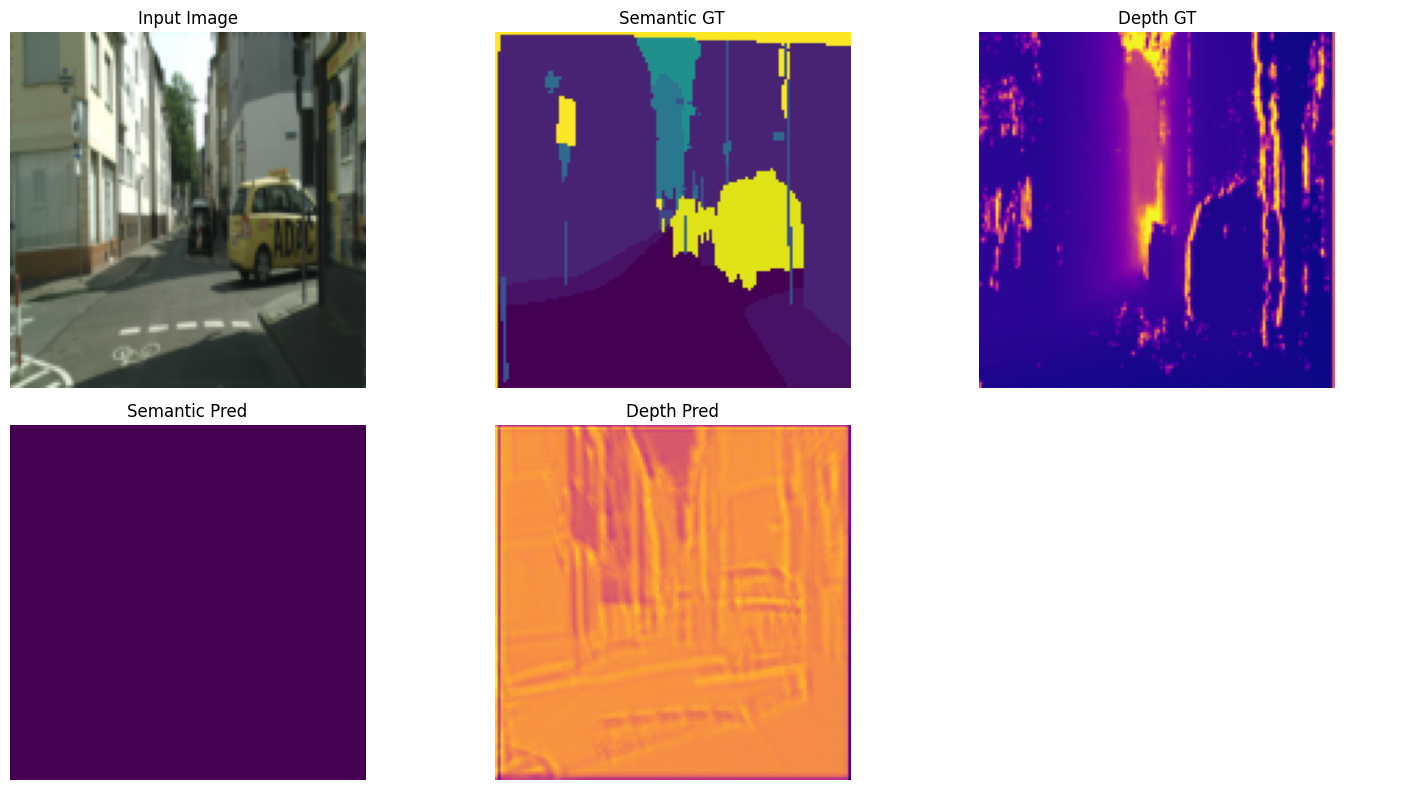

Batch 1: Dice Loss = 0.6416, Depth: RMSE = 79.5892


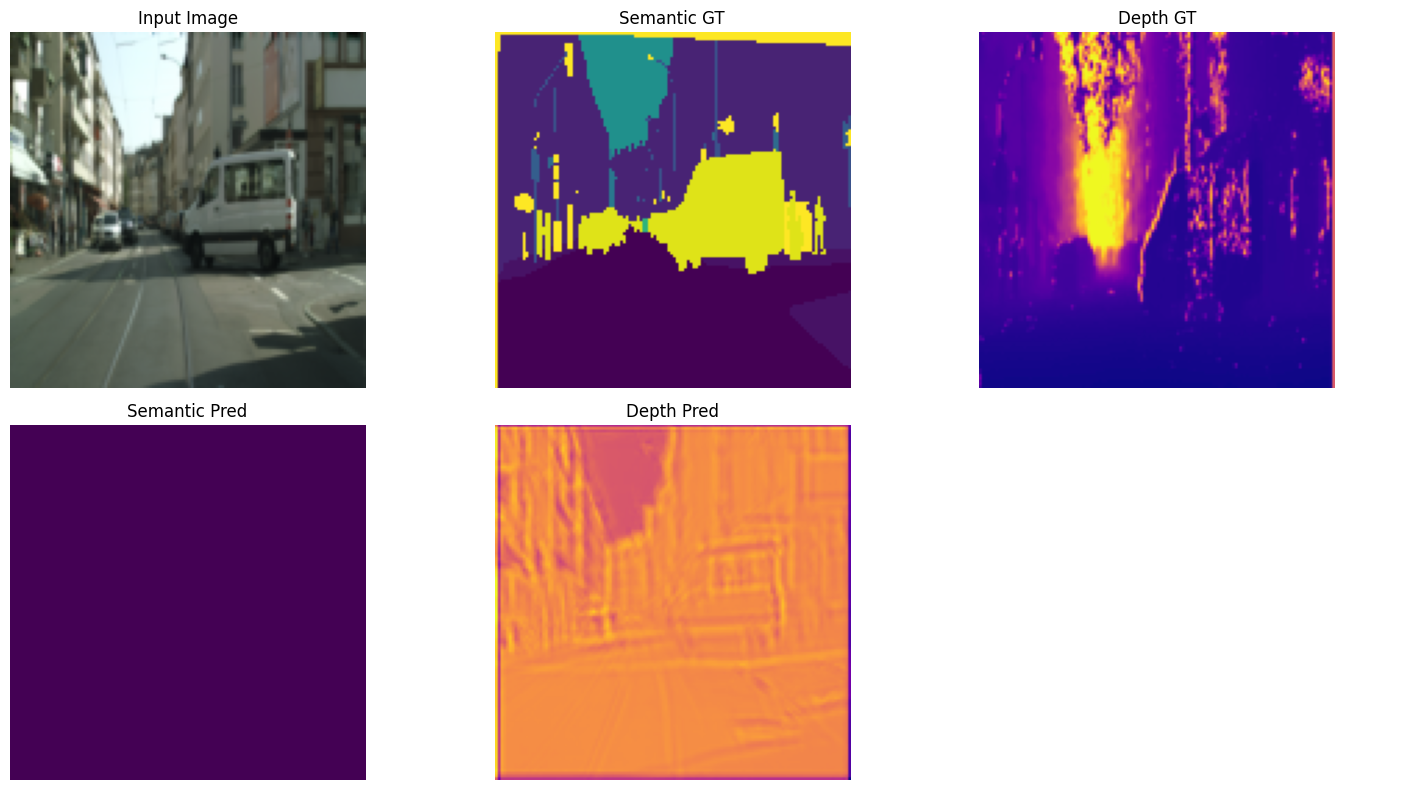

Batch 2: Dice Loss = 0.6879, Depth: RMSE = 88.4260


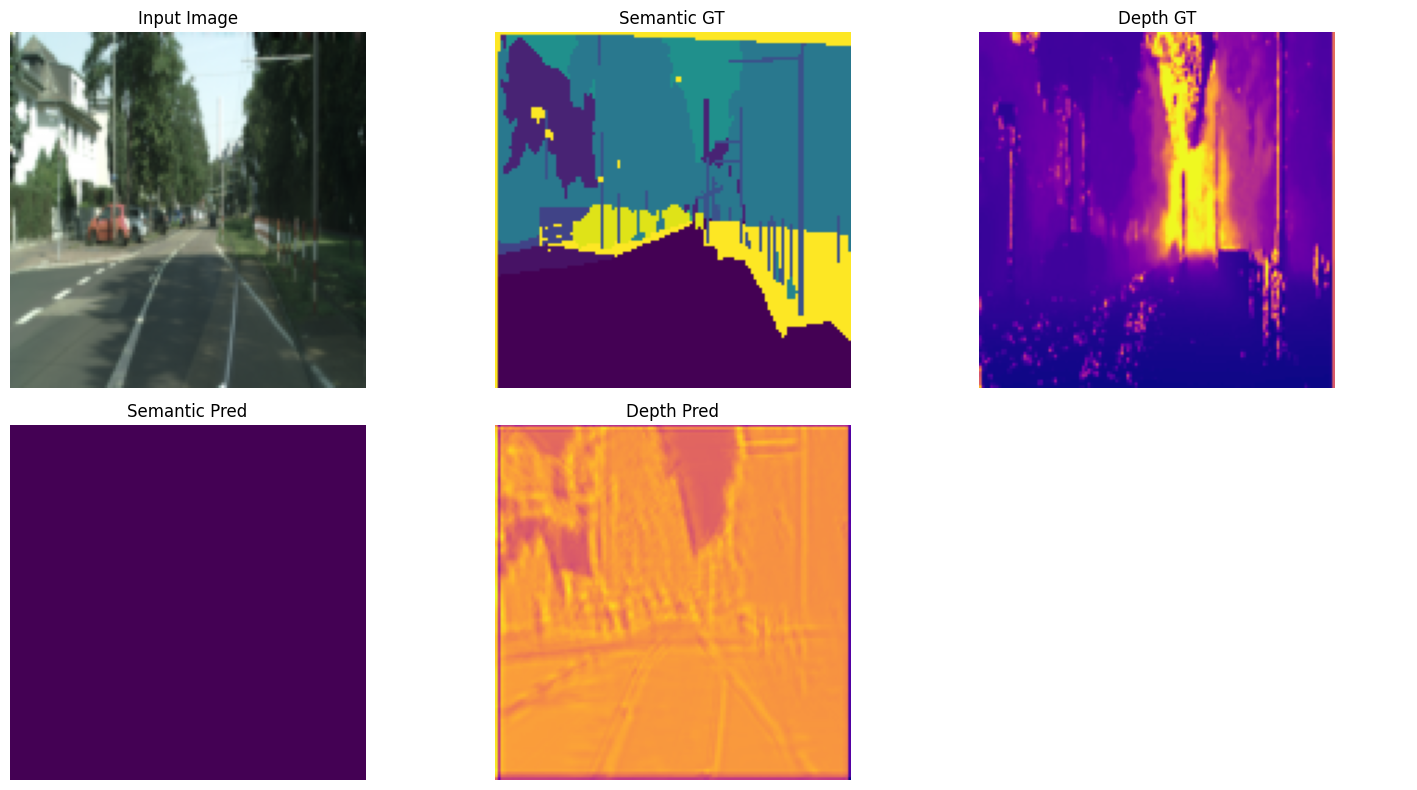

Batch 3: Dice Loss = 0.6401, Depth: RMSE = 117.4243


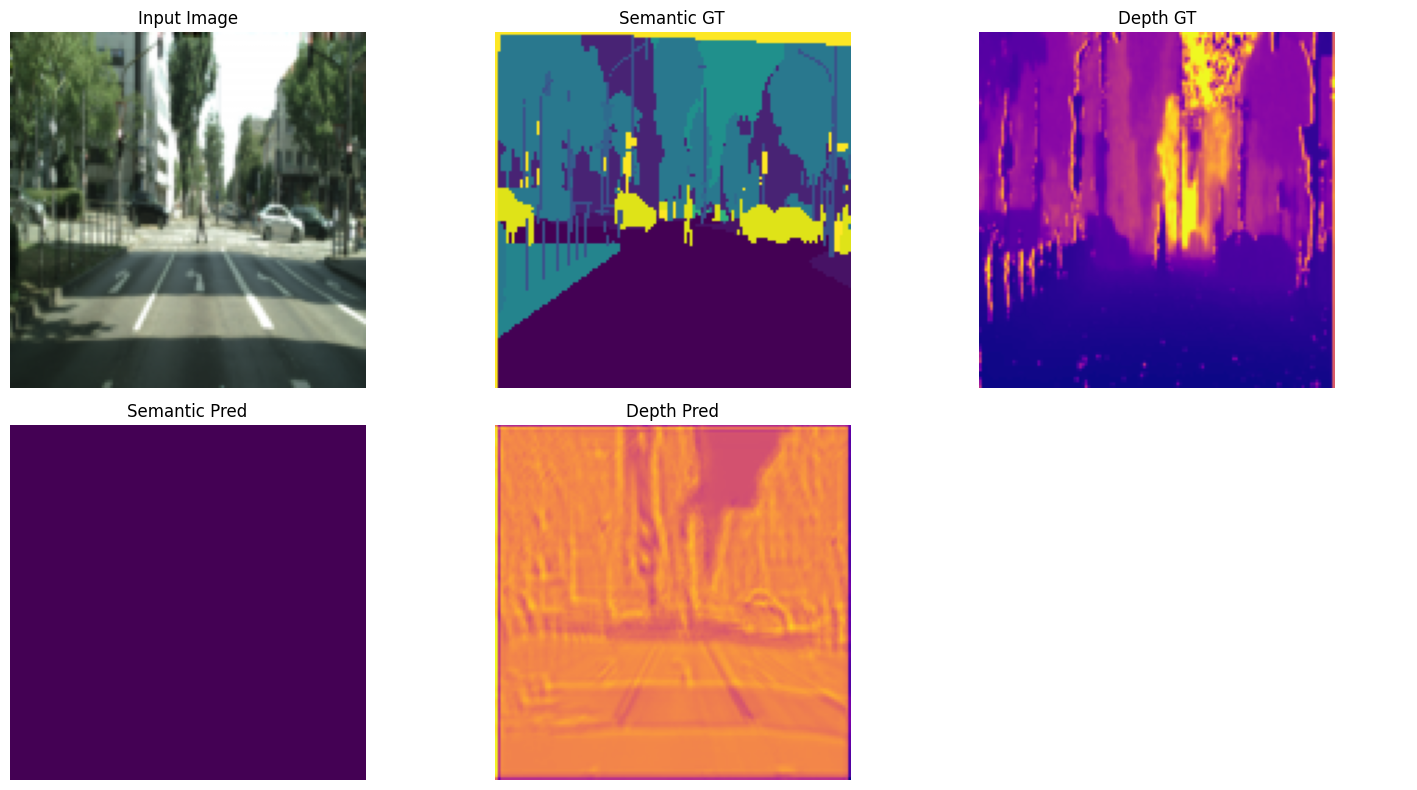

In [115]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def visualize_validation_outputs(val_loader, model, device, num_batches=4, dice_criterion=None, depth_criterion=None):
    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(val_loader):
            images = batch['left'].to(device)
            semantic_gt = batch['mask'].to(device)
            depth_gt = batch['depth'].to(device)

            # Forward pass
            semantic_pred, depth_pred, feats = model(images)

            # Compute Dice and depth loss if criterion provided
            if dice_criterion is not None and depth_criterion is not None:
                dice_loss_val = dice_criterion(semantic_pred, semantic_gt)
                depth_gt_unsq = depth_gt.unsqueeze(1) if depth_pred.dim() == 4 and depth_gt.dim() == 3 else depth_gt
                depth_loss_val = depth_criterion(depth_pred, depth_gt_unsq)
                # sqrt of depth loss
                depth_loss_val = torch.sqrt(depth_loss_val)
                print(f"Batch {i}: Dice Loss = {dice_loss_val.item():.4f}, Depth: RMSE = {depth_loss_val.item():.4f}")

            # Visualization (as before)
            img = images[0].cpu().permute(1, 2, 0).numpy()
            sem_gt = semantic_gt[0].cpu().numpy()
            dep_gt = depth_gt[0, 0].cpu().numpy()
            sem_pred = torch.argmax(semantic_pred[0], dim=0).cpu().numpy()
            dep_pred = depth_pred[0, 0].cpu().numpy()

            fig, axs = plt.subplots(2, 3, figsize=(15, 8))
            axs[0, 0].imshow(np.clip(img, 0, 1))
            axs[0, 0].set_title('Input Image')
            axs[0, 1].imshow(sem_gt)
            axs[0, 1].set_title('Semantic GT')
            axs[0, 2].imshow(dep_gt, cmap='plasma')
            axs[0, 2].set_title('Depth GT')
            axs[1, 0].imshow(sem_pred)
            axs[1, 0].set_title('Semantic Pred')
            axs[1, 1].imshow(dep_pred, cmap='plasma')
            axs[1, 1].set_title('Depth Pred')
            axs[1, 2].axis('off')

            for ax in axs.flat:
                ax.axis('off')

            plt.tight_layout()
            plt.show()

            if i + 1 >= num_batches:
                break

# Usage example (assuming dice_criterion and depth_criterion are defined):
visualize_validation_outputs(valid_loader, model, device, dice_criterion=dice_criterion, depth_criterion=depth_criterion)


torch.Size([3, 108, 256]) torch.Size([103, 256]) torch.Size([1, 108, 256])


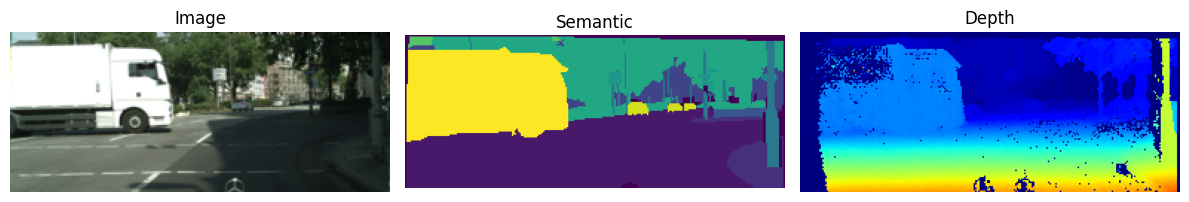

In [103]:
img_dict = test_set.__getitem__(21)
img = img_dict['image'][:, :-20]
sem = img_dict['semantic'][:-25, :]
depth = img_dict['depth'][:, :-20]

print(img.shape, sem.shape, depth.shape)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(img.permute(1, 2, 0))
plt.title('Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(sem)
plt.title('Semantic')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(depth.permute(1, 2, 0), cmap='jet')
plt.title('Depth')
plt.axis('off')

plt.tight_layout()
plt.show()


# STOP EXEC

In [104]:
___ stop execution ___

SyntaxError: invalid syntax (1549794655.py, line 1)

# load Model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
# model = GLPDepthWithSegmentation()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

epochs = 10
# model = train(train_loader, test_loader, model, device, optimizer, scheduler, epochs)

In [ ]:
# torch.save(model.state_dict(), '/kaggle/working/GLPWIthSegFormer_v1.pth')
# print(f"Model saved: /kaggle/working/GLPWIthSegFormer_v1.pth")
# torch.save(model, '/kaggle/working/GLPWithSegFormerModel')
# print(f"Model saved: /kaggle/working/GLPWithSegFormer")

In [ ]:
# import torch
# from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor
# from PIL import Image
# import numpy as np
# import matplotlib.pyplot as plt
# import cv2

# class SegmentationDepthModel(torch.nn.Module):
#     """
#     A wrapper module that loads:
#       - A lightweight semantic segmentation model (DeepLabV3 with a MobileNet V3 backbone)
#       - A lightweight monocular depth estimation model (MiDaS_small)
#     It accepts a PIL image in RGB and returns a dictionary with keys:
#       'segmentation' and 'depth'
#     """
#     def __init__(self, device="cuda" if torch.cuda.is_available() else "cpu"):
#         super().__init__()
#         self.device = device

#         # -------------------------------
#         # Load Semantic Segmentation Model
#         # -------------------------------
#         self.seg_processor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
#         self.seg_model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
#         self.seg_model.to(self.device).eval()


#         # -------------------------------
#         # Load Monocular Depth Estimation Model (MiDaS_small)
#         # -------------------------------
#         # Loading the small MiDaS model using torch.hub
#         self.depth_model = torch.hub.load("intel-isl/MiDaS", "MiDaS_small")
#         self.depth_model.to(self.device)
#         self.depth_model.eval()

#         # Load MiDaS transforms (small_transform)
#         midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
#         self.depth_transform = midas_transforms.small_transform

#     def forward(self, img):
#         """
#         Processes an input PIL image and returns both predictions.
        
#         Args:
#             img (PIL.Image): Input image in RGB format.
        
#         Returns:
#             dict: A dictionary with keys:
#                 - 'segmentation': A 2D NumPy array containing the semantic segmentation mask.
#                 - 'depth': A 2D NumPy array representing the estimated depth map.
#         """
#         # Remember the original image size.
#         orig_width, orig_height = img.size

#         # -------------------------------
#         # Semantic Segmentation Path
#         # -------------------------------
#         seg_inputs = self.seg_processor(images=img, return_tensors="pt")
#         seg_inputs = {k: v.to(self.device) for k, v in seg_inputs.items()}
#         with torch.no_grad():
#             seg_output = self.seg_model(**seg_inputs)
#         seg_logits = seg_output.logits  # [1, num_classes, H, W]
#         seg_preds = seg_logits.argmax(dim=1)[0].cpu().numpy()
#         seg_prediction = cv2.resize(seg_preds.astype(np.uint8), (orig_width, orig_height), interpolation=cv2.INTER_NEAREST)

#         # -------------------------------
#         # Monocular Depth Estimation Path
#         # -------------------------------
#         # Convert the PIL image to a NumPy array before passing to the transform.
#         img_np = np.array(img)
#         depth_input = self.depth_transform(img_np).to(self.device)
#         with torch.no_grad():
#             depth_out = self.depth_model(depth_input)  # Shape: [1, 256, 256]
#             depth_out = depth_out.unsqueeze(1)  # Now shape: [1, 1, 256, 256]
#         # Upsample depth output to the original image size
#         print(f"Depth output shape: {depth_out.shape}")
#         print(f"Original image size: {orig_height}, {orig_width}")
#         # Upsample depth output to original size
#         # The depth map is resized to the original image size.
#         depth_out = torch.nn.functional.interpolate(
#             depth_out,
#             size=(orig_height, orig_width),
#             mode="bilinear",
#             align_corners=False
#         )
#         depth_map = depth_out.squeeze().cpu().numpy()

#         return {"segmentation": seg_prediction, "depth": depth_map}


In [ ]:
# device = "cuda" if torch.cuda.is_available() else "cpu"
# model = SegmentationDepthModel(device=device)

In [ ]:
# def visualize_results(images, semantic_output, depth_output):
#     # num_images = len(images)
#     # fig, axes = plt.subplots(num_images, 3, figsize=(15, num_images * 5))
    
#     # for i in range(num_images):
#     #     axes[i, 0].imshow(images[i].cpu().numpy().transpose((1, 2, 0)))
#     #     axes[i, 0].set_title('Original Image')
#     #     axes[i, 0].axis('off')
        
#     #     axes[i, 1].imshow(semantic_output[i].cpu().numpy(), cmap='viridis')
#     #     axes[i, 1].set_title('Semantic Output')
#     #     axes[i, 1].axis('off')
        
#     #     axes[i, 2].imshow(depth_output[i].cpu().numpy(), cmap='viridis')
#     #     axes[i, 2].set_title('Depth Output')
#     #     axes[i, 2].axis('off')
    
#     # plt.tight_layout()
#     # plt.show()
#     plt.figure(figsize=(12, 6))

#     plt.subplot(1, 3, 1)
#     plt.imshow(semantic_output, cmap="inferno")
#     plt.title("Semantic Segmentation")
#     plt.axis("off")

#     plt.subplot(1, 3, 2)
#     plt.imshow(depth_output, cmap="inferno")
#     plt.title("Monocular Depth Estimation")
#     plt.axis("off")

#     plt.subplot(1, 3, 3)
#     plt.imshow(images)
#     plt.title("Original Image")
#     plt.axis("off")

#     plt.tight_layout()
#     plt.show()
    
# import matplotlib.pyplot as plt
# import numpy as np
# import torch

# # === Cityscapes Color Palette Based on Train ID ===
# cityscapes_trainid_to_color = {
#     0:  (128, 64, 128),     # road
#     1:  (244, 35, 232),     # sidewalk
#     2:  (70, 70, 70),       # building
#     3:  (102, 102, 156),    # wall
#     4:  (190, 153, 153),    # fence
#     5:  (153, 153, 153),    # pole
#     6:  (250, 170, 30),     # traffic light
#     7:  (220, 220, 0),      # traffic sign
#     8:  (107, 142, 35),     # vegetation
#     9:  (152, 251, 152),    # terrain
#     10: (70, 130, 180),     # sky
#     11: (220, 20, 60),      # person
#     12: (255, 0, 0),        # rider
#     13: (0, 0, 142),        # car
#     14: (0, 0, 70),         # truck
#     15: (0, 60, 100),       # bus
#     16: (0, 80, 100),       # train
#     17: (0, 0, 230),        # motorcycle
#     18: (119, 11, 32),      # bicycle
#     19: (0, 0, 142),        # license plate (ignoreInEval)
#     20: (0, 0, 0)           # unlabeled / ignored
# }

# # === Function to decode semantic mask ===
# def decode_semantic_mask(sem_mask, palette):
#     """
#     Convert a 2D semantic mask (with train IDs) to a color RGB image.
#     """
#     h, w = sem_mask.shape
#     color_mask = np.zeros((h, w, 3), dtype=np.uint8)
#     for train_id, color in palette.items():
#         color_mask[sem_mask == train_id] = color
#     return color_mask

# # === Modified Visualization Function ===
# def visualize_results1(images, semantic_output, depth_output):
#     num_images = len(images)
#     fig, axes = plt.subplots(num_images, 3, figsize=(15, num_images * 5))

#     for i in range(num_images):
#         # Original image
#         img_np = images[i].cpu().numpy().transpose((1, 2, 0))
#         axes[i, 0].imshow(img_np)
#         axes[i, 0].set_title('Original Image')
#         axes[i, 0].axis('off')
        
#         # Semantic output (Cityscapes palette)
#         sem_np = semantic_output[i].cpu().numpy().astype(np.uint8)
#         sem_rgb = decode_semantic_mask(sem_np, cityscapes_trainid_to_color)
#         axes[i, 1].imshow(sem_rgb)
#         axes[i, 1].set_title('Semantic Label (Cityscapes)')
#         axes[i, 1].axis('off')
        
#         # Depth output
#         depth_np = depth_output[i].cpu().numpy()
#         if depth_np.ndim == 3 and depth_np.shape[0] == 1:
#             depth_np = depth_np.squeeze(0)
#         axes[i, 2].imshow(depth_np, cmap='jet')
#         axes[i, 2].set_title('Depth Label')
#         axes[i, 2].axis('off')

#     plt.tight_layout()
#     plt.show()

# import torchvision.transforms as T
# to_pil = T.ToPILImage()
# with torch.no_grad():
#     for i, batch in enumerate(test_loader):
#         if i < 3:
#             continue
#         images = batch['image'].to(device)
#         semantic = batch['semantic'].long().to(device)
#         depth = batch['depth'].to(device)
        
#         img = to_pil(images[0])
#         output = model(img)
#         semantic_output = output['segmentation']
#         semantic_label = torch.argmax(batch['semantic'], dim=1).squeeze()
#         depth_output = output["depth"]

#         print(images.shape, semantic_output.shape, output['depth'].squeeze().shape)
#         print(images.shape, semantic.shape, depth.shape)
#         # If your semantic_output is a NumPy array of shape (128, 256)
#         # semantic_output = torch.from_numpy(semantic_output)  # Convert to tensor

#         # # Then you can expand the batch dimension
#         # batched_output = semantic_output.unsqueeze(0).repeat(2, 1, 1)

#         visualize_results(img, semantic_output, depth_output)
#         # visualize_results1(images,batched_output , depth.squeeze())
#         break

In [ ]:
def visualize_results(images, semantic_output, depth_output):
    # num_images = len(images)
    # fig, axes = plt.subplots(num_images, 3, figsize=(15, num_images * 5))
    
    # for i in range(num_images):
    #     axes[i, 0].imshow(images[i].cpu().numpy().transpose((1, 2, 0)))
    #     axes[i, 0].set_title('Original Image')
    #     axes[i, 0].axis('off')
        
    #     axes[i, 1].imshow(semantic_output[i].cpu().numpy(), cmap='viridis')
    #     axes[i, 1].set_title('Semantic Output')
    #     axes[i, 1].axis('off')
        
    #     axes[i, 2].imshow(depth_output[i].cpu().numpy(), cmap='viridis')
    #     axes[i, 2].set_title('Depth Output')
    #     axes[i, 2].axis('off')
    
    # plt.tight_layout()
    # plt.show()
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(semantic_output, cmap="inferno")
    plt.title("Semantic Segmentation")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(depth_output, cmap="inferno")
    plt.title("Monocular Depth Estimation")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(images)
    plt.title("Original Image")
    plt.axis("off")

    plt.tight_layout()
    plt.show()
    
import matplotlib.pyplot as plt
import numpy as np
import torch

# === Cityscapes Color Palette Based on Train ID ===
cityscapes_trainid_to_color = {
    0:  (128, 64, 128),     # road
    1:  (244, 35, 232),     # sidewalk
    2:  (70, 70, 70),       # building
    3:  (102, 102, 156),    # wall
    4:  (190, 153, 153),    # fence
    5:  (153, 153, 153),    # pole
    6:  (250, 170, 30),     # traffic light
    7:  (220, 220, 0),      # traffic sign
    8:  (107, 142, 35),     # vegetation
    9:  (152, 251, 152),    # terrain
    10: (70, 130, 180),     # sky
    11: (220, 20, 60),      # person
    12: (255, 0, 0),        # rider
    13: (0, 0, 142),        # car
    14: (0, 0, 70),         # truck
    15: (0, 60, 100),       # bus
    16: (0, 80, 100),       # train
    17: (0, 0, 230),        # motorcycle
    18: (119, 11, 32),      # bicycle
    19: (0, 0, 142),        # license plate (ignoreInEval)
    20: (0, 0, 0)           # unlabeled / ignored
}

# === Function to decode semantic mask ===
def decode_semantic_mask(sem_mask, palette):
    """
    Convert a 2D semantic mask (with train IDs) to a color RGB image.
    """
    h, w = sem_mask.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for train_id, color in palette.items():
        color_mask[sem_mask == train_id] = color
    return color_mask

# === Modified Visualization Function ===
def visualize_results1(images, semantic_output, depth_output):
    num_images = len(images)
    fig, axes = plt.subplots(num_images, 3, figsize=(15, num_images * 5))

    for i in range(num_images):
        # Original image
        img_np = images[i].cpu().numpy().transpose((1, 2, 0))
        axes[i, 0].imshow(img_np)
        axes[i, 0].set_title('Original Image')
        axes[i, 0].axis('off')
        
        # Semantic output (Cityscapes palette)
        sem_np = semantic_output[i].cpu().numpy().astype(np.uint8)
        sem_rgb = decode_semantic_mask(sem_np, cityscapes_trainid_to_color)
        axes[i, 1].imshow(sem_rgb)
        axes[i, 1].set_title('Semantic Label (Cityscapes)')
        axes[i, 1].axis('off')
        
        # Depth output
        depth_np = depth_output[i].cpu().numpy()
        if depth_np.ndim == 3 and depth_np.shape[0] == 1:
            depth_np = depth_np.squeeze(0)
        axes[i, 2].imshow(depth_np, cmap='jet')
        axes[i, 2].set_title('Depth Label')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

import torchvision.transforms as T
to_pil = T.ToPILImage()
with torch.no_grad():
    # for i, batch in enumerate(test_loader):
    # if i < 3:
    #     continue
    # images = batch['image'].to(device)
    # semantic = batch['semantic'].long().to(device)
    # depth = batch['depth'].to(device)
    images =["dataset/foggy_data/Dense_Fog/010.png"]
    img = Image.open(images[0]).convert("RGB")
    output = model(img)
    semantic_output = output['segmentation']
    semantic_label = torch.argmax(batch['semantic'], dim=1).squeeze()
    depth_output = output["depth"]

    # print(images.shape, semantic_output.shape, output['depth'].squeeze().shape)
    # print(images.shape, semantic.shape, depth.shape)
    # If your semantic_output is a NumPy array of shape (128, 256)
    # semantic_output = torch.from_numpy(semantic_output)  # Convert to tensor

    # # Then you can expand the batch dimension
    # batched_output = semantic_output.unsqueeze(0).repeat(2, 1, 1)

    visualize_results(img, semantic_output, depth_output)
    # visualize_results1(images,batched_output , depth.squeeze())
    # break

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# === Cityscapes Color Palette Based on Train ID ===
cityscapes_trainid_to_color = {
    0:  (128, 64, 128),     # road
    1:  (244, 35, 232),     # sidewalk
    2:  (70, 70, 70),       # building
    3:  (102, 102, 156),    # wall
    4:  (190, 153, 153),    # fence
    5:  (153, 153, 153),    # pole
    6:  (250, 170, 30),     # traffic light
    7:  (220, 220, 0),      # traffic sign
    8:  (107, 142, 35),     # vegetation
    9:  (152, 251, 152),    # terrain
    10: (70, 130, 180),     # sky
    11: (220, 20, 60),      # person
    12: (255, 0, 0),        # rider
    13: (0, 0, 142),        # car
    14: (0, 0, 70),         # truck
    15: (0, 60, 100),       # bus
    16: (0, 80, 100),       # train
    17: (0, 0, 230),        # motorcycle
    18: (119, 11, 32),      # bicycle
    19: (0, 0, 142),        # license plate (ignoreInEval)
    20: (0, 0, 0)           # unlabeled / ignored
}

# === Function to map semantic mask to RGB image ===
def decode_semantic_mask(sem_mask, palette):
    """
    Convert a 2D semantic mask (with train IDs) to a color RGB image.
    """
    h, w = sem_mask.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for train_id, color in palette.items():
        color_mask[sem_mask == train_id] = color
    return color_mask

# === Load and crop sample ===
img_dict = test_set.__getitem__(21)
img = img_dict['image'][:, :-20]
sem = img_dict['semantic'][:-25, :]
depth = img_dict['depth'][:, :-20]

print("Shapes:", img.shape, sem.shape, depth.shape)

# === Decode semantic mask ===
sem_np = sem.numpy() if isinstance(sem, torch.Tensor) else sem
sem_rgb = decode_semantic_mask(sem_np, cityscapes_trainid_to_color)

# === Visualization ===
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title('Image')
plt.imshow(img.permute(1, 2, 0))
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Semantic (Cityscapes Palette)')
plt.imshow(sem_rgb)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Depth')
plt.imshow(depth.permute(1, 2, 0), cmap='jet')
plt.axis('off')

plt.tight_layout()
plt.show()


## RevisedLayerNorm

In [ ]:
class RevisedLayerNorm(nn.Module):
    """Revised LayerNorm"""
    def __init__(self, embed_dim, epsilon=1e-5, detach_gradient=False):
        super(RevisedLayerNorm, self).__init__()
        self.epsilon = epsilon
        self.detach_gradient = detach_gradient

        self.scale = nn.Parameter(torch.ones((1, embed_dim, 1, 1)))
        self.shift = nn.Parameter(torch.zeros((1, embed_dim, 1, 1)))

        self.scale_mlp = nn.Conv2d(1, embed_dim, 1)
        self.shift_mlp = nn.Conv2d(1, embed_dim, 1)

        trunc_normal_(self.scale_mlp.weight, std=.02)
        nn.init.constant_(self.scale_mlp.bias, 1)

        trunc_normal_(self.shift_mlp.weight, std=.02)
        nn.init.constant_(self.shift_mlp.bias, 0)

    def forward(self, input_tensor):
        mean_value = torch.mean(input_tensor, dim=(1, 2, 3), keepdim=True)
        std_value = torch.sqrt((input_tensor - mean_value).pow(2).mean(dim=(1, 2, 3), keepdim=True) + self.epsilon)

        normalized_tensor = (input_tensor - mean_value) / std_value

        if self.detach_gradient:
            rescale, rebias = self.scale_mlp(std_value.detach()), self.shift_mlp(mean_value.detach())
        else:
            rescale, rebias = self.scale_mlp(std_value), self.shift_mlp(mean_value)

        output = normalized_tensor * self.scale + self.shift
        return output, rescale, rebias



In [ ]:
class MultiLayerPerceptron(nn.Module):
    def __init__(self, depth, input_channels, hidden_channels=None, output_channels=None):
        super().__init__()
        output_channels = output_channels or input_channels
        hidden_channels = hidden_channels or input_channels

        self.depth = depth

        self.mlp_layers = nn.Sequential(
            nn.Conv2d(input_channels, hidden_channels, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_channels, output_channels, kernel_size=1)
        )

        self.apply(self._initialize_weights)

    def _initialize_weights(self, layer):
        if isinstance(layer, nn.Conv2d):
            gain = (8 * self.depth) ** (-1 / 4)
            fan_in, fan_out = torch.nn.init._calculate_fan_in_and_fan_out(layer.weight)
            std = gain * math.sqrt(2.0 / float(fan_in + fan_out))
            trunc_normal_(layer.weight, std=std)
            if layer.bias is not None:
                nn.init.constant_(layer.bias, 0)

    def forward(self, x):
        return self.mlp_layers(x)


def partition_into_windows(tensor, window_size):
    """Splits the input tensor into non-overlapping windows."""
    batch_size, height, width, channels = tensor.shape
    assert height % window_size == 0 and width % window_size == 0, "Height and width must be divisible by window_size"

    tensor = tensor.view(
        batch_size, height // window_size, window_size, width // window_size, window_size, channels
    )
    windows = tensor.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size**2, channels)
    return windows


def merge_windows(windows, window_size, height, width):
    """Reconstructs the original tensor from partitioned windows."""
    batch_size = windows.shape[0] // ((height * width) // (window_size**2))
    tensor = windows.view(
        batch_size, height // window_size, width // window_size, window_size, window_size, -1
    )
    tensor = tensor.permute(0, 1, 3, 2, 4, 5).contiguous().view(batch_size, height, width, -1)
    return tensor


### test

In [ ]:
import torch

# Initialize the MultiLayerPerceptron with sample parameters
depth = 4
input_channels = 64
hidden_channels = 128
output_channels = 64

mlp = MultiLayerPerceptron(depth, input_channels, hidden_channels, output_channels)

# Create a random tensor to test MLP (batch_size=2, channels=64, height=16, width=16)
input_tensor = torch.randn(2, 64, 16, 16)
output_tensor = mlp(input_tensor)

# Check output shape
mlp_output_shape = output_tensor.shape

# Test window partition and merging
batch_size, height, width, channels = 2, 16, 16, 64
window_size = 4

# Create a random tensor for window functions (B, H, W, C) format
input_window_tensor = torch.randn(batch_size, height, width, channels)

# Apply partitioning and merging
windows = partition_into_windows(input_window_tensor, window_size)
reconstructed_tensor = merge_windows(windows, window_size, height, width)

# Check shapes
windows_shape = windows.shape
reconstructed_shape = reconstructed_tensor.shape

# Validate if the reconstruction matches the original input shape
is_shape_correct = reconstructed_shape == input_window_tensor.shape

# Output results
mlp_output_shape, windows_shape, reconstructed_shape, is_shape_correct


In [ ]:
class LocalWindowAttention(nn.Module):
    def __init__(self, embed_dim, window_size, num_heads):
        """Self-attention mechanism within local windows."""
        super().__init__()
        self.embed_dim = embed_dim
        self.window_size = window_size  # (height, width)
        self.num_heads = num_heads
        head_dim = embed_dim // num_heads
        self.scaling_factor = head_dim ** -0.5  # Scaled dot-product attention

        # Compute and store relative positional encodings
        relative_positional_encodings = compute_log_relative_positions(self.window_size)
        self.register_buffer("relative_positional_encodings", relative_positional_encodings)

        # Learnable transformation of relative position embeddings
        self.relative_mlp = nn.Sequential(
            nn.Linear(2, 256, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_heads, bias=True)
        )

        self.attention_softmax = nn.Softmax(dim=-1)

    def forward(self, qkv):
        """Computes attention scores and applies self-attention within a window."""
        batch_size, num_tokens, _ = qkv.shape

        # Reshape qkv into separate query, key, and value tensors
        qkv = qkv.reshape(batch_size, num_tokens, 3, self.num_heads, self.embed_dim // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # Unpacking query, key, and value

        # Scale query for stable attention computation
        q = q * self.scaling_factor
        attention_scores = q @ k.transpose(-2, -1)

        # Compute relative position bias
        relative_bias = self.relative_mlp(self.relative_positional_encodings)
        relative_bias = relative_bias.permute(2, 0, 1).contiguous()  # Shape: (num_heads, window_size², window_size²)
        attention_scores = attention_scores + relative_bias.unsqueeze(0)

        # Apply softmax and compute weighted values
        attention_weights = self.attention_softmax(attention_scores)
        output = (attention_weights @ v).transpose(1, 2).reshape(batch_size, num_tokens, self.embed_dim)

        return output

In [ ]:
def compute_log_relative_positions(window_size):
    """Computes log-scaled relative position embeddings for a given window size."""
    coord_range = torch.arange(window_size)

    # Create coordinate grid
    coord_grid = torch.stack(torch.meshgrid([coord_range, coord_range]))  # Shape: (2, window_size, window_size)
    
    # Flatten coordinates
    flattened_coords = torch.flatten(coord_grid, 1)  # Shape: (2, window_size * window_size)

    # Compute relative positions
    relative_positions = flattened_coords[:, :, None] - flattened_coords[:, None, :]  # Shape: (2, window_size^2, window_size^2)

    # Format and apply log transformation
    relative_positions = relative_positions.permute(1, 2, 0).contiguous()  # Shape: (window_size^2, window_size^2, 2)
    log_relative_positions = torch.sign(relative_positions) * torch.log(1. + relative_positions.abs())

    return log_relative_positions


In [ ]:
class AdaptiveAttention(nn.Module):
    def __init__(self, network_depth, embed_dim, num_heads, window_size, shift_size, enable_attention=False, conv_mode=None):
        """Hybrid attention-convolution module with optional window-based attention."""
        super().__init__()
        self.embed_dim = embed_dim
        self.head_dim = embed_dim // num_heads
        self.num_heads = num_heads

        self.window_size = window_size
        self.shift_size = shift_size

        self.network_depth = network_depth
        self.enable_attention = enable_attention
        self.conv_mode = conv_mode

        # Define convolutional processing based on mode
        if self.conv_mode == 'Conv':
            self.conv_layer = nn.Sequential(
                nn.Conv2d(embed_dim, embed_dim, kernel_size=3, padding=1, padding_mode='reflect'),
                nn.ReLU(inplace=True),
                nn.Conv2d(embed_dim, embed_dim, kernel_size=3, padding=1, padding_mode='reflect')
            )

        if self.conv_mode == 'DWConv':
            self.conv_layer = nn.Conv2d(embed_dim, embed_dim, kernel_size=5, padding=2, groups=embed_dim, padding_mode='reflect')

        if self.conv_mode == 'DWConv' or self.enable_attention:
            self.value_projection = nn.Conv2d(embed_dim, embed_dim, 1)
            self.output_projection = nn.Conv2d(embed_dim, embed_dim, 1)

        if self.enable_attention:
            self.query_key_projection = nn.Conv2d(embed_dim, embed_dim * 2, 1)
            self.window_attention = LocalWindowAttention(embed_dim, window_size, num_heads)

        self.apply(self._initialize_weights)

    def _initialize_weights(self, module):
        """Custom weight initialization."""
        if isinstance(module, nn.Conv2d):
            weight_shape = module.weight.shape

            if weight_shape[0] == self.embed_dim * 2:  # Query-Key projection
                fan_in, fan_out = _calculate_fan_in_and_fan_out(module.weight)
                std = math.sqrt(2.0 / float(fan_in + fan_out))
                trunc_normal_(module.weight, std=std)
            else:
                gain = (8 * self.network_depth) ** (-1/4)
                fan_in, fan_out = _calculate_fan_in_and_fan_out(module.weight)
                std = gain * math.sqrt(2.0 / float(fan_in + fan_out))
                trunc_normal_(module.weight, std=std)

            if module.bias is not None:
                nn.init.constant_(module.bias, 0)

    def pad_for_window_processing(self, x, shift=False):
        """Pads the input tensor to fit window processing requirements."""
        _, _, height, width = x.size()
        pad_h = (self.window_size - height % self.window_size) % self.window_size
        pad_w = (self.window_size - width % self.window_size) % self.window_size

        if shift:
            x = F.pad(x, (self.shift_size, (self.window_size - self.shift_size + pad_w) % self.window_size,
                          self.shift_size, (self.window_size - self.shift_size + pad_h) % self.window_size), mode='reflect')
        else:
            x = F.pad(x, (0, pad_w, 0, pad_h), 'reflect')
        return x

    def forward(self, x):
        """Computes the output with optional attention and convolution."""
        batch_size, channels, height, width = x.shape

        if self.conv_mode == 'DWConv' or self.enable_attention:
            v_proj = self.value_projection(x)

        if self.enable_attention:
            qk_proj = self.query_key_projection(x)
            qkv = torch.cat([qk_proj, v_proj], dim=1)

            # Apply padding for shifted window processing
            padded_qkv = self.pad_for_window_processing(qkv, self.shift_size > 0)
            padded_height, padded_width = padded_qkv.shape[2:]

            # Partition into windows
            padded_qkv = padded_qkv.permute(0, 2, 3, 1)
            qkv_windows = partition_into_windows(padded_qkv, self.window_size)  # (num_windows * batch, window_size², channels)

            # Apply window-based attention
            attn_windows = self.window_attention(qkv_windows)

            # Merge back to original spatial dimensions
            merged_output = merge_windows(attn_windows, self.window_size, padded_height, padded_width)

            # Reverse the cyclic shift
            attn_output = merged_output[:, self.shift_size:(self.shift_size + height), self.shift_size:(self.shift_size + width), :]
            attn_output = attn_output.permute(0, 3, 1, 2)

            if self.conv_mode in ['Conv', 'DWConv']:
                conv_output = self.conv_layer(v_proj)
                output = self.output_projection(conv_output + attn_output)
            else:
                output = self.output_projection(attn_output)

        else:
            if self.conv_mode == 'Conv':
                output = self.conv_layer(x)  # No attention, using convolution only
            elif self.conv_mode == 'DWConv':
                output = self.output_projection(self.conv_layer(v_proj))

        return output

In [ ]:
class VisionTransformerBlock(nn.Module):
    def __init__(self, network_depth, embed_dim, num_heads, mlp_ratio=4.0,
                 norm_layer=nn.LayerNorm, enable_mlp_norm=False,
                 window_size=8, shift_size=0, enable_attention=True, conv_mode=None):
        """
        A transformer block that includes attention (optional) and MLP layers.
        """
        super().__init__()
        self.enable_attention = enable_attention
        self.enable_mlp_norm = enable_mlp_norm

        self.pre_norm = norm_layer(embed_dim) if enable_attention else nn.Identity()
        self.attention_layer = AdaptiveAttention(
            network_depth, embed_dim, num_heads=num_heads, window_size=window_size,
            shift_size=shift_size, enable_attention=enable_attention, conv_mode=conv_mode
        )

        self.post_norm = norm_layer(embed_dim) if enable_attention and enable_mlp_norm else nn.Identity()
        self.mlp_layer = MultiLayerPerceptron(network_depth, embed_dim, hidden_channels=int(embed_dim * mlp_ratio))

    def forward(self, x):
        """
        Forward pass through the transformer block.
        """
        residual = x
        if self.enable_attention:
            x, rescale, rebias = self.pre_norm(x)
        x = self.attention_layer(x)
        if self.enable_attention:
            x = x * rescale + rebias
        x = residual + x  # Residual connection

        residual = x
        if self.enable_attention and self.enable_mlp_norm:
            x, rescale, rebias = self.post_norm(x)
        x = self.mlp_layer(x)
        if self.enable_attention and self.enable_mlp_norm:
            x = x * rescale + rebias
        x = residual + x  # Residual connection

        return x


class TransformerStage(nn.Module):
    def __init__(self, network_depth, embed_dim, num_layers, num_heads, mlp_ratio=4.0,
                 norm_layer=nn.LayerNorm, window_size=8,
                 attention_ratio=0.0, attention_placement='last', conv_mode=None):
        """
        A stage of transformer blocks with configurable attention placement.
        """
        super().__init__()
        self.embed_dim = embed_dim
        self.num_layers = num_layers

        attention_layers = int(attention_ratio * num_layers)

        if attention_placement == 'last':
            enable_attentions = [i >= num_layers - attention_layers for i in range(num_layers)]
        elif attention_placement == 'first':
            enable_attentions = [i < attention_layers for i in range(num_layers)]
        elif attention_placement == 'middle':
            enable_attentions = [
                (i >= (num_layers - attention_layers) // 2) and (i < (num_layers + attention_layers) // 2)
                for i in range(num_layers)
            ]

        # Build transformer blocks
        self.blocks = nn.ModuleList([
            VisionTransformerBlock(
                network_depth=network_depth,
                embed_dim=embed_dim,
                num_heads=num_heads,
                mlp_ratio=mlp_ratio,
                norm_layer=norm_layer,
                window_size=window_size,
                shift_size=0 if (i % 2 == 0) else window_size // 2,
                enable_attention=enable_attentions[i],
                conv_mode=conv_mode
            ) for i in range(num_layers)
        ])

    def forward(self, x):
        """
        Forward pass through the transformer stage.
        """
        for block in self.blocks:
            x = block(x)
        return x


In [ ]:
class PatchEmbedding(nn.Module):
    def __init__(self, patch_size=4, input_channels=3, embedding_dim=96, kernel_size=None):
        """
        Patch embedding module that projects input images into token embeddings.
        """
        super().__init__()
        self.input_channels = input_channels
        self.embedding_dim = embedding_dim

        if kernel_size is None:
            kernel_size = patch_size

        self.projection = nn.Conv2d(
            input_channels, embedding_dim, kernel_size=kernel_size, stride=patch_size,
            padding=(kernel_size - patch_size + 1) // 2, padding_mode='reflect'
        )

    def forward(self, x):
        """
        Forward pass to generate patch embeddings.
        """
        return self.projection(x)


class PatchReconstruction(nn.Module):
    def __init__(self, patch_size=4, output_channels=3, embedding_dim=96, kernel_size=None):
        """
        Patch reconstruction module that converts token embeddings back to image patches.
        """
        super().__init__()
        self.output_channels = output_channels
        self.embedding_dim = embedding_dim

        if kernel_size is None:
            kernel_size = 1

        self.projection = nn.Sequential(
            nn.Conv2d(
                embedding_dim, output_channels * patch_size ** 2, kernel_size=kernel_size,
                padding=kernel_size // 2, padding_mode='reflect'
            ),
            nn.PixelShuffle(patch_size)
        )

    def forward(self, x):
        """
        Forward pass to reconstruct image from embeddings.
        """
        return self.projection(x)


In [ ]:
class SelectiveKernelFusion(nn.Module):
    def __init__(self, channels, num_branches=2, reduction_ratio=8):
        """
        Selective Kernel Fusion (SKFusion) module for adaptive feature selection.

        Args:
            channels (int): Number of input channels.
            num_branches (int): Number of feature branches to fuse.
            reduction_ratio (int): Reduction ratio for the attention mechanism.
        """
        super().__init__()
        
        self.num_branches = num_branches
        reduced_channels = max(int(channels / reduction_ratio), 4)
        
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.channel_attention = nn.Sequential(
            nn.Conv2d(channels, reduced_channels, kernel_size=1, bias=False), 
            nn.ReLU(),
            nn.Conv2d(reduced_channels, channels * num_branches, kernel_size=1, bias=False)
        )
        
        self.softmax = nn.Softmax(dim=1)

    def forward(self, feature_maps):
        """
        Forward pass for selective kernel fusion.

        Args:
            feature_maps (list of tensors): A list of feature maps to be fused.

        Returns:
            torch.Tensor: The adaptively fused feature map.
        """
        batch_size, channels, height, width = feature_maps[0].shape
        
        # Concatenate feature maps along a new dimension (num_branches)
        stacked_features = torch.cat(feature_maps, dim=1).view(batch_size, self.num_branches, channels, height, width)
        
        # Compute attention weights
        aggregated_features = torch.sum(stacked_features, dim=1)
        attention_weights = self.channel_attention(self.global_avg_pool(aggregated_features))
        attention_weights = self.softmax(attention_weights.view(batch_size, self.num_branches, channels, 1, 1))

        # Weighted sum of input feature maps
        fused_output = torch.sum(stacked_features * attention_weights, dim=1)
        return fused_output


In [ ]:
class DehazingTransformer(nn.Module):
    def __init__(self, input_channels=3, output_channels=4, window_size=8,
                 embed_dims=[24, 48, 96, 48, 24],
                 mlp_ratios=[2., 4., 4., 2., 2.],
                 layer_depths=[16, 16, 16, 8, 8],
                 num_heads=[2, 4, 6, 1, 1],
                 attention_ratios=[1/4, 1/2, 3/4, 0, 0],
                 conv_types=['DWConv', 'DWConv', 'DWConv', 'DWConv', 'DWConv'],
                 norm_layers=[RevisedLayerNorm, RevisedLayerNorm, RevisedLayerNorm, RevisedLayerNorm, RevisedLayerNorm]):
        super().__init__()

        # Patch embedding settings
        self.patch_size = 4
        self.window_size = window_size

        # Initial patch embedding
        self.patch_embed = PatchEmbedding(
            patch_size=1, input_channels=input_channels, embedding_dim=embed_dims[0], kernel_size=3)

        # Backbone layers
        self.encoder_stage1 = TransformerStage(
            network_depth=sum(layer_depths),
            embed_dim=embed_dims[0],
            num_layers=layer_depths[0],
            num_heads=num_heads[0],
            mlp_ratio=mlp_ratios[0],
            norm_layer=norm_layers[0],
            window_size=window_size,
            attention_ratio=attention_ratios[0],
            attention_placement='last',
            conv_mode=conv_types[0]
        )
        
        self.downsample1 = PatchEmbedding(
            patch_size=2, input_channels=embed_dims[0], embedding_dim=embed_dims[1]
        )
        
        self.skip_connection1 = nn.Conv2d(embed_dims[0], embed_dims[0], 1)
        
        self.encoder_stage2 = TransformerStage(
            network_depth=sum(layer_depths),
            embed_dim=embed_dims[1],
            num_layers=layer_depths[1],
            num_heads=num_heads[1],
            mlp_ratio=mlp_ratios[1],
            norm_layer=norm_layers[1],
            window_size=window_size,
            attention_ratio=attention_ratios[1],
            attention_placement='last',
            conv_mode=conv_types[1]
        )
        
        self.downsample2 = PatchEmbedding(
            patch_size=2, input_channels=embed_dims[1], embedding_dim=embed_dims[2]
        )
        
        self.skip_connection2 = nn.Conv2d(embed_dims[1], embed_dims[1], 1)
        
        self.encoder_stage3 = TransformerStage(
            network_depth=sum(layer_depths),
            embed_dim=embed_dims[2],
            num_layers=layer_depths[2],
            num_heads=num_heads[2],
            mlp_ratio=mlp_ratios[2],
            norm_layer=norm_layers[2],
            window_size=window_size,
            attention_ratio=attention_ratios[2],
            attention_placement='last',
            conv_mode=conv_types[2]
        )
        
        self.upsample1 = PatchReconstruction(
            patch_size=2, output_channels=embed_dims[3], embedding_dim=embed_dims[2]
        )
        
        assert embed_dims[1] == embed_dims[3]
        self.fusion_layer1 = SelectiveKernelFusion(embed_dims[3])
        
        self.decoder_stage1 = TransformerStage(
            network_depth=sum(layer_depths),
            embed_dim=embed_dims[3],
            num_layers=layer_depths[3],
            num_heads=num_heads[3],
            mlp_ratio=mlp_ratios[3],
            norm_layer=norm_layers[3],
            window_size=window_size,
            attention_ratio=attention_ratios[3],
            attention_placement='last',
            conv_mode=conv_types[3]
        )
        
        self.upsample2 = PatchReconstruction(
            patch_size=2, output_channels=embed_dims[4], embedding_dim=embed_dims[3]
        )
        
        assert embed_dims[0] == embed_dims[4]
        self.fusion_layer2 = SelectiveKernelFusion(embed_dims[4])
        
        self.decoder_stage2 = TransformerStage(
            network_depth=sum(layer_depths),
            embed_dim=embed_dims[4],
            num_layers=layer_depths[4],
            num_heads=num_heads[4],
            mlp_ratio=mlp_ratios[4],
            norm_layer=norm_layers[4],
            window_size=window_size,
            attention_ratio=attention_ratios[4],
            attention_placement='last',
            conv_mode=conv_types[4]
        )

        # Final patch reconstruction
        self.patch_reconstruction = PatchReconstruction(
            patch_size=1, output_channels=output_channels, embedding_dim=embed_dims[4], kernel_size=3)

    def adjust_image_size(self, x):
        # Ensures the input image size is compatible with the patch size
        _, _, height, width = x.size()
        pad_height = (self.patch_size - height % self.patch_size) % self.patch_size
        pad_width = (self.patch_size - width % self.patch_size) % self.patch_size
        x = F.pad(x, (0, pad_width, 0, pad_height), 'reflect')
        return x

    def extract_features(self, x):
        x = self.patch_embed(x)
        x = self.encoder_stage1(x)
        skip1 = x

        x = self.downsample1(x)
        x = self.encoder_stage2(x)
        skip2 = x

        x = self.downsample2(x)
        x = self.encoder_stage3(x)
        x = self.upsample1(x)

        x = self.fusion_layer1([x, self.skip_connection2(skip2)]) + x
        x = self.decoder_stage1(x)
        x = self.upsample2(x)

        x = self.fusion_layer2([x, self.skip_connection1(skip1)]) + x
        x = self.decoder_stage2(x)
        x = self.patch_reconstruction(x)
        return x

    def forward(self, x):
        original_height, original_width = x.shape[2:]
        x = self.adjust_image_size(x)

        features = self.extract_features(x)
        transmission_map, atmospheric_light = torch.split(features, (1, 3), dim=1)

        # Dehazing formula: I = J * t + A * (1 - t)
        x = transmission_map * x - atmospheric_light + x
        x = x[:, :, :original_height, :original_width]
        return x

In [ ]:
def build_dehazing_transformer():
    return DehazingTransformer(
        embed_dims=[24, 48, 96, 48, 24],
        mlp_ratios=[2., 4., 4., 2., 2.],
        layer_depths=[12, 12, 12, 6, 6],
        num_heads=[2, 4, 6, 1, 1],
        attention_ratios=[1/4, 1/2, 3/4, 0, 0],
        conv_types=['Conv', 'Conv', 'Conv', 'Conv', 'Conv']
    )

In [ ]:
class ConvolutionalGuidedFilter(nn.Module):
    def __init__(self, radius=1, norm_layer=nn.BatchNorm2d, conv_kernel_size: int = 1):
        super(ConvolutionalGuidedFilter, self).__init__()

        self.box_filter = nn.Conv2d(
            3, 3, kernel_size=3, padding=radius, dilation=radius, bias=False, groups=3
        )
        self.conv_a = nn.Sequential(
            nn.Conv2d(
                6,
                32,
                kernel_size=conv_kernel_size,
                padding=conv_kernel_size // 2,
                bias=False,
            ),
            norm_layer(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(
                32,
                32,
                kernel_size=conv_kernel_size,
                padding=conv_kernel_size // 2,
                bias=False,
            ),
            norm_layer(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(
                32,
                3,
                kernel_size=conv_kernel_size,
                padding=conv_kernel_size // 2,
                bias=False,
            ),
        )
        self.box_filter.weight.data[...] = 1.0

    def forward(self, x_low_res, y_low_res, x_high_res):
        _, _, h_lr, w_lr = x_low_res.size()
        _, _, h_hr, w_hr = x_high_res.size()

        N = self.box_filter(x_low_res.data.new().resize_((1, 3, h_lr, w_lr)).fill_(1.0))
        ## mean_x
        mean_x = self.box_filter(x_low_res) / N
        ## mean_y
        mean_y = self.box_filter(y_low_res) / N
        ## cov_xy
        cov_xy = self.box_filter(x_low_res * y_low_res) / N - mean_x * mean_y
        ## var_x
        var_x = self.box_filter(x_low_res * x_low_res) / N - mean_x * mean_x

        ## A
        A = self.conv_a(torch.cat([cov_xy, var_x], dim=1))
        ## b
        b = mean_y - A * mean_x

        ## mean_A; mean_b
        mean_A = F.interpolate(A, (h_hr, w_hr), mode="bilinear", align_corners=True)
        mean_b = F.interpolate(b, (h_hr, w_hr), mode="bilinear", align_corners=True)

        return mean_A * x_high_res + mean_b

In [ ]:
class PixelAttentionLayer(nn.Module):
    def __init__(self, channels):
        super(PixelAttentionLayer, self).__init__()
        self.attention = nn.Sequential(
                nn.Conv2d(channels, channels // 8, kernel_size=1, padding=0, bias=True),
                nn.ReLU(inplace=True),
                nn.Conv2d(channels // 8, 1, kernel_size=1, padding=0, bias=True),
                nn.Sigmoid()
        )
    
    def forward(self, x):
        attention_map = self.attention(x)
        return x * attention_map

class ChannelAttentionLayer(nn.Module):
    def __init__(self, channels):
        super(ChannelAttentionLayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.attention = nn.Sequential(
                nn.Conv2d(channels, channels // 8, kernel_size=1, padding=0, bias=True),
                nn.ReLU(inplace=True),
                nn.Conv2d(channels // 8, channels, kernel_size=1, padding=0, bias=True),
                nn.Sigmoid()
        )

    def forward(self, x):
        pooled = self.avg_pool(x)
        attention_map = self.attention(pooled)
        return x * attention_map


In [ ]:
class SuperResolutionDilationBlock(nn.Module):
    def __init__(self, in_channels, num_dense_layers, growth_rate):
        super(SuperResolutionDilationBlock, self).__init__()

        self.split_channels = in_channels // 4
        kernel_size = 3

        # Dilated convolutions with increasing dilation rates
        self.conv1 = nn.Conv2d(self.split_channels, self.split_channels, kernel_size=kernel_size, padding=1, dilation=1)
        self.conv2 = nn.Conv2d(self.split_channels * 2, self.split_channels, kernel_size=kernel_size, padding=2, dilation=2)
        self.conv3 = nn.Conv2d(self.split_channels * 3, self.split_channels, kernel_size=kernel_size, padding=4, dilation=4)
        self.conv4 = nn.Conv2d(self.split_channels * 4, self.split_channels, kernel_size=kernel_size, padding=8, dilation=8)

        # Attention mechanisms
        self.channel_attention = ChannelAttentionLayer(in_channels)
        self.pixel_attention = PixelAttentionLayer(in_channels)

        # Final 1x1 convolution for feature fusion
        self.conv_1x1 = nn.Conv2d(in_channels, in_channels, kernel_size=1, padding=0)

    def forward(self, x):
        # Split input into 4 equal parts along channel dimension
        split_features = torch.split(x, self.split_channels, dim=1)

        x0 = F.relu(self.conv1(split_features[0]))
        tmp = torch.cat((split_features[1], x0), dim=1)
        x1 = F.relu(self.conv2(tmp))

        tmp = torch.cat((split_features[2], x0, x1), dim=1)
        x2 = F.relu(self.conv3(tmp))

        tmp = torch.cat((split_features[3], x0, x1, x2), dim=1)
        x3 = F.relu(self.conv4(tmp))

        # Concatenate all outputs
        merged_features = torch.cat((x0, x1, x2, x3), dim=1)

        # Apply 1x1 convolution for feature refinement
        out = self.conv_1x1(merged_features)

        # Apply attention mechanisms
        out = self.channel_attention(out)
        out = self.pixel_attention(out)

        # Residual connection
        return out + x

In [ ]:
class AdaptiveInstanceNormalization(nn.Module):
    def __init__(self, num_channels):
        super(AdaptiveInstanceNormalization, self).__init__()

        # Learnable scaling factors
        self.scale_x = nn.Parameter(torch.tensor(1.0))  # Identity scaling
        self.scale_norm = nn.Parameter(torch.tensor(0.0))  # Initially no effect

        # Instance normalization layer with affine transformation enabled
        self.instance_norm = nn.InstanceNorm2d(num_channels, momentum=0.999, eps=0.001, affine=True)

    def forward(self, x):
        normalized_x = self.instance_norm(x)
        return self.scale_x * x + self.scale_norm * normalized_x

In [ ]:
class SelectiveFeatureFusion(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SelectiveFeatureFusion, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)  # Squeeze
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x1, x2):
        fused = x1 + x2  # shape: [B, C, H, W]
        
        # Channel-wise descriptor
        b, c, _, _ = fused.size()
        y = self.avg_pool(fused).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)  # Channel weights
        
        # Reweight original features
        out = x1 * y + x2 * (1 - y)
        return out

In [ ]:
class DeepGuidedNetwork(nn.Module):
    def __init__(self, radius=1):
        super().__init__()

        # Adaptive Normalization for Guided Filtering
        norm = AdaptiveInstanceNormalization
        kernel_size = 3
        depth_rate = 16
        in_channels = 3
        num_dense_layer = 4
        growth_rate = 16

        # Initial convolution layers
        self.conv_in = nn.Conv2d(in_channels, depth_rate, kernel_size=kernel_size, padding=(kernel_size - 1) // 2)
        self.conv_out = nn.Conv2d(depth_rate, in_channels, kernel_size=kernel_size, padding=(kernel_size - 1) // 2)

        # Residual Dense Blocks (RDBs)
        self.rdb1 = SuperResolutionDilationBlock(depth_rate, num_dense_layer, growth_rate)
        self.rdb2 = SuperResolutionDilationBlock(depth_rate, num_dense_layer, growth_rate)
        self.rdb3 = SuperResolutionDilationBlock(depth_rate, num_dense_layer, growth_rate)
        self.rdb4 = SuperResolutionDilationBlock(depth_rate, num_dense_layer, growth_rate)

        # Guided Filter & Dehazing Transformer
        self.guided_filter = ConvolutionalGuidedFilter(radius, norm_layer=norm)
        self.dehaze_network = build_dehazing_transformer()

        # Downsampling & Upsampling Layers
        self.downsample = nn.Upsample(scale_factor=0.5, mode="bilinear", align_corners=True)
        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)

    def forward(self, x_hr):
        # Low-resolution processing
        x_lr = self.downsample(x_hr)

        # Detail extraction through Residual Dense Blocks
        y_features = self.conv_in(x_lr)
        y_features = self.rdb1(y_features)
        y_features = self.rdb2(y_features)
        y_features = self.rdb3(y_features)
        y_features = self.rdb4(y_features)
        y_detail = self.conv_out(y_features)

        # Base image estimation using DehazeFormer
        y_base = self.dehaze_network(x_lr)

        # Combining base and details    
        y_lr = y_base + y_detail
        y_base_hr = self.upsample(y_base)

        # Final guided filtering refinement
        refined_output = self.guided_filter(x_lr, y_lr, x_hr)
        
        return refined_output, y_base_hr


In [ ]:
def parse_crop_size(crop_size_str):
    try:
        return [int(x.strip()) for x in crop_size_str.split(',')]
    except ValueError:
        raise ValueError(f"Invalid crop size format: '{crop_size_str}'. Expected comma-separated integers.")

In [ ]:
import os

import torch
from torch.utils.data import Dataset
from torchvision.transforms import Compose, ToTensor, Normalize
from PIL import Image, UnidentifiedImageError
from random import randrange

class TrainData(Dataset):
    def __init__(self, crop_size, hazeeffected_images_dir, hazefree_images_dir):
        super().__init__()
        
        # --- Ensure valid file extensions --- #
        valid_extensions = (".jpg", ".jpeg", ".png", ".bmp", ".tiff")
        hazy_data = [
            f for f in glob.glob(os.path.join(hazeeffected_images_dir, "*.*"))
            if f.lower().endswith(valid_extensions)
        ]

        if not hazy_data:
            raise ValueError(f"No valid images found in {hazeeffected_images_dir}")

        self.hazeeffected_images_dir = hazeeffected_images_dir
        self.hazefree_images_dir = hazefree_images_dir

        self.haze_names = []
        self.gt_names = []
        
        for h_image in hazy_data:
            filename = os.path.basename(h_image)
            haze_path = os.path.join(self.hazeeffected_images_dir, filename)
            gt_path = os.path.join(self.hazefree_images_dir, filename)

            if not os.path.exists(gt_path):
                print(f"Warning: Ground-truth missing for {filename}, skipping.")
                continue

            self.haze_names.append(haze_path)
            self.gt_names.append(gt_path)

        if not self.haze_names:
            raise ValueError("No matching ground-truth images found.")

        self.crop_size = crop_size

    def get_images(self, index):
        crop_width, crop_height = self.crop_size
        haze_name = self.haze_names[index]
        gt_name = self.gt_names[index]

        try:
            haze_img = Image.open(haze_name).convert('RGB')
            gt_img = Image.open(gt_name).convert('RGB')
        except UnidentifiedImageError:
            raise ValueError(f"Invalid image format: {haze_name} or {gt_name}")

        width, height = haze_img.size

        # --- Handle small images --- #
        if width < crop_width or height < crop_height:
            raise ValueError(f"Image too small for cropping: {haze_name}")

        # --- Random crop --- #
        x, y = randrange(0, width - crop_width + 1), randrange(0, height - crop_height + 1)
        haze_crop_img = haze_img.crop((x, y, x + crop_width, y + crop_height))
        gt_crop_img = gt_img.crop((x, y, x + crop_width, y + crop_height))

        # --- Transform to tensor --- #
        transform_haze = Compose([ToTensor(), Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        transform_gt = Compose([ToTensor()])
        haze = transform_haze(haze_crop_img)
        gt = transform_gt(gt_crop_img)

        # --- Check channels --- #
        if haze.shape[0] != 3 or gt.shape[0] != 3:
            raise ValueError(f"Invalid image channels: {haze_name}")

        return haze, gt

    def __getitem__(self, index):
        return self.get_images(index)

    def __len__(self):
        return len(self.haze_names)


In [ ]:
import os

import torch
from torch.utils.data import Dataset
from torchvision.transforms import Compose, ToTensor, Normalize
from PIL import Image, UnidentifiedImageError
from random import randrange, shuffle

class HazeDataset(Dataset):
    def __init__(self, crop_size, hazeeffected_images_dir, hazefree_images_dir, split="train", split_ratio=0.8):
        """
        Dataset class for handling both training and validation dynamically.
        
        Args:
            crop_size (tuple): (width, height) of the random crop.
            hazeeffected_images_dir (str): Directory for hazy images.
            hazefree_images_dir (str): Directory for ground-truth images.
            split (str): "train" or "valid" (determines data split).
            split_ratio (float): Percentage of images to use for training (default 80% train, 20% validation).
        """
        super().__init__()
        
        # --- Ensure valid file extensions --- #
        valid_extensions = (".jpg", ".jpeg", ".png", ".bmp", ".tiff")
        hazy_data = [
            f for f in glob.glob(os.path.join(hazeeffected_images_dir, "*.*"))
            if f.lower().endswith(valid_extensions)
        ]

        if not hazy_data:
            raise ValueError(f"No valid images found in {hazeeffected_images_dir}")

        # # --- Sort and shuffle to ensure random split --- #
        hazy_data.sort()
        # shuffle(hazy_data)  

        # --- Split into train and validation --- #
        split_idx = int(len(hazy_data) * split_ratio)
        if split == "train":
            hazy_data = hazy_data[:split_idx]
        else:  # "valid"
            hazy_data = hazy_data[split_idx:]

        self.haze_names = []
        self.gt_names = []
        
        for h_image in hazy_data:
            filename = os.path.basename(h_image)
            haze_path = os.path.join(hazeeffected_images_dir, filename)
            gt_path = os.path.join(hazefree_images_dir, filename)

            if not os.path.exists(gt_path):
                print(f"Warning: Ground-truth missing for {filename}, skipping.")
                continue

            self.haze_names.append(haze_path)
            self.gt_names.append(gt_path)

        if not self.haze_names:
            raise ValueError("No matching ground-truth images found.")

        self.crop_size = crop_size

    def get_images(self, index):
        crop_width, crop_height = self.crop_size
        haze_name = self.haze_names[index]
        gt_name = self.gt_names[index]

        try:
            haze_img = Image.open(haze_name).convert('RGB')
            gt_img = Image.open(gt_name).convert('RGB')
        except UnidentifiedImageError:
            raise ValueError(f"Invalid image format: {haze_name} or {gt_name}")

        width, height = haze_img.size

        # --- Handle small images --- #
        if width < crop_width or height < crop_height:
            raise ValueError(f"Image too small for cropping: {haze_name}")

        # --- Random crop --- #
        x, y = randrange(0, width - crop_width + 1), randrange(0, height - crop_height + 1)
        haze_crop_img = haze_img.crop((x, y, x + crop_width, y + crop_height))
        gt_crop_img = gt_img.crop((x, y, x + crop_width, y + crop_height))

        # --- Transform to tensor --- #
        transform_haze = Compose([ToTensor(), Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        transform_gt = Compose([ToTensor()])
        haze = transform_haze(haze_crop_img)
        gt = transform_gt(gt_crop_img)

        # --- Check channels --- #
        if haze.shape[0] != 3 or gt.shape[0] != 3:
            raise ValueError(f"Invalid image channels: {haze_name}")

        return haze, gt

    def __getitem__(self, index):
        return self.get_images(index)

    def __len__(self):
        return len(self.haze_names)


## Validation

In [ ]:
def to_psnr(dehaze, gt):
    """
    Compute PSNR (Peak Signal-to-Noise Ratio) between dehazed and ground truth images.

    Args:
        dehaze (torch.Tensor): Dehazed image tensor (B, C, H, W)
        gt (torch.Tensor): Ground truth image tensor (B, C, H, W)

    Returns:
        List[float]: PSNR values for each image in the batch.
    """
    mse = F.mse_loss(dehaze, gt, reduction='none').mean(dim=[1, 2, 3])  # Compute MSE per image
    intensity_max = 1.0

    # Compute PSNR safely, avoiding division by zero and extreme values
    psnr_list = [10.0 * log10(intensity_max / max(mse_val.item(), 1e-6)) for mse_val in mse]

    return psnr_list


In [ ]:
from torchmetrics.image import StructuralSimilarityIndexMeasure

# Define SSIM metric
ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0, reduction='none')

def to_ssim(dehaze: torch.Tensor, gt: torch.Tensor):
    """
    Compute SSIM directly on the GPU using torchmetrics.

    Args:
        dehaze (torch.Tensor): Dehazed image tensor (B, C, H, W)
        gt (torch.Tensor): Ground truth image tensor (B, C, H, W)

    Returns:
        List[float]: SSIM values for each image in the batch.
    """
    ssim_values = ssim_metric(dehaze, gt)  # Shape: [B]
    # print("1",ssim_values)
    # print("2",[ssim_values])
    ssim_values = ssim_values.tolist() 
    # print(type(ssim_values))
    if isinstance(ssim_values, float):  # Correct way to check for a float
        return [ssim_values]  # Convert single float to a list
    return ssim_values  # Otherwise, return as is


In [ ]:
# Test with a dummy tensor
dehaze = torch.rand(1, 3, 360, 360)  # Random batch of images
gt = torch.rand(1, 3, 360, 360)  # Random ground truth images

ssim_scores = to_ssim(dehaze, gt)
print(ssim_scores)  # Should print a list of 6 SSIM values

### test

In [ ]:
# old_val_psnr, old_val_ssim = validationB(net, val_data_loader, device, category)

In [ ]:
# psnr, ssim = validationB(net, val_data_loader, device, category)
# # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# # psnr, ssim = validationB(model, val_loader, device, "indoor", save_tag=True)
# print(f"Validation PSNR: {psnr:.2f}, SSIM: {ssim:.4f}")


In [ ]:
execution_env_widget = widgets.Dropdown(options=['local', 'kaggle'], value='local', description='Execution Env:')
display(execution_env_widget)

if os.path.exists('/kaggle'):
    execution_env_widget.value = 'kaggle' 

In [ ]:

# --- Create widgets for each hyper-parameter ---
learning_rate_widget = widgets.FloatText(value=1e-4, description='Learning Rate:')
crop_size_widget = widgets.Text(value='128,128', description='Crop Size:')
train_batch_size_widget = widgets.IntText(value=6, description='Train Batch Size:')
version_widget = widgets.IntText(value=0, description='Version:')
growth_rate_widget = widgets.IntText(value=16, description='Growth Rate:')
lambda_loss_widget = widgets.FloatText(value=0.04, description='Lambda Loss:')
val_batch_size_widget = widgets.IntText(value=2, description='Val Batch Size:')
category_widget = widgets.Dropdown(options=['indoor', 'outdoor', 'reside', 'nh'], value='reside', description='Category:')

# --- Display the widgets ---
display(
    learning_rate_widget, crop_size_widget, train_batch_size_widget, version_widget,
    growth_rate_widget, lambda_loss_widget, 
    val_batch_size_widget, category_widget
)

# --- Function to parse crop size ---
def parse_crop_size(crop_size_str):
    return [int(x) for x in crop_size_str.split(',')]

# --- Assign the widget values to variables ---
learning_rate = learning_rate_widget.value
crop_size = parse_crop_size(crop_size_widget.value)
train_batch_size = train_batch_size_widget.value
version = version_widget.value
growth_rate = growth_rate_widget.value
lambda_loss = lambda_loss_widget.value
val_batch_size = val_batch_size_widget.value
category = category_widget.value

execution_env = execution_env_widget.value  # Local or Kaggle


print('\nHyper-parameters set:')
print(f'learning_rate: {learning_rate}')
print(f'crop_size: {crop_size}')
print(f'train_batch_size: {train_batch_size}')
print(f'version: {version}')
print(f'growth_rate: {growth_rate}')
print(f'lambda_loss: {lambda_loss}')
print(f'val_batch_size: {val_batch_size}')
print(f'category: {category}')
print(f'execution_env: {execution_env}')

# --- Set category-specific hyper-parameters ---
if category == 'indoor':
    num_epochs = 1500
    train_data_dir = './data/train/indoor/'
    val_data_dir = './data/test/SOTS/indoor/'
elif category == 'outdoor':
    num_epochs = 10
    train_data_dir = './data/train/outdoor/'
    val_data_dir = './data/test/SOTS/outdoor/'
elif category == 'reside':
    num_epochs = 85
    train_data_dir = 'dataset/RESIDE-6K/train'
    val_data_dir = 'dataset/RESIDE-6K/train'
    test_data_dir = 'dataset/RESIDE-6K/test'
    # train_data_dir = '/kaggle/input/reside6k/RESIDE-6K/train'
    # val_data_dir = '/kaggle/input/reside6k/RESIDE-6K/train'
    # test_data_dir = '/kaggle/input/reside6k/RESIDE-6K/test'
elif category == 'nh':
    num_epochs = 50
    train_data_dir = '/Volumes/S/dev/project/code/Aphase/Dehaze_2/data/NH-Haze_Dense-Haze_datasets/NH-HAZE-T/train/hazy'
    val_data_dir = '/Volumes/S/dev/project/code/Aphase/Dehaze_2/data/NH-Haze_Dense-Haze_datasets/NH-HAZE-T/train/GT'
else:
    raise Exception('Wrong image category. Set it to indoor or outdoor for RESIDE dataset.')

# --- Adjust paths based on execution environment ---
# if execution_env == 'kaggle':
    # train_data_dir = '/kaggle/input/reside-dataset/' + train_data_dir.strip('./')
    # val_data_dir = '/kaggle/input/reside-dataset/' + val_data_dir.strip('./')
    # train_data_dir = '/kaggle/input/nh-dense-haze/NH-HAZE-T/NH-HAZE-T'
    # val_data_dir = '/kaggle/input/nh-dense-haze/NH-HAZE-V/NH-HAZE-V' 
    # train_data_dir = '/kaggle/input/o-haze/O-HAZY/hazy'
    # val_data_dir = '/kaggle/input/o-haze/O-HAZY/GT' 
print('\nFinal dataset paths:')
print(f'Training directory: {train_data_dir}')
print(f'Validation directory: {val_data_dir}')
print(f'Number of epochs: {num_epochs}')


In [ ]:
# hazeeffected_images_dir_train = f"{train_data_dir}/IN"
hazeeffected_images_dir_train = f"{train_data_dir}/hazy"
hazefree_images_dir_train = f"{train_data_dir}/GT"

# hazeeffected_images_dir_valid = f"{val_data_dir}/IN"
hazeeffected_images_dir_valid = f"{val_data_dir}/hazy"
hazefree_images_dir_valid = f"{val_data_dir}/GT"

In [ ]:
# import os
# 
# import shutil

# hazeeffected_images_dir_train = f"{train_data_dir}/IN"
# hazefree_images_dir_train = f"{train_data_dir}/GT"

# hazeeffected_images_dir_valid = f"{val_data_dir}/IN"
# hazefree_images_dir_valid = f"{val_data_dir}/GT"

# # Create validation directories if they don't exist
# os.makedirs(hazeeffected_images_dir_valid, exist_ok=True)
# os.makedirs(hazefree_images_dir_valid, exist_ok=True)

# # List all hazy and clean images
# hazy_images = sorted(glob.glob(f"{hazeeffected_images_dir_train}/*"))
# clean_images = sorted(glob.glob(f"{hazefree_images_dir_train}/*"))

# # Ensure matching hazy-clean pairs
# assert len(hazy_images) == len(clean_images), "Mismatch in hazy and clean images count!"

# # Shuffle while keeping the hazy-clean correspondence
# paired_images = list(zip(hazy_images, clean_images))
# # random.shuffle(paired_images)

# # Define split ratio (e.g., 80% train, 20% validation)
# split_ratio = 0.8
# split_idx = int(len(paired_images) * split_ratio)

# # Split into train and validation
# train_pairs = paired_images[:split_idx]
# valid_pairs = paired_images[split_idx:]

# # Move validation images
# for hazy_path, clean_path in valid_pairs:
#     shutil.move(hazy_path, hazeeffected_images_dir_valid)
#     shutil.move(clean_path, hazefree_images_dir_valid)

# print(f"Moved {len(valid_pairs)} image pairs to validation set.")


In [ ]:
# # hazeeffected_images_dir = '/Volumes/S/dev/project/code/Aphase/Dehaze_2/data/NH-Haze_Dense-Haze_datasets/NH-HAZE-T/train/hazy'
# # hazefree_images_dir = '/Volumes/S/dev/project/code/Aphase/Dehaze_2/data/NH-Haze_Dense-Haze_datasets/NH-HAZE-T/train/GT'
# # hazeeffected_images_dir = '/kaggle/input/o-haze/O-HAZY/hazy'
# # hazefree_images_dir = '/kaggle/input/o-haze/O-HAZY/GT'

# hazeeffected_images_dir_train = '/kaggle/input/nh-dense-haze/NH-HAZE-T/NH-HAZE-T/IN'
# hazefree_images_dir_train = '/kaggle/input/nh-dense-haze/NH-HAZE-T/NH-HAZE-T/GT'
# hazeeffected_images_dir_valid = '/kaggle/input/nh-dense-haze/NH-HAZE-V/NH-HAZE-V/IN'
# hazefree_images_dir_valid = '/kaggle/input/nh-dense-haze/NH-HAZE-V/NH-HAZE-V/GT'

In [ ]:
def print_log(epoch, num_epochs, one_epoch_time, train_psnr, val_psnr, val_ssim, category):
    log_dir = "./training_log"
    os.makedirs(log_dir, exist_ok=True)  # Ensure the directory exists

    log_path = os.path.join(log_dir, f"{category}_log.txt")

    print('({0:.0f}s) Epoch [{1}/{2}], Train_PSNR:{3:.2f}, Val_PSNR:{4:.2f}, Val_SSIM:{5:.4f}'
          .format(one_epoch_time, epoch, num_epochs, train_psnr, val_psnr, val_ssim))

    # --- Write the training log --- #
    with open(log_path, 'a') as f:
        print('Date: {0}, Time_Cost: {1:.0f}s, Epoch: [{2}/{3}], Train_PSNR: {4:.2f}, Val_PSNR: {5:.2f}, Val_SSIM: {6:.4f}'
              .format(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()),
                      one_epoch_time, epoch, num_epochs, train_psnr, val_psnr, val_ssim), file=f)

In [ ]:
def adjust_learning_rate(optimizer, epoch, category, lr_decay=0.90):
    """
    Adjusts the learning rate based on the epoch and dataset category.

    :param optimizer: The optimizer (e.g., Adam, SGD).
    :param epoch: Current epoch number.
    :param category: Dataset category ('indoor', 'outdoor', or 'NH').
    :param lr_decay: Multiplicative factor for learning rate decay.
    """
    # Define learning rate decay steps based on category
    step_dict = {'indoor': 18, 'outdoor': 3, 'NH': 20}
    step = step_dict.get(category, 3)  # Default step size if category is unknown

    # Decay learning rate at the specified step
    if epoch > 0 and epoch % step == 0:
        for param_group in optimizer.param_groups:
            param_group['lr'] *= lr_decay
            print(f"Epoch {epoch}: Learning rate adjusted to {param_group['lr']:.6f}")


## Perceptual Loss

In [ ]:
# --- Perceptual Feature Loss Network --- #
class PerceptualLossNet(nn.Module):
    def __init__(self, vgg_model):
        super().__init__()
        self.feature_extractor = vgg_model
        self.feature_layers = {'3': "low_level", '8': "mid_level", '15': "high_level"}

    def get_feature_maps(self, x):
        feature_maps = []
        for layer_id, layer in self.feature_extractor.named_children():
            x = layer(x)
            if layer_id in self.feature_layers:
                feature_maps.append(x)
        return feature_maps

    def forward(self, predicted, target):
        pred_features = self.get_feature_maps(predicted)
        target_features = self.get_feature_maps(target)
        
        # Compute perceptual loss as mean squared error across feature maps
        loss = torch.stack([F.mse_loss(p, t) for p, t in zip(pred_features, target_features)]).mean()
        
        return loss

In [ ]:
# --- Imports --- #
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.models import vgg16

# --- Device Setup --- #
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device_ids = list(range(torch.cuda.device_count()))

# --- Initialize Model --- #
net = DeepGuidedNetwork().to(device)

# --- Enable Multi-GPU (if available) --- #
if len(device_ids) > 1:
    net = nn.DataParallel(net, device_ids=device_ids)

# --- Optimizer --- #
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# --- Load Pretrained VGG16 for Perceptual Loss --- #
vgg_features = vgg16(pretrained=True).features[:16].to(device)
for param in vgg_features.parameters():
    param.requires_grad = False

loss_network = PerceptualLossNet(vgg_features)
loss_network.eval()

# --- Load Model Weights (if available) --- #
model_name = 'formernew'
# checkpoint_path = f"{model_name}_{category}_haze_best_{version}"
checkpoint_path = "/kaggle/input/reside-dehaze/pytorch/default/2/formernewreside_haze_iter_85.pth" 

try:
    net.load_state_dict(torch.load(checkpoint_path, weights_only=False, map_location=torch.device(device)))
    print(f"✅ Model weights loaded from {checkpoint_path}")
except FileNotFoundError:
    print(f"⚠️ No pretrained weights found at {checkpoint_path}")

# --- Compute Total Trainable Parameters --- #
total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"📊 Total Trainable Parameters: {total_params:,}")

In [ ]:
# Create train and validation datasets
train_dataset = HazeDataset(crop_size=crop_size, 
                            hazeeffected_images_dir=hazeeffected_images_dir_train,
                            hazefree_images_dir=hazefree_images_dir_train,
                            split="train")

val_dataset = HazeDataset(crop_size=crop_size, 
                          hazeeffected_images_dir=hazeeffected_images_dir_train,
                          hazefree_images_dir=hazefree_images_dir_train,
                          split="valid")

print(f"Train samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")

In [ ]:
train_data_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=False)
# --- Debugging: Check DataLoader Output --- #
for i,o in train_data_loader:
    print(i.shape, o.shape)
    break

In [ ]:
def validationB(net, val_data_loader, device, category, save_tag=False):
    """
    :param net: Your deep learning model
    :param val_data_loader: validation loader
    :param device: GPU/CPU device
    :param category: dataset type (indoor/outdoor)
    :param save_tag: whether to save images
    :return: average PSNR & SSIM values
    """
    psnr_list = []
    ssim_list = []
    
    for batch_id, val_data in enumerate(val_data_loader):
        with torch.no_grad():
            haze, gt = val_data
            haze, gt = haze.to(device), gt.to(device)
            dehaze, _ = net(haze)

        # --- Compute PSNR & SSIM --- #
        batch_psnr = to_psnr(dehaze, gt)  # This returns a list
        print(batch_psnr)
        batch_ssim = to_ssim(dehaze, gt)  # This returns a list
        print(batch_ssim)

        psnr_list.extend(batch_psnr)  # Flatten the list
        ssim_list.extend(batch_ssim)  # Flatten the list
        print(f"Batch {batch_id + 1}/{len(val_data_loader)}, PSNR: {batch_psnr}, SSIM: {batch_ssim}")

    # --- Ensure lists are not empty to avoid division by zero --- #
    avr_psnr = sum(psnr_list) / len(psnr_list) if psnr_list else 0.0
    avr_ssim = sum(ssim_list) / len(ssim_list) if ssim_list else 0.0

    return avr_psnr, avr_ssim

In [ ]:
def validationB(net, val_data_loader, device, category, save_tag=False):
    """
    :param net: Your deep learning model
    :param val_data_loader: validation loader
    :param device: GPU/CPU device
    :param category: dataset type (indoor/outdoor)
    :param save_tag: whether to save images
    :return: average PSNR & SSIM values
    """
    psnr_list = []
    ssim_list = []
    
    for batch_id, val_data in enumerate(val_data_loader):
        with torch.no_grad():
            haze, gt = val_data
            haze, gt = haze.to(device), gt.to(device)
            dehaze, _ = net(haze)

        # --- Compute PSNR & SSIM --- #
        batch_psnr = to_psnr(dehaze, gt)  # This returns a list
        print(batch_psnr)
        batch_ssim = to_ssim(dehaze, gt)  # This returns a list
        print(batch_ssim)

        psnr_list.extend(batch_psnr)  # Flatten the list
        ssim_list.extend(batch_ssim)  # Flatten the list
        print(f"Batch {batch_id + 1}/{len(val_data_loader)}, PSNR: {batch_psnr}, SSIM: {batch_ssim}")

    # --- Ensure lists are not empty to avoid division by zero --- #
    avr_psnr = sum(psnr_list) / len(psnr_list) if psnr_list else 0.0
    avr_ssim = sum(ssim_list) / len(ssim_list) if ssim_list else 0.0

    return avr_psnr, avr_ssim

In [ ]:
# Initialize model
# model_path = "/kaggle/input/rdb-and-transformer/pytorch/default/1/formernewnh_final_49.pth"
# model_path = "/kaggle/input/reside-dehaze/pytorch/default/2/formernewreside_haze_iter_85.pth"
model_path = "model_dehaze.pth"
# model = DehazingNet().to(device)
# model = SR_model(upscale_factor=1).to(device)
net.load_state_dict(torch.load(model_path, map_location=device))
net.eval()

In [ ]:
num1 = 97
num2 = 96

In [ ]:
# === Image paths ===
image_paths = [
    f"dataset/foggy_data/n/0{num1}.png",
    f"dataset/foggy_data/n/0{num2}.png"
]

# === Transform for model input ===
transform = T.Compose([
    T.Resize((128, 256)),
    T.ToTensor()
])

# === Load and preprocess images ===
images = [transform(Image.open(path).convert("RGB")) for path in image_paths]
dehaze = torch.stack(images).to(device)

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms as T
from PIL import Image

# === Cityscapes Color Palette Based on Train ID ===
cityscapes_trainid_to_color = {
    0:  (128, 64, 128),  1:  (244, 35, 232),  2:  (70, 70, 70),   3:  (102, 102, 156),
    4:  (190, 153, 153), 5:  (153, 153, 153), 6:  (250, 170, 30), 7:  (220, 220, 0),
    8:  (107, 142, 35),  9:  (152, 251, 152), 10: (70, 130, 180), 11: (220, 20, 60),
    12: (255, 0, 0),     13: (0, 0, 142),     14: (0, 0, 70),     15: (0, 60, 100),
    16: (0, 80, 100),    17: (0, 0, 230),     18: (119, 11, 32),  19: (0, 0, 142),
    20: (0, 0, 0)
}

# === Decode semantic mask to RGB ===
def decode_semantic_mask(sem_mask, palette):
    h, w = sem_mask.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for train_id, color in palette.items():
        color_mask[sem_mask == train_id] = color
    return color_mask

# === Visualization with Dehazed Output ===
def visualize_results_with_dehaze(originals, dehazeds, semantic_outputs, depth_outputs):
    num_images = originals.shape[0]
    fig, axes = plt.subplots(num_images, 4, figsize=(20, num_images * 5))

    for i in range(num_images):
        # Original image
        orig_np = originals[i].cpu().numpy().transpose((1, 2, 0))
        axes[i, 0].imshow(orig_np)
        axes[i, 0].set_title('Original Image')
        axes[i, 0].axis('off')

        # Dehazed image
        dehaze_np = dehazeds[i].cpu().numpy().transpose((1, 2, 0))
        axes[i, 1].imshow(dehaze_np)
        axes[i, 1].set_title('Dehazed Image')
        axes[i, 1].axis('off')

        # Semantic mask (decoded)
        sem_logits = semantic_outputs[i]  # Shape: [C, H, W]
        sem_mask = torch.argmax(sem_logits.squeeze(0), dim=0).cpu().numpy().astype(np.uint8)
        sem_rgb = decode_semantic_mask(sem_mask, cityscapes_trainid_to_color)
        axes[i, 2].imshow(sem_rgb)
        axes[i, 2].set_title('Semantic Segmentation')
        axes[i, 2].axis('off')

        # Depth map (normalize for visualization)
        depth_map = depth_outputs[i].squeeze().cpu().numpy()
        depth_min, depth_max = depth_map.min(), depth_map.max()
        depth_norm = (depth_map - depth_min) / (depth_max - depth_min + 1e-8)
        axes[i, 3].imshow(depth_norm, cmap='inferno')
        axes[i, 3].set_title('Depth Estimation')
        axes[i, 3].axis('off')

    plt.tight_layout()
    plt.show()

to_pil = T.ToPILImage()

model = GLPDepthWithSegmentation()
# Load model weights
model_path = 'GLPWithSegFormerModel'
checkpoint = torch.load(model_path, map_location=device)

model = torch.load(model_path, map_location='cpu') 
model.eval()

with torch.no_grad():
    for i, batch in enumerate(test_loader):
        if i < 1:
            continue

        # === Load two image paths ===
        image_paths = [
            f"dataset/foggy_data/Dense_Fog/0{num1}.png",
            f"dataset/foggy_data/Dense_Fog/0{num2}.png"
        ]

        # === Define transform ===
        transform = T.Compose([
            T.Resize((128, 256)),
            T.ToTensor()
        ])

        # === Load and preprocess both images ===
        images = [transform(Image.open(p).convert("RGB")) for p in image_paths]

        # === Stack and move to device ===
        images = torch.stack(images).to(device)  # Shape: [2, 3, 128, 256]

        # === Run dehazing ===
        dehazed_outputs = []
        seg_outputs = []
        depth_outputs = []

        for img in images:
            img = img.unsqueeze(0)  # Shape: [1, 3, H, W]
            dehazed = net(img)[1].squeeze(0)  # Assuming net returns [features, dehazed]
            dehazed_outputs.append(dehazed)
            
            print("dehazed",dehazed.unsqueeze(0).shape)
            prediction = model(img)

            semantic = prediction['semantic']
            depth = prediction['depth']

            if isinstance(semantic, np.ndarray):
                semantic = torch.from_numpy(semantic)
            if isinstance(depth, np.ndarray):
                depth = torch.from_numpy(depth)

            seg_outputs.append(semantic.squeeze(0))
            depth_outputs.append(depth.squeeze(0))
            # dehazed_outputs.append(img.squeeze(0))  # Placeholder for dehazed (replace if needed)

        # Stack everything for visualization
        originals = images.cpu()
        dehazeds = torch.stack(dehazed_outputs)
        sems = torch.stack(seg_outputs)
        depths = torch.stack(depth_outputs)

        visualize_results_with_dehaze(originals, dehazeds, sems, depths)
        break


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms as T
from PIL import Image

# === Cityscapes Color Palette Based on Train ID ===
cityscapes_trainid_to_color = {
    0:  (128, 64, 128),  1:  (244, 35, 232),  2:  (70, 70, 70),   3:  (102, 102, 156),
    4:  (190, 153, 153), 5:  (153, 153, 153), 6:  (250, 170, 30), 7:  (220, 220, 0),
    8:  (107, 142, 35),  9:  (152, 251, 152), 10: (70, 130, 180), 11: (220, 20, 60),
    12: (255, 0, 0),     13: (0, 0, 142),     14: (0, 0, 70),     15: (0, 60, 100),
    16: (0, 80, 100),    17: (0, 0, 230),     18: (119, 11, 32),  19: (0, 0, 142),
    20: (0, 0, 0)
}

# === Decode semantic mask to RGB ===
def decode_semantic_mask(sem_mask, palette):
    h, w = sem_mask.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for train_id, color in palette.items():
        color_mask[sem_mask == train_id] = color
    return color_mask

# === Visualization with Dehazed Output ===
def visualize_results_with_dehaze(originals, dehazeds, semantic_outputs, depth_outputs):
    num_images = originals.shape[0]
    fig, axes = plt.subplots(num_images, 3, figsize=(20, num_images * 5))

    for i in range(num_images):
        # Original image
        orig_np = originals[i].cpu().numpy().transpose((1, 2, 0))
        axes[i, 0].imshow(orig_np)
        axes[i, 0].set_title('Original Image')
        axes[i, 0].axis('off')

        # # Dehazed image
        # dehaze_np = dehazeds[i].cpu().numpy().transpose((1, 2, 0))
        # axes[i, 1].imshow(dehaze_np)
        # axes[i, 1].set_title('Dehazed Image')
        # axes[i, 1].axis('off')

        # Semantic mask (decoded)
        sem_logits = semantic_outputs[i]  # Shape: [C, H, W]
        sem_mask = torch.argmax(sem_logits.squeeze(0), dim=0).cpu().numpy().astype(np.uint8)
        sem_rgb = decode_semantic_mask(sem_mask, cityscapes_trainid_to_color)
        axes[i, 1].imshow(sem_rgb)
        axes[i, 1].set_title('Semantic Segmentation')
        axes[i, 1].axis('off')

        # Depth map (normalize for visualization)
        depth_map = depth_outputs[i].squeeze().cpu().numpy()
        depth_min, depth_max = depth_map.min(), depth_map.max()
        depth_norm = (depth_map - depth_min) / (depth_max - depth_min + 1e-8)
        axes[i, 2].imshow(depth_norm, cmap='inferno')
        axes[i, 2].set_title('Depth Estimation')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

to_pil = T.ToPILImage()

model = GLPDepthWithSegmentation()
# Load model weights
model_path = 'GLPWithSegFormerModel'
checkpoint = torch.load(model_path, map_location=device)

model = torch.load(model_path, map_location='cpu') 
model.eval()

with torch.no_grad():
    for i, batch in enumerate(test_loader):
        if i < 1:
            continue

        # === Load two image paths ===
        image_paths = [
            f"dataset/foggy_data/Dense_Fog/0{num1}.png",
            f"dataset/foggy_data/Dense_Fog/0{num2}.png"
        ]

        # === Define transform ===
        transform = T.Compose([
            T.Resize((128, 256)),
            T.ToTensor()
        ])

        # === Load and preprocess both images ===
        images = [transform(Image.open(p).convert("RGB")) for p in image_paths]

        # === Stack and move to device ===
        images = torch.stack(images).to(device)  # Shape: [2, 3, 128, 256]

        # === Run dehazing ===
        dehazed_outputs = []
        seg_outputs = []
        depth_outputs = []

        for img in images:
            img = img.unsqueeze(0)  # Shape: [1, 3, H, W]
            dehazed = net(img)[1].squeeze(0)  # Assuming net returns [features, dehazed]
            dehazed_outputs.append(dehazed)
            
            print("dehazed",dehazed.unsqueeze(0).shape)
            prediction = model(dehazed.unsqueeze(0).cpu())

            semantic = prediction['semantic']
            depth = prediction['depth']

            if isinstance(semantic, np.ndarray):
                semantic = torch.from_numpy(semantic)
            if isinstance(depth, np.ndarray):
                depth = torch.from_numpy(depth)

            seg_outputs.append(semantic.squeeze(0))
            depth_outputs.append(depth.squeeze(0))
            # dehazed_outputs.append(img.squeeze(0))  # Placeholder for dehazed (replace if needed)

        # Stack everything for visualization
        originals = images.cpu()
        dehazeds = torch.stack(dehazed_outputs)
        sems = torch.stack(seg_outputs)
        depths = torch.stack(depth_outputs)

        visualize_results_with_dehaze(originals, dehazeds, sems, depths)
        break

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms as T
from PIL import Image

# === Cityscapes Color Palette Based on Train ID ===
cityscapes_trainid_to_color = {
    0:  (128, 64, 128),  1:  (244, 35, 232),  2:  (70, 70, 70),   3:  (102, 102, 156),
    4:  (190, 153, 153), 5:  (153, 153, 153), 6:  (250, 170, 30), 7:  (220, 220, 0),
    8:  (107, 142, 35),  9:  (152, 251, 152), 10: (70, 130, 180), 11: (220, 20, 60),
    12: (255, 0, 0),     13: (0, 0, 142),     14: (0, 0, 70),     15: (0, 60, 100),
    16: (0, 80, 100),    17: (0, 0, 230),     18: (119, 11, 32),  19: (0, 0, 142),
    20: (0, 0, 0)
}

# === Decode semantic mask to RGB ===
def decode_semantic_mask(sem_mask, palette):
    h, w = sem_mask.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for train_id, color in palette.items():
        color_mask[sem_mask == train_id] = color
    return color_mask

# === Visualization with Dehazed Output ===
def visualize_results_with_dehaze(originals, dehazeds, semantic_outputs, depth_outputs):
    num_images = originals.shape[0]
    fig, axes = plt.subplots(num_images, 3, figsize=(20, num_images * 5))

    for i in range(num_images):
        # Original image
        orig_np = originals[i].cpu().numpy().transpose((1, 2, 0))
        axes[i, 0].imshow(orig_np)
        axes[i, 0].set_title('Original Image')
        axes[i, 0].axis('off')

        # # Dehazed image
        # dehaze_np = dehazeds[i].cpu().numpy().transpose((1, 2, 0))
        # axes[i, 1].imshow(dehaze_np)
        # axes[i, 1].set_title('Dehazed Image')
        # axes[i, 1].axis('off')

        # Semantic mask (decoded)
        sem_logits = semantic_outputs[i]  # Shape: [C, H, W]
        sem_mask = torch.argmax(sem_logits.squeeze(0), dim=0).cpu().numpy().astype(np.uint8)
        sem_rgb = decode_semantic_mask(sem_mask, cityscapes_trainid_to_color)
        axes[i, 1].imshow(sem_rgb)
        axes[i, 1].set_title('Semantic Segmentation')
        axes[i, 1].axis('off')

        # Depth map (normalize for visualization)
        depth_map = depth_outputs[i].squeeze().cpu().numpy()
        depth_min, depth_max = depth_map.min(), depth_map.max()
        depth_norm = (depth_map - depth_min) / (depth_max - depth_min + 1e-8)
        axes[i, 2].imshow(depth_norm, cmap='inferno')
        axes[i, 2].set_title('Depth Estimation')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

to_pil = T.ToPILImage()

model = GLPDepthWithSegmentation()
# Load model weights
model_path = 'GLPWithSegFormerModel'
checkpoint = torch.load(model_path, map_location=device)

model = torch.load(model_path, map_location='cpu') 
model.eval()

with torch.no_grad():
    for i, batch in enumerate(test_loader):
        if i < 1:
            continue

        # === Load two image paths ===
        image_paths = [
            f"dataset/foggy_data/Dense_Fog/0{num1}.png",
            f"dataset/foggy_data/Dense_Fog/0{num2}.png"
        ]

        # === Define transform ===
        transform = T.Compose([
            T.Resize((128, 256)),
            T.ToTensor()
        ])

        # === Load and preprocess both images ===
        images = [transform(Image.open(p).convert("RGB")) for p in image_paths]

        # === Stack and move to device ===
        images = torch.stack(images).to(device)  # Shape: [2, 3, 128, 256]

        # === Run dehazing ===
        dehazed_outputs = []
        seg_outputs = []
        depth_outputs = []

        for img in images:
            img = img.unsqueeze(0)  # Shape: [1, 3, H, W]

            prediction = model(img)

            semantic = prediction['semantic']
            depth = prediction['depth']

            if isinstance(semantic, np.ndarray):
                semantic = torch.from_numpy(semantic)
            if isinstance(depth, np.ndarray):
                depth = torch.from_numpy(depth)

            seg_outputs.append(semantic.squeeze(0))
            depth_outputs.append(depth.squeeze(0))
            dehazed_outputs.append(img.squeeze(0))  # Placeholder for dehazed (replace if needed)

        # Stack everything for visualization
        originals = images.cpu()
        dehazeds = torch.stack(dehazed_outputs)
        sems = torch.stack(seg_outputs)
        depths = torch.stack(depth_outputs)

        visualize_results_with_dehaze(originals, dehazeds, sems, depths)
        break
